# Data Analytics Competition Find IT UGM - Kyozo Hotel Price

## Tim Oh Data Euy : 
- Gerend Christopher 
- Felix Fernando 
- Jeremy

## Permasalahan : 
Kyozo, salah satu jaringan hotel dunia, membutuhkan bantuan konsultan data untuk membuat model prediksi harga untuk pengembangan hotel-hotel baru mereka. Sebagai konsultan data, Anda diberikan dataset dari ribuan hotel yang mereka miliki saat ini.

Namun, Kyozo bukanlah tim yang ahli dalam hal data. Anda diberikan dataset apa adanya dan Anda harus mencocokkan kolom dan nilai yang diberikan ke beberapa contoh hotel untuk diprediksi.

## Goal:
Membuat model prediksi harga pengembangan hotel-hotel baru dengan performa yang baik (diukur dengan metrik Mean Absolute Error)


# Importing Library

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import display

# Model Library
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
import optuna

from catboost import CatBoostRegressor, Pool, cv

import lightgbm as lgb

import xgboost as xgb

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from category_encoders import OrdinalEncoder as oe

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# custom plot seaborn
plt.rcParams["figure.figsize"] = (8,6)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette='tab10')

np.random.seed(10)
%matplotlib inline

# Data Preparation

### Features

`facilities` - fasilitas yang disediakan

`rating` - rating yang diberikan pengunjung

`location` - lokasi kota tempat hotel berada 

### Target variables :
`price` - harga pengembangan hotel

### Load Data

In [48]:
df_features = pd.read_csv('data/train_features.csv') # Membaca  feature data train
df_labels = pd.read_csv('data/train_label.csv') # Membaca label data train 
df_test_features = pd.read_csv('data/test_feature.csv') # membaca feature data test

In [49]:
display(df_labels.columns) # Mengambil data kolom dari df_labels
display(df_features.columns) # Mengambil data kolom dari df_features
display(df_test_features.columns) # Mengambil data kolom dari df_test_features

Index(['Price'], dtype='object')

Index(['facilities', 'rating', 'location'], dtype='object')

Index(['ID', 'facilities', 'rating', 'location'], dtype='object')

In [50]:
df_features.head()

facilities                        rating      location
0  RestaurantBARSwimmingPools  7.8 Very GoodFrom 10 reviews        Stokol
1        intrnetRestaurantgym        5.6 GoodFrom 4 reviews  Machlessvile
2        restaurantgympoolBar  7.2 Very GoodFrom 38 reviews    Wanderland
3               BARRestaurant   7.3 Very GoodFrom 6 reviews    Uberlandia
4          InternetRestaurant  7.2 Very GoodFrom 30 reviews        Stokol

In [51]:
df_test_features.head()

ID                             facilities                        rating  \
0   0  GymrestaurantbarInternetSwimmingPools   8.0 ExcellentFrom 1 reviews   
1   1           Poolrestaurantgyminternetbar  7.4 Very GoodFrom 22 reviews   
2   2            BARSwimmingPoolsInternetgym        0.0 FairFrom 4 reviews   
3   3   gymSwimmingPoolsBARintrnetRestaurant  6.8 Very GoodFrom 13 reviews   
4   4            gymRestaurantpoolbarintrnet        0.0 FairFrom 9 reviews   

    location  
0     Stokol  
1  Hallerson  
2  Hallerson  
3    Andeman  
4  Hallerson

### Data Cleansing

In [52]:
print('Features Dataset')
display(df_features.info())

print('Labels Dataset')
display(df_labels.info())

print('Test Features Dataset')
df_test_features.info()

Features Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   facilities  2765 non-null   object
 1   rating      2429 non-null   object
 2   location    3066 non-null   object
dtypes: object(3)
memory usage: 72.0+ KB


None

Labels Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   3066 non-null   object
dtypes: object(1)
memory usage: 24.1+ KB


None

Test Features Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          767 non-null    int64 
 1   facilities  767 non-null    object
 2   rating      767 non-null    object
 3   location    767 non-null    object
dtypes: int64(1), object(3)
memory usage: 24.1+ KB


In [53]:
df_features.isna().sum() # Memeriksa kolom dengan data null pada df_features

facilities    301
rating        637
location        0
dtype: int64

In [54]:
df_labels.isna().sum() # Memeriksa kolom dengan data null pada df_labels

Price    0
dtype: int64

In [55]:
df_test_features.isna().sum() # Memeriksa kolom dengan data null pada df_test_features

ID            0
facilities    0
rating        0
location      0
dtype: int64

In [56]:
df_features

facilities                        rating      location
0     RestaurantBARSwimmingPools  7.8 Very GoodFrom 10 reviews        Stokol
1           intrnetRestaurantgym        5.6 GoodFrom 4 reviews  Machlessvile
2           restaurantgympoolBar  7.2 Very GoodFrom 38 reviews    Wanderland
3                  BARRestaurant   7.3 Very GoodFrom 6 reviews    Uberlandia
4             InternetRestaurant  7.2 Very GoodFrom 30 reviews        Stokol
...                          ...                           ...           ...
3061                 barInternet                           NaN       Andeman
3062       restaurantBarInternet   8.1 ExcellentFrom 4 reviews    Uberlandia
3063  Barrestaurantswimmingpools  6.7 Very GoodFrom 10 reviews     Willsmian
3064                  Restaurant                           NaN     Hallerson
3065                     barPool  7.8 Very GoodFrom 26 reviews       Andeman

[3066 rows x 3 columns]

In [57]:
df_train = df_features.join(df_labels)
df_train

facilities                        rating      location  \
0     RestaurantBARSwimmingPools  7.8 Very GoodFrom 10 reviews        Stokol   
1           intrnetRestaurantgym        5.6 GoodFrom 4 reviews  Machlessvile   
2           restaurantgympoolBar  7.2 Very GoodFrom 38 reviews    Wanderland   
3                  BARRestaurant   7.3 Very GoodFrom 6 reviews    Uberlandia   
4             InternetRestaurant  7.2 Very GoodFrom 30 reviews        Stokol   
...                          ...                           ...           ...   
3061                 barInternet                           NaN       Andeman   
3062       restaurantBarInternet   8.1 ExcellentFrom 4 reviews    Uberlandia   
3063  Barrestaurantswimmingpools  6.7 Very GoodFrom 10 reviews     Willsmian   
3064                  Restaurant                           NaN     Hallerson   
3065                     barPool  7.8 Very GoodFrom 26 reviews       Andeman   

                Price  
0     13,500avg/night  
1     13,000avg/night  
2     19,000avg/night  
3      6,000avg/night  
4     20,000avg/night  
...               ...  
3061  31,625avg/night  
3062  30,500avg/night  
3063  14,000avg/night  
3064   8,500avg/night  
3065  19,000avg/night  

[3066 rows x 4 columns]

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   facilities  2765 non-null   object
 1   rating      2429 non-null   object
 2   location    3066 non-null   object
 3   Price       3066 non-null   object
dtypes: object(4)
memory usage: 95.9+ KB


### Handling Null

READ THIS: kalo dua duanya null hmm, drop aja la ya (ger)

In [59]:
# check both facilities and rating null values

df_train[df_train['facilities'].isnull() & df_train['rating'].isnull()]

facilities rating      location            Price
16          NaN    NaN  Machlessvile   3,200avg/night
44          NaN    NaN    Uberlandia  17,000avg/night
58          NaN    NaN        Stokol   1,800avg/night
73          NaN    NaN        Stokol  23,050avg/night
79          NaN    NaN        Stokol   1,800avg/night
...         ...    ...           ...              ...
2998        NaN    NaN  Machlessvile   3,500avg/night
3015        NaN    NaN        Stokol   8,000avg/night
3021        NaN    NaN    Uberlandia   8,000avg/night
3030        NaN    NaN     Willsmian   3,700avg/night
3037        NaN    NaN    Wanderland  20,000avg/night

[199 rows x 4 columns]

In [60]:
# drop if facilities and rating both null

df_train = df_train.dropna(subset=['facilities', 'rating'], how='all').reset_index(drop=True)
df_train

facilities                        rating      location  \
0     RestaurantBARSwimmingPools  7.8 Very GoodFrom 10 reviews        Stokol   
1           intrnetRestaurantgym        5.6 GoodFrom 4 reviews  Machlessvile   
2           restaurantgympoolBar  7.2 Very GoodFrom 38 reviews    Wanderland   
3                  BARRestaurant   7.3 Very GoodFrom 6 reviews    Uberlandia   
4             InternetRestaurant  7.2 Very GoodFrom 30 reviews        Stokol   
...                          ...                           ...           ...   
2862                 barInternet                           NaN       Andeman   
2863       restaurantBarInternet   8.1 ExcellentFrom 4 reviews    Uberlandia   
2864  Barrestaurantswimmingpools  6.7 Very GoodFrom 10 reviews     Willsmian   
2865                  Restaurant                           NaN     Hallerson   
2866                     barPool  7.8 Very GoodFrom 26 reviews       Andeman   

                Price  
0     13,500avg/night  
1     13,000avg/night  
2     19,000avg/night  
3      6,000avg/night  
4     20,000avg/night  
...               ...  
2862  31,625avg/night  
2863  30,500avg/night  
2864  14,000avg/night  
2865   8,500avg/night  
2866  19,000avg/night  

[2867 rows x 4 columns]

READ THIS: susah kalo fasilitias nya engga ada untuk fill nan nya. jadi mnrt ger di drop ae

In [61]:
# drop null values in facilities

df_train[df_train['facilities'].isnull()]

facilities                        rating    location            Price
28          NaN  6.0 Very GoodFrom 43 reviews  Wanderland  15,000avg/night
57          NaN   10.0 ExcellentFrom 1 review  Wanderland  20,000avg/night
102         NaN    6.4 Very GoodFrom 1 review     Andeman  10,000avg/night
133         NaN  6.0 Very GoodFrom 43 reviews     Andeman  15,000avg/night
145         NaN  6.0 Very GoodFrom 43 reviews   Hallerson  15,000avg/night
...         ...                           ...         ...              ...
2706        NaN    6.4 Very GoodFrom 1 review      Stokol  10,000avg/night
2728        NaN    7.6 Very GoodFrom 1 review      Stokol  11,000avg/night
2746        NaN   8.3 ExcellentFrom 4 reviews   Ubisville  35,000avg/night
2767        NaN  6.0 Very GoodFrom 43 reviews  Wanderland  15,000avg/night
2781        NaN        5.4 GoodFrom 2 reviews      Stokol   3,000avg/night

[102 rows x 4 columns]

In [62]:
# drop null values in facilities

df_train = df_train.dropna(subset=['facilities']).reset_index(drop=True)
df_train

facilities                        rating      location  \
0     RestaurantBARSwimmingPools  7.8 Very GoodFrom 10 reviews        Stokol   
1           intrnetRestaurantgym        5.6 GoodFrom 4 reviews  Machlessvile   
2           restaurantgympoolBar  7.2 Very GoodFrom 38 reviews    Wanderland   
3                  BARRestaurant   7.3 Very GoodFrom 6 reviews    Uberlandia   
4             InternetRestaurant  7.2 Very GoodFrom 30 reviews        Stokol   
...                          ...                           ...           ...   
2760                 barInternet                           NaN       Andeman   
2761       restaurantBarInternet   8.1 ExcellentFrom 4 reviews    Uberlandia   
2762  Barrestaurantswimmingpools  6.7 Very GoodFrom 10 reviews     Willsmian   
2763                  Restaurant                           NaN     Hallerson   
2764                     barPool  7.8 Very GoodFrom 26 reviews       Andeman   

                Price  
0     13,500avg/night  
1     13,000avg/night  
2     19,000avg/night  
3      6,000avg/night  
4     20,000avg/night  
...               ...  
2760  31,625avg/night  
2761  30,500avg/night  
2762  14,000avg/night  
2763   8,500avg/night  
2764  19,000avg/night  

[2765 rows x 4 columns]

READ THIS: nah gimn skrang ttg rating. bisa jadi drop?, bisa jadi isi tapi cuma angka rating paling atau tipe(kek excellent dll), tapi ga bisa yang byk review nya

In [63]:
# drop null values rating

df_train = df_train.dropna(subset=['rating']).reset_index(drop=True)
df_train

facilities                         rating      location  \
0     RestaurantBARSwimmingPools   7.8 Very GoodFrom 10 reviews        Stokol   
1           intrnetRestaurantgym         5.6 GoodFrom 4 reviews  Machlessvile   
2           restaurantgympoolBar   7.2 Very GoodFrom 38 reviews    Wanderland   
3                  BARRestaurant    7.3 Very GoodFrom 6 reviews    Uberlandia   
4             InternetRestaurant   7.2 Very GoodFrom 30 reviews        Stokol   
...                          ...                            ...           ...   
2322               restaurantBAR    7.6 Very GoodFrom 3 reviews       Andeman   
2323        barrestaurantPoolGym  7.8 Very GoodFrom 351 reviews       Andeman   
2324       restaurantBarInternet    8.1 ExcellentFrom 4 reviews    Uberlandia   
2325  Barrestaurantswimmingpools   6.7 Very GoodFrom 10 reviews     Willsmian   
2326                     barPool   7.8 Very GoodFrom 26 reviews       Andeman   

                Price  
0     13,500avg/night  
1     13,000avg/night  
2     19,000avg/night  
3      6,000avg/night  
4     20,000avg/night  
...               ...  
2322   5,000avg/night  
2323  30,000avg/night  
2324  30,500avg/night  
2325  14,000avg/night  
2326  19,000avg/night  

[2327 rows x 4 columns]

### Feature Engineering

READ THIS: split rating angka, tipe(kek excellent, good, blabla), dan berapa review nya, hapus avg/night di price, split facilites (hati-hati masalah case sensitive), trus ger pikir bgusnya kita encoding ada apa aja fasilitas nya 

In [64]:
# function to split facilities string by keywords and encoding it

def transform_strings_facilities(df, keywords):
    """
    Lowercase and split string values in a Pandas Series based on specified keywords.
    
    Args:
        data (pd.Series): The input Pandas Series.
        keywords (list): The list of keywords to split the string values.
    
    Returns:
        pd.Series: The transformed Pandas Series.
    """
    data = df['facilities']
    data = data.str.lower()  # Convert values to lowercase
    
    # Replace keywords with a space before and after
    for keyword in keywords:
        data = data.str.replace(keyword.lower(), f' {keyword.lower()} ', regex=False)
    
    # Replace 'swimmingpools' with 'pool'
    data = data.str.replace('swimming', '', regex=False)
    data = data.str.replace('s', '', regex=False)
    
    # Replace 'intrnet' with 'internet'
    data = data.str.replace('intrnet', 'internet', regex=False)
    
    # Replace 'retaurant' with 'restaurant'
    data = data.str.replace('retaurant', 'restaurant', regex=False)
    
    for keyword in keywords:
        df[keyword] = data.str.contains(keyword, regex=False).astype(int)
        
    # Split values by space
    data = data.str.split()
    
    # Join the lists of substrings into a single string
    data = data.str.join(' ')
    
    df['facilities'] = data
    
    return df

In [65]:
keywords = ['restaurant', 'bar', 'pool', 'internet', 'gym']
df_train = transform_strings_facilities(df_train, keywords)

df_train

facilities                         rating      location  \
0         restaurant bar pool   7.8 Very GoodFrom 10 reviews        Stokol   
1     internet restaurant gym         5.6 GoodFrom 4 reviews  Machlessvile   
2     restaurant gym pool bar   7.2 Very GoodFrom 38 reviews    Wanderland   
3              bar restaurant    7.3 Very GoodFrom 6 reviews    Uberlandia   
4         internet restaurant   7.2 Very GoodFrom 30 reviews        Stokol   
...                       ...                            ...           ...   
2322           restaurant bar    7.6 Very GoodFrom 3 reviews       Andeman   
2323  bar restaurant pool gym  7.8 Very GoodFrom 351 reviews       Andeman   
2324  restaurant bar internet    8.1 ExcellentFrom 4 reviews    Uberlandia   
2325      bar restaurant pool   6.7 Very GoodFrom 10 reviews     Willsmian   
2326                 bar pool   7.8 Very GoodFrom 26 reviews       Andeman   

                Price  restaurant  bar  pool  internet  gym  
0     13,500avg/night           1    1     1         0    0  
1     13,000avg/night           1    0     0         1    1  
2     19,000avg/night           1    1     1         0    1  
3      6,000avg/night           1    1     0         0    0  
4     20,000avg/night           1    0     0         1    0  
...               ...         ...  ...   ...       ...  ...  
2322   5,000avg/night           1    1     0         0    0  
2323  30,000avg/night           1    1     1         0    1  
2324  30,500avg/night           1    1     0         1    0  
2325  14,000avg/night           1    1     1         0    0  
2326  19,000avg/night           0    1     1         0    0  

[2327 rows x 9 columns]

In [66]:
df_test_features = transform_strings_facilities(df_test_features, keywords)
df_test_features

ID                        facilities                        rating  \
0      0  gym restaurant bar internet pool   8.0 ExcellentFrom 1 reviews   
1      1  pool restaurant gym internet bar  7.4 Very GoodFrom 22 reviews   
2      2             bar pool internet gym        0.0 FairFrom 4 reviews   
3      3  gym pool bar internet restaurant  6.8 Very GoodFrom 13 reviews   
4      4  gym restaurant pool bar internet        0.0 FairFrom 9 reviews   
..   ...                               ...                           ...   
762  762           bar pool restaurant gym   8.1 ExcellentFrom 9 reviews   
763  763  internet gym pool restaurant bar   8.0 ExcellentFrom 4 reviews   
764  764  restaurant gym internet bar pool  7.4 Very GoodFrom 19 reviews   
765  765  gym internet bar pool restaurant  9.0 ExcellentFrom 17 reviews   
766  766  restaurant gym internet pool bar  6.9 Very GoodFrom 21 reviews   

       location  restaurant  bar  pool  internet  gym  
0        Stokol           1    1     1         1    1  
1     Hallerson           1    1     1         1    1  
2     Hallerson           0    1     1         1    1  
3       Andeman           1    1     1         1    1  
4     Hallerson           1    1     1         1    1  
..          ...         ...  ...   ...       ...  ...  
762     Andeman           1    1     1         0    1  
763  Wanderland           1    1     1         1    1  
764     Andeman           1    1     1         1    1  
765   Hallerson           1    1     1         1    1  
766  Uberlandia           1    1     1         1    1  

[767 rows x 9 columns]

In [67]:
display(df_train.loc[df_train['restaurant'] == 0].loc[df_train['bar'] == 0].loc[df_train['pool'] == 0].loc[df_train['internet'] == 0].loc[df_train['gym'] == 0])
display(df_test_features.loc[df_test_features['restaurant'] == 0].loc[df_test_features['bar'] == 0].loc[df_test_features['pool'] == 0].loc[df_test_features['internet'] == 0].loc[df_test_features['gym'] == 0])

Empty DataFrame
Columns: [facilities, rating, location, Price, restaurant, bar, pool, internet, gym]
Index: []

Empty DataFrame
Columns: [ID, facilities, rating, location, restaurant, bar, pool, internet, gym]
Index: []

READ THIS: Splitting rating

In [68]:
# split rating by number, category, and how many reviews

def transform_rating(df):
    data = df['rating'].str.split('From ')
    
    rate = pd.Series([data[i][0] for i in range(len(data))])
    review = pd.Series([data[i][1] for i in range(len(data))])
    
    # check nan values in rate
    idx = []
    for i in range(len(data)):
        if len(rate[i]) == 0:
            idx.append(i)
    
    # drop null values
    df = df.drop(idx).reset_index(drop=True)
    rate = rate.drop(idx).reset_index(drop=True)
    review = review.drop(idx).reset_index(drop=True)
    
    review = review.str.rstrip(' reviews').astype('int64')
    
    rate_num = pd.Series([rate[i][:3] for i in range(len(rate))]).astype('float64')
    rate_cat = pd.Series([rate[i][4:] for i in range(len(rate))])
    rate_cat = rate_cat.str.replace(' Excellent', 'Excellent', regex=False)
    
    df['rate_num'] = rate_num
    df['rate_cat'] = rate_cat
    df['review_num'] = review
    
    return df
    

In [69]:
df_train = transform_rating(df_train)
display(df_train)
df_test_features = transform_rating(df_test_features)
display(df_test_features)

facilities                         rating      location  \
0         restaurant bar pool   7.8 Very GoodFrom 10 reviews        Stokol   
1     internet restaurant gym         5.6 GoodFrom 4 reviews  Machlessvile   
2     restaurant gym pool bar   7.2 Very GoodFrom 38 reviews    Wanderland   
3              bar restaurant    7.3 Very GoodFrom 6 reviews    Uberlandia   
4         internet restaurant   7.2 Very GoodFrom 30 reviews        Stokol   
...                       ...                            ...           ...   
2299           restaurant bar    7.6 Very GoodFrom 3 reviews       Andeman   
2300  bar restaurant pool gym  7.8 Very GoodFrom 351 reviews       Andeman   
2301  restaurant bar internet    8.1 ExcellentFrom 4 reviews    Uberlandia   
2302      bar restaurant pool   6.7 Very GoodFrom 10 reviews     Willsmian   
2303                 bar pool   7.8 Very GoodFrom 26 reviews       Andeman   

                Price  restaurant  bar  pool  internet  gym  rate_num  \
0     13,500avg/night           1    1     1         0    0       7.8   
1     13,000avg/night           1    0     0         1    1       5.6   
2     19,000avg/night           1    1     1         0    1       7.2   
3      6,000avg/night           1    1     0         0    0       7.3   
4     20,000avg/night           1    0     0         1    0       7.2   
...               ...         ...  ...   ...       ...  ...       ...   
2299   5,000avg/night           1    1     0         0    0       7.6   
2300  30,000avg/night           1    1     1         0    1       7.8   
2301  30,500avg/night           1    1     0         1    0       8.1   
2302  14,000avg/night           1    1     1         0    0       6.7   
2303  19,000avg/night           0    1     1         0    0       7.8   

       rate_cat  review_num  
0     Very Good          10  
1          Good           4  
2     Very Good          38  
3     Very Good           6  
4     Very Good          30  
...         ...         ...  
2299  Very Good           3  
2300  Very Good         351  
2301  Excellent           4  
2302  Very Good          10  
2303  Very Good          26  

[2304 rows x 12 columns]

ID                        facilities                        rating  \
0      0  gym restaurant bar internet pool   8.0 ExcellentFrom 1 reviews   
1      1  pool restaurant gym internet bar  7.4 Very GoodFrom 22 reviews   
2      2             bar pool internet gym        0.0 FairFrom 4 reviews   
3      3  gym pool bar internet restaurant  6.8 Very GoodFrom 13 reviews   
4      4  gym restaurant pool bar internet        0.0 FairFrom 9 reviews   
..   ...                               ...                           ...   
762  762           bar pool restaurant gym   8.1 ExcellentFrom 9 reviews   
763  763  internet gym pool restaurant bar   8.0 ExcellentFrom 4 reviews   
764  764  restaurant gym internet bar pool  7.4 Very GoodFrom 19 reviews   
765  765  gym internet bar pool restaurant  9.0 ExcellentFrom 17 reviews   
766  766  restaurant gym internet pool bar  6.9 Very GoodFrom 21 reviews   

       location  restaurant  bar  pool  internet  gym  rate_num   rate_cat  \
0        Stokol           1    1     1         1    1       8.0  Excellent   
1     Hallerson           1    1     1         1    1       7.4  Very Good   
2     Hallerson           0    1     1         1    1       0.0       Fair   
3       Andeman           1    1     1         1    1       6.8  Very Good   
4     Hallerson           1    1     1         1    1       0.0       Fair   
..          ...         ...  ...   ...       ...  ...       ...        ...   
762     Andeman           1    1     1         0    1       8.1  Excellent   
763  Wanderland           1    1     1         1    1       8.0  Excellent   
764     Andeman           1    1     1         1    1       7.4  Very Good   
765   Hallerson           1    1     1         1    1       9.0  Excellent   
766  Uberlandia           1    1     1         1    1       6.9  Very Good   

     review_num  
0             1  
1            22  
2             4  
3            13  
4             9  
..          ...  
762           9  
763           4  
764          19  
765          17  
766          21  

[767 rows x 12 columns]

In [70]:
display(df_train['rate_cat'].unique())
display(df_test_features['rate_cat'].unique())
display(df_train['rate_num'].unique())
display(df_test_features['rate_num'].unique())
display(df_train['review_num'].unique())
display(df_test_features['review_num'].unique())

array(['Very Good', 'Good', 'Excellent', 'Fair'], dtype=object)

array(['Excellent', 'Very Good', 'Fair', 'Good'], dtype=object)

array([ 7.8,  5.6,  7.2,  7.3,  5.4,  7.9,  7.7,  6.9,  9.6,  7.4,  2.4,
        8.1,  8.8,  8. ,  6.7, 10. ,  8.6,  7. ,  6.4,  8.4,  5.9,  7.1,
        5.8,  6.2,  6.3,  8.2,  7.6,  6.8,  6. ,  6.1,  4. ,  4.2,  8.7,
        8.9,  9.3,  5.2,  5.7,  6.5,  4.9,  3.9,  7.5,  9.5,  8.3,  6.6,
        5.5,  9.1,  8.5,  4.3,  9.8,  4.4,  3.6,  2.8,  5. ,  3.7,  9.4,
        2. ,  5.3,  9.2,  5.1,  2.5,  3.2])

array([ 8. ,  7.4,  0. ,  6.8,  7.1,  5.1,  5.8,  7.3,  4.4,  7.8,  8.1,
        7.2,  8.7,  7.6,  9.6,  6.5,  8.5,  6.4,  7.5,  8.4,  6.9,  6.3,
        3.6, 10. ,  7.7,  5.2,  8.2,  9.3,  7.9,  6. ,  4.3,  7. ,  6.6,
        8.6,  9.4,  6.7,  9.1,  2.5,  8.9,  8.3,  6.2,  9.8,  8.8,  5. ,
        9.2,  4.9,  5.6,  4. ,  2. ,  6.1,  2.8,  3.7,  9. ,  2.3,  5.4,
        5.7,  5.9,  9.5,  5.5])

array([ 10,   4,  38,   6,  30,  13,   3,   7,   8,  23,   2,  50,   1,
        16,  36,  43,  12,   9,  46,  24,  29,  17,  28, 226,  14,  25,
        20,  44,  21,   5,  11,  94,  97,  37,  41,  18,  39,  49,  34,
        32,  79,  31, 145,  59,  61,  35,  15,  40,  26,  68,  22,  27,
       351,  57,  19, 152, 125,  33, 154,  42], dtype=int64)

array([ 1, 22,  4, 13,  9, 23,  5, 10, 17, 16,  3, 19, 14, 18, 20, 15,  8,
       11,  7,  2, 12, 21,  6, 24, 25], dtype=int64)

READ THIS: yg price posisinya terakhir aja

In [71]:
# strip price unit, replace commas and change data type

df_train['Price'] = df_train['Price'].str.rstrip('avg/night').str.replace(",", "").astype('int64')
df_train

facilities                         rating      location  \
0         restaurant bar pool   7.8 Very GoodFrom 10 reviews        Stokol   
1     internet restaurant gym         5.6 GoodFrom 4 reviews  Machlessvile   
2     restaurant gym pool bar   7.2 Very GoodFrom 38 reviews    Wanderland   
3              bar restaurant    7.3 Very GoodFrom 6 reviews    Uberlandia   
4         internet restaurant   7.2 Very GoodFrom 30 reviews        Stokol   
...                       ...                            ...           ...   
2299           restaurant bar    7.6 Very GoodFrom 3 reviews       Andeman   
2300  bar restaurant pool gym  7.8 Very GoodFrom 351 reviews       Andeman   
2301  restaurant bar internet    8.1 ExcellentFrom 4 reviews    Uberlandia   
2302      bar restaurant pool   6.7 Very GoodFrom 10 reviews     Willsmian   
2303                 bar pool   7.8 Very GoodFrom 26 reviews       Andeman   

      Price  restaurant  bar  pool  internet  gym  rate_num   rate_cat  \
0     13500           1    1     1         0    0       7.8  Very Good   
1     13000           1    0     0         1    1       5.6       Good   
2     19000           1    1     1         0    1       7.2  Very Good   
3      6000           1    1     0         0    0       7.3  Very Good   
4     20000           1    0     0         1    0       7.2  Very Good   
...     ...         ...  ...   ...       ...  ...       ...        ...   
2299   5000           1    1     0         0    0       7.6  Very Good   
2300  30000           1    1     1         0    1       7.8  Very Good   
2301  30500           1    1     0         1    0       8.1  Excellent   
2302  14000           1    1     1         0    0       6.7  Very Good   
2303  19000           0    1     1         0    0       7.8  Very Good   

      review_num  
0             10  
1              4  
2             38  
3              6  
4             30  
...          ...  
2299           3  
2300         351  
2301           4  
2302          10  
2303          26  

[2304 rows x 12 columns]

# EDA

In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   facilities  2304 non-null   object 
 1   rating      2304 non-null   object 
 2   location    2304 non-null   object 
 3   Price       2304 non-null   int64  
 4   restaurant  2304 non-null   int32  
 5   bar         2304 non-null   int32  
 6   pool        2304 non-null   int32  
 7   internet    2304 non-null   int32  
 8   gym         2304 non-null   int32  
 9   rate_num    2304 non-null   float64
 10  rate_cat    2304 non-null   object 
 11  review_num  2304 non-null   int64  
dtypes: float64(1), int32(5), int64(2), object(4)
memory usage: 171.1+ KB


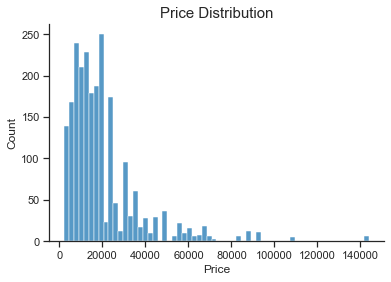

In [73]:
# Target feature distribution

plt.figure()

ax = sns.histplot(data=df_train, x='Price')
ax.set_title("Price Distribution", fontsize=15)
ax.set_xlabel('Price')
ax.set_ylabel('Count')
plt.show()

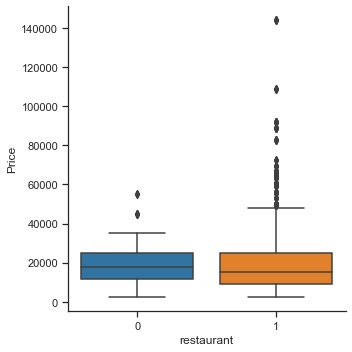

In [74]:
sns.catplot(data=df_train, x="restaurant", y="Price", kind="box")

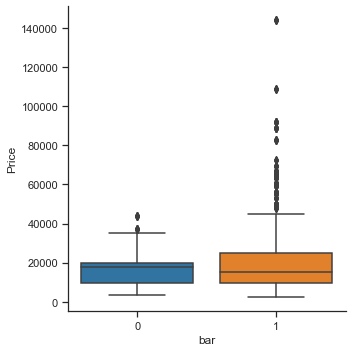

In [75]:
sns.catplot(data=df_train, x="bar", y="Price", kind="box")

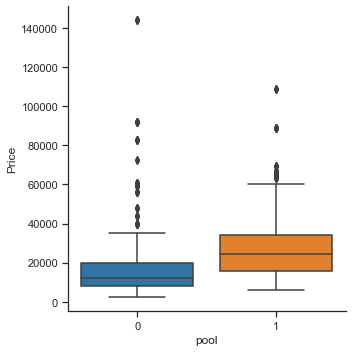

In [76]:
sns.catplot(data=df_train, x="pool", y="Price", kind="box")

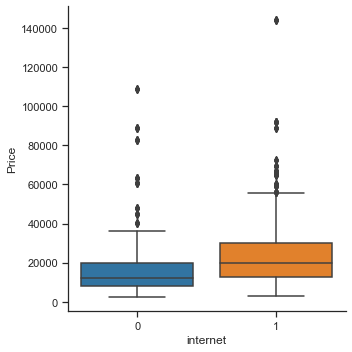

In [77]:
sns.catplot(data=df_train, x="internet", y="Price", kind="box")

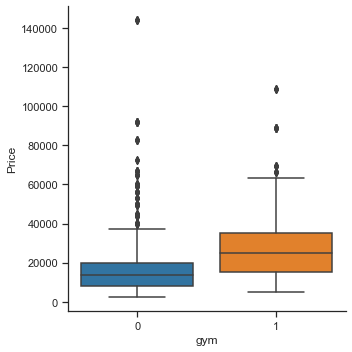

In [78]:
sns.catplot(data=df_train, x="gym", y="Price", kind="box")

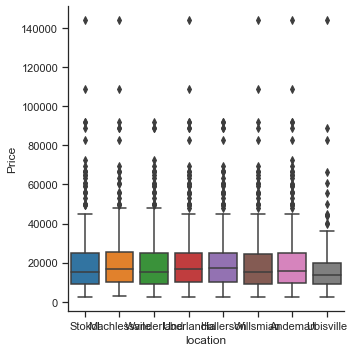

In [79]:
sns.catplot(data=df_train, x="location", y="Price", kind="box")

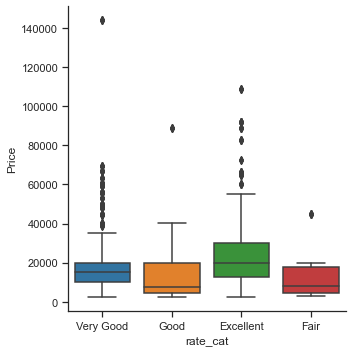

In [80]:
sns.catplot(data=df_train, x="rate_cat", y="Price", kind="box")

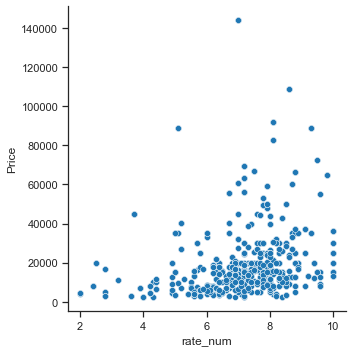

In [81]:
sns.relplot(data=df_train, x="rate_num", y="Price")

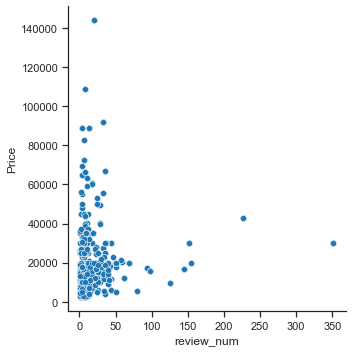

In [82]:
sns.relplot(data=df_train, x="review_num", y="Price")

`Location` sama `review_num` ga ngasih pengaruh signifikan, buang aja

# Modeling

### Train and Test Split

In [83]:
df_train

facilities                         rating      location  \
0         restaurant bar pool   7.8 Very GoodFrom 10 reviews        Stokol   
1     internet restaurant gym         5.6 GoodFrom 4 reviews  Machlessvile   
2     restaurant gym pool bar   7.2 Very GoodFrom 38 reviews    Wanderland   
3              bar restaurant    7.3 Very GoodFrom 6 reviews    Uberlandia   
4         internet restaurant   7.2 Very GoodFrom 30 reviews        Stokol   
...                       ...                            ...           ...   
2299           restaurant bar    7.6 Very GoodFrom 3 reviews       Andeman   
2300  bar restaurant pool gym  7.8 Very GoodFrom 351 reviews       Andeman   
2301  restaurant bar internet    8.1 ExcellentFrom 4 reviews    Uberlandia   
2302      bar restaurant pool   6.7 Very GoodFrom 10 reviews     Willsmian   
2303                 bar pool   7.8 Very GoodFrom 26 reviews       Andeman   

      Price  restaurant  bar  pool  internet  gym  rate_num   rate_cat  \
0     13500           1    1     1         0    0       7.8  Very Good   
1     13000           1    0     0         1    1       5.6       Good   
2     19000           1    1     1         0    1       7.2  Very Good   
3      6000           1    1     0         0    0       7.3  Very Good   
4     20000           1    0     0         1    0       7.2  Very Good   
...     ...         ...  ...   ...       ...  ...       ...        ...   
2299   5000           1    1     0         0    0       7.6  Very Good   
2300  30000           1    1     1         0    1       7.8  Very Good   
2301  30500           1    1     0         1    0       8.1  Excellent   
2302  14000           1    1     1         0    0       6.7  Very Good   
2303  19000           0    1     1         0    0       7.8  Very Good   

      review_num  
0             10  
1              4  
2             38  
3              6  
4             30  
...          ...  
2299           3  
2300         351  
2301           4  
2302          10  
2303          26  

[2304 rows x 12 columns]

In [84]:
df_test_features

ID                        facilities                        rating  \
0      0  gym restaurant bar internet pool   8.0 ExcellentFrom 1 reviews   
1      1  pool restaurant gym internet bar  7.4 Very GoodFrom 22 reviews   
2      2             bar pool internet gym        0.0 FairFrom 4 reviews   
3      3  gym pool bar internet restaurant  6.8 Very GoodFrom 13 reviews   
4      4  gym restaurant pool bar internet        0.0 FairFrom 9 reviews   
..   ...                               ...                           ...   
762  762           bar pool restaurant gym   8.1 ExcellentFrom 9 reviews   
763  763  internet gym pool restaurant bar   8.0 ExcellentFrom 4 reviews   
764  764  restaurant gym internet bar pool  7.4 Very GoodFrom 19 reviews   
765  765  gym internet bar pool restaurant  9.0 ExcellentFrom 17 reviews   
766  766  restaurant gym internet pool bar  6.9 Very GoodFrom 21 reviews   

       location  restaurant  bar  pool  internet  gym  rate_num   rate_cat  \
0        Stokol           1    1     1         1    1       8.0  Excellent   
1     Hallerson           1    1     1         1    1       7.4  Very Good   
2     Hallerson           0    1     1         1    1       0.0       Fair   
3       Andeman           1    1     1         1    1       6.8  Very Good   
4     Hallerson           1    1     1         1    1       0.0       Fair   
..          ...         ...  ...   ...       ...  ...       ...        ...   
762     Andeman           1    1     1         0    1       8.1  Excellent   
763  Wanderland           1    1     1         1    1       8.0  Excellent   
764     Andeman           1    1     1         1    1       7.4  Very Good   
765   Hallerson           1    1     1         1    1       9.0  Excellent   
766  Uberlandia           1    1     1         1    1       6.9  Very Good   

     review_num  
0             1  
1            22  
2             4  
3            13  
4             9  
..          ...  
762           9  
763           4  
764          19  
765          17  
766          21  

[767 rows x 12 columns]

In [85]:
features = ['restaurant', 'bar', 'pool', 'internet', 'gym', 'rate_num']
X = df_train[features]
y = df_train['Price']

X_test = df_test_features[features]

In [86]:
print(len(X.columns))
print(len(X_test.columns))

6
6


In [87]:
# train and validation score
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

### Spot Check Algorithm

In [88]:
from IPython.display import display 
import re
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBRegressor

KeyboardInterrupt: 

In [ ]:
# Spot Check Algorithms

models = [
    ('MLR', LinearRegression()),
    ('R', Ridge(random_state=42)),
    ('L', Lasso(random_state=42)),
    ('CART', DecisionTreeRegressor(criterion='absolute_error', random_state=42)),
    ('RF', RandomForestRegressor(criterion='absolute_error', random_state=42))
]

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=5, random_state=42, shuffle=True)
	cv_results = -1 * cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
	results.append(cv_results)
	names.append(name)

In [ ]:
results_df = pd.DataFrame(np.array(results).T)
results_df.columns = names
results_df

MLR             R             L         CART           RF
0  10207.340075  10206.475715  10206.878202  4619.213873  5313.179855
1  10522.219757  10519.811198  10521.572203  4374.890173  4791.299798
2   9993.318178   9991.698552   9992.639424  4105.468208  5043.426040
3  10376.171425  10375.677817  10375.952738  4997.930435  5841.322391
4  10269.839802  10269.791209  10269.728239  4984.598551  5351.147130

In [ ]:
for col in results_df.columns:
    print(f'{col} \t| Mean: {results_df[col].mean()} \t| Std: {results_df[col].std()}')

MLR 	| Mean: 10273.777847351203 	| Std: 197.03739440633564
R 	| Mean: 10272.690897999908 	| Std: 196.86563007019015
L 	| Mean: 10273.354161274681 	| Std: 197.08603999320093
CART 	| Mean: 4616.420247968501 	| Std: 387.4667255303044
RF 	| Mean: 5268.075043076149 	| Std: 392.2147839647916


### Decision Tree Regressor

In [ ]:
def getMaxDepth(model):
    depth = np.arange(2, 16, 1)
    mae_score = []
    for i in depth:
        mymodel = model(criterion='absolute_error', max_depth=i, random_state=42)
        mymodel.fit(X_train, y_train)
        y_pred = mymodel.predict(X_val)
        MAE = mae(y_val, y_pred)
        mae_score.append(MAE)
        print(f'Max Depth: {i} \t| mae: {MAE}')

    print('Depth with lowest MAE:', mae_score.index(min(mae_score))+2)

In [ ]:
getMaxDepth(model=DecisionTreeRegressor)

Max Depth: 2 	| mae: 8550.079861111111
Max Depth: 3 	| mae: 8246.779513888889
Max Depth: 4 	| mae: 7869.286458333333
Max Depth: 5 	| mae: 7118.482638888889
Max Depth: 6 	| mae: 6855.458333333333
Max Depth: 7 	| mae: 5952.104166666667
Max Depth: 8 	| mae: 5375.631944444444
Max Depth: 9 	| mae: 4731.0234375
Max Depth: 10 	| mae: 4463.963541666667
Max Depth: 11 	| mae: 4016.565972222222
Max Depth: 12 	| mae: 4059.1875
Max Depth: 13 	| mae: 4004.890625
Max Depth: 14 	| mae: 4091.5225694444443
Max Depth: 15 	| mae: 4100.550347222223
Depth with lowest MAE: 13


In [ ]:
model = DecisionTreeRegressor(criterion='absolute_error', max_depth=13, random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=13, random_state=42)

In [ ]:
dtr_pred = model.predict(X_val)
mae(dtr_pred, y_val)

4004.890625

### Random Forest Regressor

In [ ]:
getMaxDepth(model=RandomForestRegressor)

Max Depth: 2 	| mae: 8472.93454861111
Max Depth: 3 	| mae: 8115.915885416666
Max Depth: 4 	| mae: 7660.797413194444
Max Depth: 5 	| mae: 7091.376293402778
Max Depth: 6 	| mae: 6530.101796874999
Max Depth: 7 	| mae: 5971.680815972221
Max Depth: 8 	| mae: 5478.484913194445
Max Depth: 9 	| mae: 5033.787170138889
Max Depth: 10 	| mae: 4706.874140625
Max Depth: 11 	| mae: 4549.798819444444
Max Depth: 12 	| mae: 4393.8000694444445
Max Depth: 13 	| mae: 4357.043506944445
Max Depth: 14 	| mae: 4394.27046875
Max Depth: 15 	| mae: 4375.310277777778
Depth with lowest MAE: 13


In [ ]:
model = RandomForestRegressor(n_estimators = 50, random_state = 42, max_depth = 13, criterion='absolute_error')
model.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=13, n_estimators=50,
                      random_state=42)

In [ ]:
rf_pred = model.predict(X_val)
mae(rf_pred, y_val)

4354.892552083333

### XGB Regressor

In [ ]:
model = XGBRegressor(n_estimators=300, early_stopping_rounds=5, 
eval_metric=mae, learning_rate=0.02, max_depth=15, random_state=42)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:24753.94341	validation_0-mean_absolute_error:18878.06836
[1]	validation_0-rmse:24370.85264	validation_0-mean_absolute_error:18516.57617
[2]	validation_0-rmse:23996.62955	validation_0-mean_absolute_error:18161.81250
[3]	validation_0-rmse:23631.56414	validation_0-mean_absolute_error:17815.08008
[4]	validation_0-rmse:23274.72599	validation_0-mean_absolute_error:17475.98633
[5]	validation_0-rmse:22925.48225	validation_0-mean_absolute_error:17144.24219
[6]	validation_0-rmse:22584.41933	validation_0-mean_absolute_error:16819.56836
[7]	validation_0-rmse:22249.94645	validation_0-mean_absolute_error:16505.84180
[8]	validation_0-rmse:21922.77026	validation_0-mean_absolute_error:16198.93066
[9]	validation_0-rmse:21600.71322	validation_0-mean_absolute_error:15903.81055
[10]	validation_0-rmse:21289.32706	validation_0-mean_absolute_error:15611.10742
[11]	validation_0-rmse:20982.23905	validation_0-mean_absolute_error:15333.09180
[12]	validation_0-rmse:20683.37532	validation_0-me

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x000001CAD75F63A0>,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=15, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, ...)

In [ ]:
xgb_pred = model.predict(X_val)
mae(xgb_pred, y_val)

4547.190928141276

### CatBoost Regressor

In [ ]:
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

In [ ]:
model = CatBoostRegressor(random_state=42)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

Learning rate set to 0.055487
0:	learn: 17514.5393270	test: 15984.8888804	best: 15984.8888804 (0)	total: 147ms	remaining: 2m 26s
1:	learn: 17273.9808222	test: 15736.5510548	best: 15736.5510548 (1)	total: 147ms	remaining: 1m 13s
2:	learn: 17088.0459325	test: 15535.1099488	best: 15535.1099488 (2)	total: 148ms	remaining: 49.2s
3:	learn: 16884.1405367	test: 15322.3980225	best: 15322.3980225 (3)	total: 149ms	remaining: 37.1s
4:	learn: 16709.7588467	test: 15138.4756138	best: 15138.4756138 (4)	total: 150ms	remaining: 29.8s
5:	learn: 16561.6044853	test: 14987.7741441	best: 14987.7741441 (5)	total: 150ms	remaining: 24.9s
6:	learn: 16422.0417427	test: 14834.8284734	best: 14834.8284734 (6)	total: 151ms	remaining: 21.4s
7:	learn: 16291.7676876	test: 14699.8919311	best: 14699.8919311 (7)	total: 152ms	remaining: 18.8s
8:	learn: 16138.2085408	test: 14544.8925987	best: 14544.8925987 (8)	total: 153ms	remaining: 16.8s
9:	learn: 16051.1148800	test: 14451.6002615	best: 14451.6002615 (9)	total: 154ms	remai

In [ ]:
cb_pred = model.predict(X_val)
mae(cb_pred, y_val)

5503.703127200144

In [ ]:
Acc = pd.DataFrame(index=None, columns=['model','MAE','Accuracy on Traing set','Accuracy on Testing set'])

In [ ]:
  regressors = [['DecisionTreeRegressor',DecisionTreeRegressor()],
              ['XGBRegressor', XGBRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['ExtraTreesRegressor',ExtraTreesRegressor()]]

for mod in regressors:
    name = mod[0]
    model = mod[1]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    
    MAE = mae(y_val, y_pred)
    ATrS =  model.score(X_train,y_train)
    ATeS = model.score(X_val,y_val)
    
    Acc = Acc.append(pd.Series({'model':name, 'MAE': MAE,'Accuracy on Traing set':ATrS,'Accuracy on Testing set':ATeS}),ignore_index=True )

In [ ]:
Acc

model           MAE Accuracy on Traing set  \
0  DecisionTreeRegressor   4497.061146               0.646656   
1           XGBRegressor   4588.080782               0.646502   
2  RandomForestRegressor   4625.645904               0.645545   
3           MLPRegressor  15394.142713              -0.874289   
4      AdaBoostRegressor    10584.4403               0.141328   
5    ExtraTreesRegressor   4485.793785               0.646656   

  Accuracy on Testing set  
0                0.586852  
1                0.587274  
2                0.585377  
3               -0.871335  
4                0.030429  
5                0.587043

### Extra Tree Regressor

In [ ]:
model = ExtraTreesRegressor(random_state=42)

model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [ ]:
et_pred = model.predict(X_val)
mae(et_pred, y_val)

4491.542048787372

# Modeling (Felix)

## Train Test Split

In [126]:
# train and validation score
features = ['location', 'restaurant', 'bar',
       'pool', 'internet', 'gym', 'rate_num', 'rate_cat', 'review_num']
categorical_features = ["location", "rate_cat"]
 
X = df_train[features]
y = df_train['Price']

X_test = df_test_features[features]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)


In [127]:
ct = ColumnTransformer( 
    [('ordinal', oe(), categorical_features)],
    remainder='passthrough')

## XGBoost

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(ct.fit_transform(X_train), y_train)
    y_pred = model.predict(ct.fit_transform(X_val))
    return mean_absolute_error(y_val, y_pred)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="minimize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [129]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 703.7938702265578
  Params: 
    learning_rate=0.19256883915587863,
    depth=9,
    l2_leaf_reg=1.5,
    min_child_samples=16,
    iterations=1200,


In [130]:
optimized_params = {'max_depth':10,
                    'learning_rate':0.4943369735774721,
                    'n_estimators':817,
                    'min_child_weight':1,
                    'gamma':0.04536850220700724,
                    'subsample':0.9948558833808666,
                    'colsample_bytree':0.9665618219848798,
                    'reg_alpha':0.3802214190953635,
                    'reg_lambda':0.5768424525242781,
                    'random_state':838}

In [141]:
ct = ColumnTransformer( 
    [('ordinal', oe(), ['rate_cat'])],
    remainder='passthrough')

In [142]:
features = ['internet', 'gym', 'review_num', 'rate_num', 'rate_cat']
model = xgb.XGBRFRegressor(**optimized_params)

model.fit(ct.fit_transform(X[features]), y)
y_pred = model.predict(ct.fit_transform(X_val[features]))
mean_absolute_error(y_val, y_pred)

10281.118130577936

Text(0.5, 1.0, 'Feature Importance')

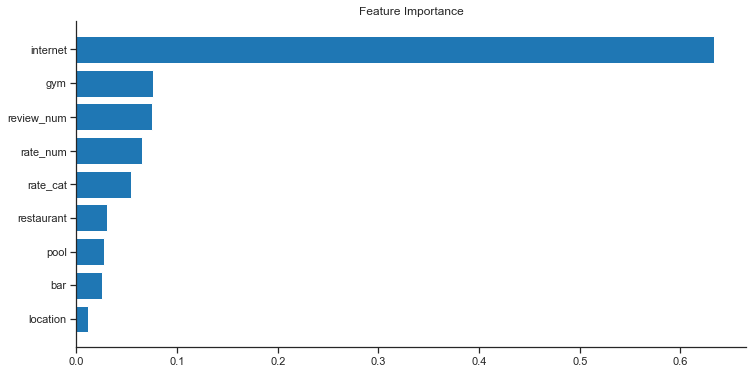

In [139]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

### Feature Selection

In [ ]:
sfs1 = SFS(XGBRegressor(n_estimators=817, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring = 'neg_mean_absolute_error',
           cv=5)

In [ ]:
# proses fitting sequential Feature Selection model Catboost untuk mencari features optimal
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train).ravel())

In [ ]:
# dataframe hasil SFS
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

feature_idx  \
1                         (8,)   
2                       (7, 8)   
3                    (5, 7, 8)   
4                 (5, 6, 7, 8)   
5              (4, 5, 6, 7, 8)   
6           (2, 4, 5, 6, 7, 8)   
7        (2, 3, 4, 5, 6, 7, 8)   
8     (1, 2, 3, 4, 5, 6, 7, 8)   
9  (0, 1, 2, 3, 4, 5, 6, 7, 8)   

                                           cv_scores     avg_score  \
1  [-10748.880057803468, -9370.160142137825, -103... -10030.267652   
2  [-2575.3284778043712, -2422.7752756107748, -22...  -2349.772068   
3  [-1356.0989496308255, -1189.8243189464415, -10...  -1222.112047   
4  [-987.5904533959538, -716.6579102973717, -676....   -777.842154   
5  [-767.752117531837, -445.5541595282582, -453.8...   -541.091798   
6  [-710.5449484235289, -225.36855285291728, -387...   -435.550385   
7  [-620.5032112253883, -236.4988569138367, -385....   -429.001766   
8  [-648.6809745303468, -219.25994061596822, -402...    -432.30383   
9  [-1315.6711009472092, -911.4171378957054, -151...   -1160.62474   

                 feature_names    ci_bound     std_dev     std_err  
1                         (8,)  623.299204  484.947956  242.473978  
2                       (7, 8)  172.148862  133.937663   66.968832  
3                    (5, 7, 8)  239.929041  186.672945   93.336473  
4                 (5, 6, 7, 8)  235.071401  182.893536   91.446768  
5              (4, 5, 6, 7, 8)  226.272717  176.047861   88.023931  
6           (2, 4, 5, 6, 7, 8)  245.487168  190.997357   95.498678  
7        (2, 3, 4, 5, 6, 7, 8)  256.394593  199.483704   99.741852  
8     (1, 2, 3, 4, 5, 6, 7, 8)  268.362619  208.795235  104.397617  
9  (0, 1, 2, 3, 4, 5, 6, 7, 8)  386.815864  300.955884  150.477942

In [ ]:
all_cols = X_train.columns
# proses perhitungan feature dengan features paling optimal
sfdf1['avg_score'] = sfdf1['avg_score'].astype('float')
index = sfdf1['avg_score'].idxmax()
selected_columns_1 = [all_cols[i] for i in 
                     list(sfdf1.loc[index, 'feature_idx'])]

In [ ]:
selected_columns_1

['bar', 'pool', 'internet', 'gym', 'rate_num', 'rate_cat', 'review_num']

In [ ]:
# train and validation score
features = ['bar', 'pool', 'internet', 'gym', 'rate_num', 'rate_cat', 'review_num']
categorical_features = ["rate_cat"]
 
X = df_train[features]
y = df_train['Price']

X_test = df_test_features[features]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
ct = ColumnTransformer( 
    [('ordinal', oe(), categorical_features)],
    remainder='passthrough')

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(ct.fit_transform(X_train), y_train)
    y_pred = model.predict(ct.fit_transform(X_val))
    return mean_absolute_error(y_val, y_pred)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="minimize", sampler=sampler)

study.optimize(objective, n_trials=100)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 386.5756547715929
  Params: 
    max_depth=7,
    learning_rate=0.7121853538422951,
    n_estimators=879,
    min_child_weight=2,
    gamma=0.5291589089678572,
    subsample=0.9333030478382662,
    colsample_bytree=0.9039281624538111,
    reg_alpha=0.5794947133433879,
    reg_lambda=0.12420800395125556,
    random_state=858,


In [ ]:
model = xgb.XGBRFRegressor(**trial.params)

model.fit(ct.fit_transform(X), y)
y_pred = model.predict(ct.fit_transform(X_val))
mean_absolute_error(y_val, y_pred)

7110.799790276422

## Catboost

In [ ]:
def objective(trial):
    param = {
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'depth': trial.suggest_int('depth', 9, 15),
        'l2_leaf_reg': trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'Depthwise',
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'eval_metric': 'MAE',
        'od_wait': 20,
    }
    model = CatBoostRegressor(**param)
    model.fit(ct.fit_transform(X_train), y_train)
    y_pred = model.predict(ct.fit_transform(X_val))
    
    return mean_absolute_error(y_val, y_pred)

In [ ]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="minimize", sampler=sampler)

study.optimize(objective, n_trials=100)

[I 2023-05-22 17:38:02,498] A new study created in memory with name: no-name-32449c89-657c-44dc-93f3-4e036ad1d937


0:	learn: 11449.2289911	total: 30.6ms	remaining: 45.8s
1:	learn: 10987.4839171	total: 69.3ms	remaining: 51.9s
2:	learn: 10620.2308393	total: 95.4ms	remaining: 47.6s
3:	learn: 10191.4656482	total: 146ms	remaining: 54.8s
4:	learn: 9757.9084988	total: 181ms	remaining: 54.1s
5:	learn: 9367.6158011	total: 211ms	remaining: 52.5s
6:	learn: 9018.9905877	total: 236ms	remaining: 50.2s
7:	learn: 8664.5337198	total: 261ms	remaining: 48.8s
8:	learn: 8341.1851862	total: 299ms	remaining: 49.6s
9:	learn: 8015.7144928	total: 346ms	remaining: 51.5s
10:	learn: 7764.2912322	total: 382ms	remaining: 51.6s
11:	learn: 7487.1861631	total: 407ms	remaining: 50.5s
12:	learn: 7234.7002504	total: 431ms	remaining: 49.3s
13:	learn: 7015.7465868	total: 463ms	remaining: 49.2s
14:	learn: 6796.0679393	total: 497ms	remaining: 49.2s
15:	learn: 6548.6337051	total: 538ms	remaining: 49.9s
16:	learn: 6354.6475277	total: 562ms	remaining: 49.1s
17:	learn: 6201.8474614	total: 583ms	remaining: 48s
18:	learn: 5982.3752587	total: 61

[I 2023-05-22 17:39:11,198] Trial 0 finished with value: 1220.9133859143355 and parameters: {'learning_rate': 0.0673759581558321, 'depth': 15, 'l2_leaf_reg': 2.0, 'min_child_samples': 1, 'iterations': 1500}. Best is trial 0 with value: 1220.9133859143355.


0:	learn: 11383.1447212	total: 22ms	remaining: 22s
1:	learn: 10866.1259767	total: 53.8ms	remaining: 26.8s
2:	learn: 10377.1999988	total: 78.8ms	remaining: 26.2s
3:	learn: 9911.0932604	total: 116ms	remaining: 28.9s
4:	learn: 9437.5129081	total: 139ms	remaining: 27.6s
5:	learn: 9034.4762801	total: 179ms	remaining: 29.7s
6:	learn: 8670.5543028	total: 209ms	remaining: 29.6s
7:	learn: 8348.8186450	total: 290ms	remaining: 36s
8:	learn: 8035.9704785	total: 315ms	remaining: 34.7s
9:	learn: 7728.2956041	total: 342ms	remaining: 33.9s
10:	learn: 7449.8125140	total: 392ms	remaining: 35.2s
11:	learn: 7231.5347057	total: 416ms	remaining: 34.3s
12:	learn: 6969.3724628	total: 450ms	remaining: 34.1s
13:	learn: 6766.7951628	total: 478ms	remaining: 33.7s
14:	learn: 6504.6666763	total: 498ms	remaining: 32.7s
15:	learn: 6282.5560163	total: 514ms	remaining: 31.6s
16:	learn: 6121.1720232	total: 527ms	remaining: 30.5s
17:	learn: 5924.5308976	total: 543ms	remaining: 29.6s
18:	learn: 5732.9647978	total: 564ms	r

[I 2023-05-22 17:39:28,034] Trial 1 finished with value: 997.0964682709631 and parameters: {'learning_rate': 0.08295185213567516, 'depth': 11, 'l2_leaf_reg': 2.0, 'min_child_samples': 1, 'iterations': 1000}. Best is trial 1 with value: 997.0964682709631.


0:	learn: 11891.1071428	total: 11.4ms	remaining: 2.27s
1:	learn: 11833.5899987	total: 37.5ms	remaining: 3.71s
2:	learn: 11789.0152556	total: 57ms	remaining: 3.74s
3:	learn: 11744.7964388	total: 85.3ms	remaining: 4.18s
4:	learn: 11693.0518432	total: 103ms	remaining: 4s
5:	learn: 11650.0971736	total: 122ms	remaining: 3.95s
6:	learn: 11608.9487799	total: 137ms	remaining: 3.77s
7:	learn: 11557.0371321	total: 156ms	remaining: 3.73s
8:	learn: 11514.0617267	total: 169ms	remaining: 3.58s
9:	learn: 11469.6067750	total: 183ms	remaining: 3.48s
10:	learn: 11427.5778689	total: 198ms	remaining: 3.4s
11:	learn: 11374.6814847	total: 212ms	remaining: 3.32s
12:	learn: 11331.9156021	total: 230ms	remaining: 3.31s
13:	learn: 11281.6619397	total: 247ms	remaining: 3.28s
14:	learn: 11240.5837069	total: 267ms	remaining: 3.29s
15:	learn: 11192.0403975	total: 359ms	remaining: 4.12s
16:	learn: 11148.1434406	total: 373ms	remaining: 4.02s
17:	learn: 11099.9848989	total: 397ms	remaining: 4.02s
18:	learn: 11056.11444

[I 2023-05-22 17:39:30,810] Trial 2 finished with value: 6373.669271015485 and parameters: {'learning_rate': 0.008267661927216603, 'depth': 10, 'l2_leaf_reg': 4.0, 'min_child_samples': 1, 'iterations': 200}. Best is trial 1 with value: 997.0964682709631.


0:	learn: 10964.7615729	total: 24.6ms	remaining: 12.3s
1:	learn: 10150.2945849	total: 64.1ms	remaining: 16s
2:	learn: 9348.8113255	total: 93.8ms	remaining: 15.5s
3:	learn: 8598.8350672	total: 122ms	remaining: 15.2s
4:	learn: 7992.4818674	total: 158ms	remaining: 15.6s
5:	learn: 7505.4401375	total: 182ms	remaining: 14.9s
6:	learn: 6990.1036958	total: 211ms	remaining: 14.8s
7:	learn: 6552.6685920	total: 231ms	remaining: 14.2s
8:	learn: 6121.0871394	total: 270ms	remaining: 14.7s
9:	learn: 5717.4357643	total: 309ms	remaining: 15.2s
10:	learn: 5363.7858773	total: 351ms	remaining: 15.6s
11:	learn: 5010.7578123	total: 375ms	remaining: 15.3s
12:	learn: 4686.9113003	total: 405ms	remaining: 15.2s
13:	learn: 4476.1336028	total: 425ms	remaining: 14.7s
14:	learn: 4203.8170190	total: 475ms	remaining: 15.4s
15:	learn: 4006.6950180	total: 523ms	remaining: 15.8s
16:	learn: 3820.1023263	total: 551ms	remaining: 15.6s
17:	learn: 3628.2090265	total: 579ms	remaining: 15.5s
18:	learn: 3430.1577404	total: 610m

[I 2023-05-22 17:39:59,233] Trial 3 finished with value: 1337.4779523476996 and parameters: {'learning_rate': 0.14137702315551562, 'depth': 15, 'l2_leaf_reg': 2.5, 'min_child_samples': 1, 'iterations': 500}. Best is trial 1 with value: 997.0964682709631.


0:	learn: 10867.1850805	total: 14.4ms	remaining: 2.86s
1:	learn: 10053.9366747	total: 30.3ms	remaining: 3s
2:	learn: 9258.5786410	total: 48.6ms	remaining: 3.19s
3:	learn: 8494.8766555	total: 69ms	remaining: 3.38s
4:	learn: 7803.3807300	total: 95.3ms	remaining: 3.72s
5:	learn: 7263.9344921	total: 114ms	remaining: 3.67s
6:	learn: 6781.3106618	total: 136ms	remaining: 3.76s
7:	learn: 6307.1100376	total: 158ms	remaining: 3.8s
8:	learn: 5910.4555143	total: 184ms	remaining: 3.9s
9:	learn: 5500.6789626	total: 210ms	remaining: 4s
10:	learn: 5214.3517494	total: 239ms	remaining: 4.1s
11:	learn: 4996.3399380	total: 260ms	remaining: 4.07s
12:	learn: 4750.7407421	total: 277ms	remaining: 3.98s
13:	learn: 4578.9937929	total: 294ms	remaining: 3.91s
14:	learn: 4289.1653903	total: 311ms	remaining: 3.83s
15:	learn: 4129.2354731	total: 327ms	remaining: 3.76s
16:	learn: 3904.4761525	total: 346ms	remaining: 3.72s
17:	learn: 3699.1014670	total: 367ms	remaining: 3.71s
18:	learn: 3521.7527740	total: 384ms	remai

[I 2023-05-22 17:40:08,925] Trial 4 finished with value: 1195.4997200790392 and parameters: {'learning_rate': 0.19097150546898603, 'depth': 14, 'l2_leaf_reg': 5.5, 'min_child_samples': 1, 'iterations': 200}. Best is trial 1 with value: 997.0964682709631.


0:	learn: 11299.3533017	total: 9.13ms	remaining: 9.12s
1:	learn: 10641.0694650	total: 23.8ms	remaining: 11.9s
2:	learn: 10211.0156570	total: 30.8ms	remaining: 10.2s
3:	learn: 9663.4288654	total: 37.4ms	remaining: 9.3s
4:	learn: 9197.8229145	total: 44.5ms	remaining: 8.86s
5:	learn: 8733.2313416	total: 50.3ms	remaining: 8.33s
6:	learn: 8398.3492417	total: 55.4ms	remaining: 7.87s
7:	learn: 8079.6605600	total: 60.4ms	remaining: 7.49s
8:	learn: 7763.7833123	total: 66.3ms	remaining: 7.29s
9:	learn: 7438.0392776	total: 72.4ms	remaining: 7.17s
10:	learn: 7184.3577258	total: 78.6ms	remaining: 7.06s
11:	learn: 6879.3077674	total: 83.8ms	remaining: 6.9s
12:	learn: 6604.5633750	total: 91.8ms	remaining: 6.97s
13:	learn: 6336.3478364	total: 99.5ms	remaining: 7s
14:	learn: 6160.0467900	total: 106ms	remaining: 6.96s
15:	learn: 5999.7225681	total: 113ms	remaining: 6.92s
16:	learn: 5756.4717627	total: 119ms	remaining: 6.88s
17:	learn: 5576.1242538	total: 127ms	remaining: 6.94s
18:	learn: 5422.3191413	to

[I 2023-05-22 17:40:15,322] Trial 5 finished with value: 916.6282023977999 and parameters: {'learning_rate': 0.10627638579414418, 'depth': 13, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'iterations': 1000}. Best is trial 5 with value: 916.6282023977999.


0:	learn: 10447.6818606	total: 3.68ms	remaining: 1.1s
1:	learn: 9424.9780268	total: 8.72ms	remaining: 1.3s
2:	learn: 8552.5922216	total: 13.6ms	remaining: 1.34s
3:	learn: 7656.8816480	total: 18.7ms	remaining: 1.38s
4:	learn: 6780.4559221	total: 23.5ms	remaining: 1.39s
5:	learn: 6279.6241538	total: 28.6ms	remaining: 1.4s
6:	learn: 5814.0632536	total: 35.3ms	remaining: 1.48s
7:	learn: 5506.2395188	total: 40.5ms	remaining: 1.48s
8:	learn: 5272.0207614	total: 44.9ms	remaining: 1.45s
9:	learn: 4983.7540664	total: 50.1ms	remaining: 1.45s
10:	learn: 4664.0912803	total: 56ms	remaining: 1.47s
11:	learn: 4524.2855232	total: 60.2ms	remaining: 1.45s
12:	learn: 4311.8759181	total: 66.3ms	remaining: 1.46s
13:	learn: 4056.7874823	total: 71.6ms	remaining: 1.46s
14:	learn: 3879.4963946	total: 76.9ms	remaining: 1.46s
15:	learn: 3801.8788411	total: 81.4ms	remaining: 1.44s
16:	learn: 3618.0183977	total: 85ms	remaining: 1.42s
17:	learn: 3593.9317144	total: 87.4ms	remaining: 1.37s
18:	learn: 3413.7338622	to

[I 2023-05-22 17:40:17,620] Trial 6 finished with value: 953.9285332382996 and parameters: {'learning_rate': 0.2580523592094693, 'depth': 9, 'l2_leaf_reg': 3.0, 'min_child_samples': 1, 'iterations': 300}. Best is trial 5 with value: 916.6282023977999.


0:	learn: 10589.9387428	total: 5.2ms	remaining: 5.19s
1:	learn: 9578.7220697	total: 13.9ms	remaining: 6.96s
2:	learn: 8666.3051884	total: 21.2ms	remaining: 7.04s
3:	learn: 8015.5990395	total: 28.7ms	remaining: 7.14s
4:	learn: 7399.0179277	total: 34.8ms	remaining: 6.93s
5:	learn: 6994.3032176	total: 41.3ms	remaining: 6.84s
6:	learn: 6500.8320592	total: 47.7ms	remaining: 6.76s
7:	learn: 5900.5009222	total: 55.7ms	remaining: 6.9s
8:	learn: 5487.1063781	total: 63ms	remaining: 6.93s
9:	learn: 5213.4339170	total: 69.1ms	remaining: 6.84s
10:	learn: 5029.2458601	total: 74.2ms	remaining: 6.67s
11:	learn: 4777.9658422	total: 81.5ms	remaining: 6.71s
12:	learn: 4612.7123007	total: 87ms	remaining: 6.61s
13:	learn: 4316.3138688	total: 94.4ms	remaining: 6.65s
14:	learn: 4127.2332208	total: 101ms	remaining: 6.67s
15:	learn: 3990.8551858	total: 106ms	remaining: 6.51s
16:	learn: 3787.3691783	total: 112ms	remaining: 6.48s
17:	learn: 3698.5542623	total: 117ms	remaining: 6.39s
18:	learn: 3513.6660035	total

[I 2023-05-22 17:40:24,774] Trial 7 finished with value: 888.8810012277063 and parameters: {'learning_rate': 0.21117968105827548, 'depth': 11, 'l2_leaf_reg': 2.5, 'min_child_samples': 4, 'iterations': 1000}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 10679.4438100	total: 10.9ms	remaining: 10.9s
1:	learn: 9712.4416922	total: 26ms	remaining: 13s
2:	learn: 8810.9732988	total: 42.8ms	remaining: 14.2s
3:	learn: 8062.9793009	total: 60.3ms	remaining: 15s
4:	learn: 7340.0163487	total: 76ms	remaining: 15.1s
5:	learn: 6817.2061096	total: 91.3ms	remaining: 15.1s
6:	learn: 6344.4733303	total: 106ms	remaining: 15.1s
7:	learn: 5815.4317850	total: 124ms	remaining: 15.4s
8:	learn: 5378.1377767	total: 141ms	remaining: 15.5s
9:	learn: 4963.9122171	total: 158ms	remaining: 15.6s
10:	learn: 4723.5764294	total: 173ms	remaining: 15.5s
11:	learn: 4417.1445173	total: 189ms	remaining: 15.6s
12:	learn: 4211.7663517	total: 210ms	remaining: 15.9s
13:	learn: 4035.3355236	total: 226ms	remaining: 15.9s
14:	learn: 3846.9630944	total: 239ms	remaining: 15.7s
15:	learn: 3672.2744768	total: 255ms	remaining: 15.7s
16:	learn: 3472.0915900	total: 271ms	remaining: 15.7s
17:	learn: 3288.2193022	total: 281ms	remaining: 15.3s
18:	learn: 3143.1670012	total: 295ms	re

[I 2023-05-22 17:40:49,295] Trial 8 finished with value: 1317.8834574511766 and parameters: {'learning_rate': 0.21330466515897709, 'depth': 13, 'l2_leaf_reg': 4.5, 'min_child_samples': 1, 'iterations': 1000}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 11539.7596849	total: 3.88ms	remaining: 1.16s
1:	learn: 11227.9022072	total: 7.73ms	remaining: 1.15s
2:	learn: 10883.4017209	total: 11.4ms	remaining: 1.13s
3:	learn: 10523.2514102	total: 15.8ms	remaining: 1.17s
4:	learn: 10297.3279857	total: 20ms	remaining: 1.18s
5:	learn: 9970.2213301	total: 23.4ms	remaining: 1.15s
6:	learn: 9731.7894255	total: 27.6ms	remaining: 1.16s
7:	learn: 9538.5994720	total: 30.6ms	remaining: 1.12s
8:	learn: 9302.0988511	total: 34.2ms	remaining: 1.1s
9:	learn: 9073.4193450	total: 37.9ms	remaining: 1.1s
10:	learn: 8843.6725024	total: 42.5ms	remaining: 1.12s
11:	learn: 8679.0205481	total: 45.6ms	remaining: 1.09s
12:	learn: 8444.3677042	total: 49.9ms	remaining: 1.1s
13:	learn: 8269.4566598	total: 53.6ms	remaining: 1.09s
14:	learn: 8086.8004572	total: 58.3ms	remaining: 1.11s
15:	learn: 7903.1836871	total: 62.2ms	remaining: 1.1s
16:	learn: 7798.9914725	total: 64.7ms	remaining: 1.08s
17:	learn: 7659.8720652	total: 67.9ms	remaining: 1.06s
18:	learn: 7553.68195

[I 2023-05-22 17:40:50,663] Trial 9 finished with value: 1560.0034890932516 and parameters: {'learning_rate': 0.07339019400452453, 'depth': 9, 'l2_leaf_reg': 5.0, 'min_child_samples': 8, 'iterations': 300}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 9882.8158009	total: 7.3ms	remaining: 723ms
1:	learn: 8110.4755302	total: 18.3ms	remaining: 895ms
2:	learn: 7246.9656111	total: 27ms	remaining: 873ms
3:	learn: 6540.0754760	total: 36ms	remaining: 865ms
4:	learn: 5895.1055165	total: 47.1ms	remaining: 895ms
5:	learn: 5233.2481533	total: 57.6ms	remaining: 903ms
6:	learn: 4845.8668991	total: 64.7ms	remaining: 860ms
7:	learn: 4477.5098511	total: 72.5ms	remaining: 834ms
8:	learn: 4191.1981683	total: 80.2ms	remaining: 811ms
9:	learn: 3988.1887451	total: 84.8ms	remaining: 763ms
10:	learn: 3733.9457789	total: 89.9ms	remaining: 727ms
11:	learn: 3430.1125891	total: 96ms	remaining: 704ms
12:	learn: 3078.3286081	total: 104ms	remaining: 694ms
13:	learn: 3028.7046008	total: 108ms	remaining: 664ms
14:	learn: 2953.7584454	total: 114ms	remaining: 644ms
15:	learn: 2748.8652109	total: 120ms	remaining: 632ms
16:	learn: 2568.8667589	total: 127ms	remaining: 621ms
17:	learn: 2476.5238038	total: 133ms	remaining: 604ms
18:	learn: 2327.3409762	total: 13

[I 2023-05-22 17:40:51,630] Trial 10 finished with value: 1019.2939810773257 and parameters: {'learning_rate': 0.2958247063933723, 'depth': 11, 'l2_leaf_reg': 1.0, 'min_child_samples': 4, 'iterations': 100}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 11051.7594549	total: 7.27ms	remaining: 7.26s
1:	learn: 10414.9358524	total: 16.4ms	remaining: 8.19s
2:	learn: 9782.4619961	total: 26.1ms	remaining: 8.68s
3:	learn: 9431.2418130	total: 34ms	remaining: 8.47s
4:	learn: 8913.0872523	total: 45.3ms	remaining: 9.02s
5:	learn: 8436.4696416	total: 54.5ms	remaining: 9.03s
6:	learn: 7983.5129499	total: 64.2ms	remaining: 9.11s
7:	learn: 7511.6797410	total: 74.5ms	remaining: 9.24s
8:	learn: 7116.2113708	total: 85.7ms	remaining: 9.43s
9:	learn: 6804.5921093	total: 97.5ms	remaining: 9.65s
10:	learn: 6528.5895516	total: 107ms	remaining: 9.6s
11:	learn: 6178.2100947	total: 116ms	remaining: 9.54s
12:	learn: 5930.8581994	total: 126ms	remaining: 9.56s
13:	learn: 5688.4159097	total: 133ms	remaining: 9.38s
14:	learn: 5381.8988904	total: 146ms	remaining: 9.56s
15:	learn: 5147.5317130	total: 156ms	remaining: 9.62s
16:	learn: 4993.4901733	total: 165ms	remaining: 9.53s
17:	learn: 4783.6726831	total: 174ms	remaining: 9.47s
18:	learn: 4554.0857142	total

[I 2023-05-22 17:41:01,564] Trial 11 finished with value: 915.4276975890612 and parameters: {'learning_rate': 0.14268677622351447, 'depth': 12, 'l2_leaf_reg': 3.5, 'min_child_samples': 4, 'iterations': 1000}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 10871.9028276	total: 6.42ms	remaining: 7.7s
1:	learn: 10125.5585279	total: 13.7ms	remaining: 8.19s
2:	learn: 9328.2538804	total: 23ms	remaining: 9.19s
3:	learn: 8591.8613122	total: 31.9ms	remaining: 9.54s
4:	learn: 7942.3173362	total: 41.3ms	remaining: 9.87s
5:	learn: 7442.6310912	total: 49.4ms	remaining: 9.83s
6:	learn: 7058.2906043	total: 56.7ms	remaining: 9.66s
7:	learn: 6758.8855230	total: 65ms	remaining: 9.68s
8:	learn: 6391.0919189	total: 72.9ms	remaining: 9.64s
9:	learn: 6141.8978968	total: 79.8ms	remaining: 9.5s
10:	learn: 5835.2375795	total: 88ms	remaining: 9.51s
11:	learn: 5578.2609694	total: 96.1ms	remaining: 9.52s
12:	learn: 5250.9458982	total: 105ms	remaining: 9.61s
13:	learn: 5008.1297071	total: 113ms	remaining: 9.61s
14:	learn: 4859.9040888	total: 120ms	remaining: 9.46s
15:	learn: 4677.1637632	total: 128ms	remaining: 9.46s
16:	learn: 4445.3509162	total: 137ms	remaining: 9.52s
17:	learn: 4268.3245307	total: 146ms	remaining: 9.59s
18:	learn: 4096.5722699	total: 1

[I 2023-05-22 17:41:14,969] Trial 12 finished with value: 932.1983851145038 and parameters: {'learning_rate': 0.17754277289174103, 'depth': 12, 'l2_leaf_reg': 4.0, 'min_child_samples': 4, 'iterations': 1200}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 10883.2525124	total: 5.16ms	remaining: 5.15s
1:	learn: 10162.2238248	total: 12.5ms	remaining: 6.22s
2:	learn: 9365.4197470	total: 19.4ms	remaining: 6.43s
3:	learn: 8864.8033725	total: 25.1ms	remaining: 6.24s
4:	learn: 8233.3861962	total: 32.1ms	remaining: 6.4s
5:	learn: 7593.9441405	total: 40.6ms	remaining: 6.73s
6:	learn: 7150.3317656	total: 47.7ms	remaining: 6.76s
7:	learn: 6859.9537066	total: 54.5ms	remaining: 6.75s
8:	learn: 6485.4599202	total: 61ms	remaining: 6.72s
9:	learn: 6188.1589407	total: 67.7ms	remaining: 6.7s
10:	learn: 5849.7956613	total: 75.6ms	remaining: 6.8s
11:	learn: 5549.2018194	total: 82.4ms	remaining: 6.78s
12:	learn: 5280.0192379	total: 90.7ms	remaining: 6.88s
13:	learn: 5125.2465290	total: 95.3ms	remaining: 6.71s
14:	learn: 4895.4060664	total: 102ms	remaining: 6.71s
15:	learn: 4789.0074024	total: 108ms	remaining: 6.64s
16:	learn: 4604.2620158	total: 114ms	remaining: 6.58s
17:	learn: 4331.2930058	total: 121ms	remaining: 6.61s
18:	learn: 4161.2567165	tot

[I 2023-05-22 17:41:22,215] Trial 13 finished with value: 1052.4448212551927 and parameters: {'learning_rate': 0.1418635507656165, 'depth': 11, 'l2_leaf_reg': 1.0, 'min_child_samples': 4, 'iterations': 1000}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 10711.7436911	total: 7.37ms	remaining: 7.36s
1:	learn: 9946.1387259	total: 10.2ms	remaining: 5.08s
2:	learn: 9048.1338477	total: 13.3ms	remaining: 4.41s
3:	learn: 8333.0513856	total: 23.7ms	remaining: 5.89s
4:	learn: 7973.6295497	total: 26.7ms	remaining: 5.32s
5:	learn: 7583.6174495	total: 31ms	remaining: 5.13s
6:	learn: 7094.0680298	total: 36.9ms	remaining: 5.23s
7:	learn: 6900.7696546	total: 39.5ms	remaining: 4.9s
8:	learn: 6533.4478373	total: 42.4ms	remaining: 4.67s
9:	learn: 6312.2264108	total: 44.9ms	remaining: 4.45s
10:	learn: 5999.9032596	total: 51ms	remaining: 4.59s
11:	learn: 5912.3420167	total: 53.2ms	remaining: 4.38s
12:	learn: 5743.3248711	total: 55.6ms	remaining: 4.22s
13:	learn: 5496.4677672	total: 58.4ms	remaining: 4.12s
14:	learn: 5336.9284415	total: 62.5ms	remaining: 4.1s
15:	learn: 5156.2204338	total: 65.4ms	remaining: 4.02s
16:	learn: 5045.8102600	total: 67.6ms	remaining: 3.91s
17:	learn: 4818.2454319	total: 70.2ms	remaining: 3.83s
18:	learn: 4754.3735698	t

[I 2023-05-22 17:41:25,907] Trial 14 finished with value: 967.9249758667231 and parameters: {'learning_rate': 0.22419671784194442, 'depth': 12, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'iterations': 1000}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 10871.2561780	total: 6.85ms	remaining: 679ms
1:	learn: 10014.1051171	total: 10.2ms	remaining: 500ms
2:	learn: 9366.3924510	total: 13.3ms	remaining: 430ms
3:	learn: 8661.6701429	total: 17.1ms	remaining: 410ms
4:	learn: 8125.8781556	total: 22.4ms	remaining: 425ms
5:	learn: 7644.3172079	total: 27.1ms	remaining: 425ms
6:	learn: 7283.4775750	total: 30.6ms	remaining: 406ms
7:	learn: 6937.5035281	total: 34.3ms	remaining: 394ms
8:	learn: 6687.7635384	total: 37.4ms	remaining: 378ms
9:	learn: 6395.7360224	total: 40.8ms	remaining: 367ms
10:	learn: 6190.1559980	total: 43.7ms	remaining: 354ms
11:	learn: 5979.3258957	total: 46.4ms	remaining: 340ms
12:	learn: 5762.3313373	total: 52.1ms	remaining: 348ms
13:	learn: 5526.1786193	total: 54.7ms	remaining: 336ms
14:	learn: 5268.9794987	total: 58.1ms	remaining: 329ms
15:	learn: 5145.8800094	total: 60.9ms	remaining: 320ms
16:	learn: 4959.4032120	total: 64.6ms	remaining: 315ms
17:	learn: 4820.5258672	total: 67.1ms	remaining: 306ms
18:	learn: 4718.80

[I 2023-05-22 17:41:26,581] Trial 15 finished with value: 1597.668724892299 and parameters: {'learning_rate': 0.1734502438584406, 'depth': 10, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 100}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 10457.2545291	total: 10.4ms	remaining: 5.2s
1:	learn: 9368.6077666	total: 26.9ms	remaining: 6.7s
2:	learn: 8524.2332156	total: 39.3ms	remaining: 6.51s
3:	learn: 7710.6455262	total: 56.3ms	remaining: 6.98s
4:	learn: 7041.8930642	total: 76.3ms	remaining: 7.55s
5:	learn: 6525.6147032	total: 89.2ms	remaining: 7.34s
6:	learn: 5915.3140798	total: 101ms	remaining: 7.09s
7:	learn: 5450.3602632	total: 113ms	remaining: 6.96s
8:	learn: 5000.3900158	total: 126ms	remaining: 6.89s
9:	learn: 4691.7197948	total: 140ms	remaining: 6.84s
10:	learn: 4300.0394235	total: 156ms	remaining: 6.95s
11:	learn: 4053.2506782	total: 169ms	remaining: 6.86s
12:	learn: 3781.2150846	total: 180ms	remaining: 6.75s
13:	learn: 3631.7226105	total: 189ms	remaining: 6.56s
14:	learn: 3523.3735286	total: 199ms	remaining: 6.42s
15:	learn: 3401.2615904	total: 208ms	remaining: 6.28s
16:	learn: 3310.2272805	total: 220ms	remaining: 6.26s
17:	learn: 3119.4677473	total: 232ms	remaining: 6.22s
18:	learn: 3018.8227035	total: 24

[I 2023-05-22 17:41:32,671] Trial 16 finished with value: 1063.350784742497 and parameters: {'learning_rate': 0.24628013169393273, 'depth': 13, 'l2_leaf_reg': 3.5, 'min_child_samples': 4, 'iterations': 500}. Best is trial 7 with value: 888.8810012277063.


0:	learn: 10919.2265754	total: 4.66ms	remaining: 5.59s
1:	learn: 10032.5904854	total: 11.4ms	remaining: 6.83s
2:	learn: 9384.9298859	total: 16.6ms	remaining: 6.63s
3:	learn: 8797.6801348	total: 22.4ms	remaining: 6.71s
4:	learn: 8250.0872203	total: 28.1ms	remaining: 6.72s
5:	learn: 7681.9672692	total: 34.3ms	remaining: 6.83s
6:	learn: 7145.6122580	total: 40.8ms	remaining: 6.95s
7:	learn: 6784.6312752	total: 46.3ms	remaining: 6.89s
8:	learn: 6519.1796310	total: 51.8ms	remaining: 6.86s
9:	learn: 6302.2702613	total: 58ms	remaining: 6.9s
10:	learn: 6100.5760764	total: 62.9ms	remaining: 6.79s
11:	learn: 5814.0114528	total: 68.1ms	remaining: 6.74s
12:	learn: 5552.2538389	total: 75.6ms	remaining: 6.91s
13:	learn: 5340.7264934	total: 80.8ms	remaining: 6.85s
14:	learn: 5231.7610163	total: 84.9ms	remaining: 6.71s
15:	learn: 4932.6555018	total: 91ms	remaining: 6.74s
16:	learn: 4754.4548343	total: 97.6ms	remaining: 6.79s
17:	learn: 4656.0772187	total: 101ms	remaining: 6.62s
18:	learn: 4514.5346627	

[I 2023-05-22 17:41:39,469] Trial 17 finished with value: 877.0186519802278 and parameters: {'learning_rate': 0.15592236851336186, 'depth': 10, 'l2_leaf_reg': 2.5, 'min_child_samples': 4, 'iterations': 1200}. Best is trial 17 with value: 877.0186519802278.


0:	learn: 10736.0410526	total: 4.58ms	remaining: 5.49s
1:	learn: 9823.6853880	total: 7.97ms	remaining: 4.78s
2:	learn: 9071.8298428	total: 10.6ms	remaining: 4.24s
3:	learn: 8537.8602774	total: 13.3ms	remaining: 3.96s
4:	learn: 8024.2314656	total: 16.7ms	remaining: 4s
5:	learn: 7635.8340257	total: 19.6ms	remaining: 3.89s
6:	learn: 7325.1220241	total: 22.6ms	remaining: 3.85s
7:	learn: 6924.0584271	total: 25.8ms	remaining: 3.84s
8:	learn: 6575.1270953	total: 29.1ms	remaining: 3.85s
9:	learn: 6359.3439109	total: 31.3ms	remaining: 3.73s
10:	learn: 6185.5892343	total: 34.1ms	remaining: 3.68s
11:	learn: 5876.2458173	total: 37ms	remaining: 3.66s
12:	learn: 5668.8145140	total: 40ms	remaining: 3.65s
13:	learn: 5346.4799722	total: 43.2ms	remaining: 3.66s
14:	learn: 5244.5980274	total: 46ms	remaining: 3.64s
15:	learn: 4966.5462919	total: 49ms	remaining: 3.62s
16:	learn: 4795.9632954	total: 52ms	remaining: 3.62s
17:	learn: 4727.8552829	total: 55ms	remaining: 3.61s
18:	learn: 4524.2328872	total: 58.

[I 2023-05-22 17:41:44,005] Trial 18 finished with value: 821.3635602397347 and parameters: {'learning_rate': 0.20204594146863908, 'depth': 10, 'l2_leaf_reg': 2.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 18 with value: 821.3635602397347.


0:	learn: 10803.0324405	total: 4.51ms	remaining: 5.41s
1:	learn: 9897.5847416	total: 8.17ms	remaining: 4.89s
2:	learn: 9223.2459864	total: 11.5ms	remaining: 4.6s
3:	learn: 8770.7291014	total: 14.7ms	remaining: 4.4s
4:	learn: 8400.7452997	total: 17ms	remaining: 4.06s
5:	learn: 7824.0773954	total: 20.4ms	remaining: 4.06s
6:	learn: 7445.0452477	total: 23ms	remaining: 3.92s
7:	learn: 7010.2132674	total: 26.3ms	remaining: 3.92s
8:	learn: 6854.3057528	total: 29.8ms	remaining: 3.94s
9:	learn: 6440.4610770	total: 32.6ms	remaining: 3.87s
10:	learn: 6118.0978453	total: 35.9ms	remaining: 3.88s
11:	learn: 5842.3150254	total: 38.4ms	remaining: 3.8s
12:	learn: 5629.7000942	total: 41ms	remaining: 3.75s
13:	learn: 5408.5977362	total: 44ms	remaining: 3.73s
14:	learn: 5242.1857351	total: 47ms	remaining: 3.71s
15:	learn: 5142.8508110	total: 49.4ms	remaining: 3.66s
16:	learn: 5041.9963227	total: 51.6ms	remaining: 3.59s
17:	learn: 4873.1092240	total: 54.8ms	remaining: 3.6s
18:	learn: 4792.5196915	total: 57

[I 2023-05-22 17:41:48,503] Trial 19 finished with value: 759.5496127048086 and parameters: {'learning_rate': 0.18098121594103742, 'depth': 10, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 19 with value: 759.5496127048086.


0:	learn: 10769.4557394	total: 2.84ms	remaining: 3.41s
1:	learn: 9972.8497859	total: 5.78ms	remaining: 3.46s
2:	learn: 9366.1792628	total: 8.63ms	remaining: 3.44s
3:	learn: 8725.3568149	total: 11.6ms	remaining: 3.48s
4:	learn: 8210.4374650	total: 14.4ms	remaining: 3.44s
5:	learn: 7729.9360192	total: 17.4ms	remaining: 3.47s
6:	learn: 7486.8959634	total: 20.1ms	remaining: 3.43s
7:	learn: 7269.9313474	total: 22.5ms	remaining: 3.35s
8:	learn: 6824.8505190	total: 25.9ms	remaining: 3.42s
9:	learn: 6636.3429675	total: 28.3ms	remaining: 3.37s
10:	learn: 6262.9247143	total: 31.3ms	remaining: 3.39s
11:	learn: 6092.0361726	total: 34ms	remaining: 3.36s
12:	learn: 5909.3644686	total: 36.3ms	remaining: 3.32s
13:	learn: 5729.8478934	total: 39.4ms	remaining: 3.34s
14:	learn: 5536.6216660	total: 41.7ms	remaining: 3.3s
15:	learn: 5372.7079022	total: 43.5ms	remaining: 3.22s
16:	learn: 5206.8880518	total: 45.5ms	remaining: 3.17s
17:	learn: 4976.1532345	total: 48.2ms	remaining: 3.16s
18:	learn: 4862.609244

[I 2023-05-22 17:41:52,700] Trial 20 finished with value: 841.5757192857847 and parameters: {'learning_rate': 0.19541634803198765, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 19 with value: 759.5496127048086.


0:	learn: 10784.9591041	total: 3.19ms	remaining: 3.82s
1:	learn: 10051.1335784	total: 6.84ms	remaining: 4.1s
2:	learn: 9288.9718599	total: 10.8ms	remaining: 4.3s
3:	learn: 8720.4146923	total: 14.5ms	remaining: 4.34s
4:	learn: 8150.0994852	total: 17.8ms	remaining: 4.25s
5:	learn: 7694.9808637	total: 20.7ms	remaining: 4.13s
6:	learn: 7457.0232038	total: 23.6ms	remaining: 4.03s
7:	learn: 7185.3608021	total: 26ms	remaining: 3.87s
8:	learn: 6776.8260162	total: 28.7ms	remaining: 3.8s
9:	learn: 6500.9233976	total: 31.2ms	remaining: 3.71s
10:	learn: 6257.9428367	total: 34.5ms	remaining: 3.73s
11:	learn: 5993.6255532	total: 37ms	remaining: 3.66s
12:	learn: 5822.4739891	total: 39.3ms	remaining: 3.59s
13:	learn: 5681.4689942	total: 41.2ms	remaining: 3.49s
14:	learn: 5488.0052937	total: 43.9ms	remaining: 3.47s
15:	learn: 5360.8181670	total: 46.8ms	remaining: 3.46s
16:	learn: 5311.5748030	total: 48ms	remaining: 3.34s
17:	learn: 5101.1491837	total: 51.6ms	remaining: 3.39s
18:	learn: 4941.6849374	tot

[I 2023-05-22 17:41:56,837] Trial 21 finished with value: 703.7938702265578 and parameters: {'learning_rate': 0.19256883915587863, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10513.7012344	total: 3.47ms	remaining: 4.16s
1:	learn: 9442.4646948	total: 7.03ms	remaining: 4.21s
2:	learn: 8742.9915975	total: 9.86ms	remaining: 3.93s
3:	learn: 8152.5722502	total: 13.1ms	remaining: 3.9s
4:	learn: 7865.8652331	total: 16.1ms	remaining: 3.84s
5:	learn: 7265.3692914	total: 19.5ms	remaining: 3.89s
6:	learn: 6718.3298825	total: 22.5ms	remaining: 3.83s
7:	learn: 6291.7287383	total: 25.6ms	remaining: 3.82s
8:	learn: 5784.8052869	total: 28.7ms	remaining: 3.8s
9:	learn: 5514.6347624	total: 31.8ms	remaining: 3.79s
10:	learn: 5177.9114926	total: 35.3ms	remaining: 3.82s
11:	learn: 4978.9705691	total: 38.3ms	remaining: 3.79s
12:	learn: 4848.1092021	total: 40.7ms	remaining: 3.72s
13:	learn: 4706.0073738	total: 43.1ms	remaining: 3.65s
14:	learn: 4558.1281909	total: 45.5ms	remaining: 3.6s
15:	learn: 4437.9266707	total: 48.1ms	remaining: 3.56s
16:	learn: 4301.7688723	total: 51.2ms	remaining: 3.56s
17:	learn: 4207.1510599	total: 54.2ms	remaining: 3.56s
18:	learn: 4135.522279

[I 2023-05-22 17:42:01,194] Trial 22 finished with value: 930.4119568112138 and parameters: {'learning_rate': 0.2319724366980461, 'depth': 10, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10771.3319506	total: 2.91ms	remaining: 3.49s
1:	learn: 9975.7162496	total: 6.07ms	remaining: 3.63s
2:	learn: 9369.6337181	total: 8.36ms	remaining: 3.34s
3:	learn: 8729.2040371	total: 11.4ms	remaining: 3.41s
4:	learn: 8138.6255158	total: 14.1ms	remaining: 3.37s
5:	learn: 7666.3516630	total: 17.1ms	remaining: 3.4s
6:	learn: 7402.9409626	total: 19.4ms	remaining: 3.31s
7:	learn: 7054.8575188	total: 22ms	remaining: 3.28s
8:	learn: 6586.3778758	total: 25.6ms	remaining: 3.39s
9:	learn: 6218.9467727	total: 29.2ms	remaining: 3.47s
10:	learn: 5914.4989895	total: 31.5ms	remaining: 3.4s
11:	learn: 5623.5316023	total: 34.2ms	remaining: 3.38s
12:	learn: 5360.5431680	total: 36.6ms	remaining: 3.34s
13:	learn: 5193.7110415	total: 39.6ms	remaining: 3.35s
14:	learn: 5128.4697585	total: 42.2ms	remaining: 3.33s
15:	learn: 4929.7296443	total: 44.7ms	remaining: 3.31s
16:	learn: 4761.0684793	total: 47.1ms	remaining: 3.27s
17:	learn: 4669.8153143	total: 49.1ms	remaining: 3.22s
18:	learn: 4548.2158911

[I 2023-05-22 17:42:06,336] Trial 23 finished with value: 881.6598458105515 and parameters: {'learning_rate': 0.1950717396065895, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10856.9463160	total: 6.93ms	remaining: 8.3s
1:	learn: 10014.6811571	total: 13.7ms	remaining: 8.21s
2:	learn: 9425.8790365	total: 19ms	remaining: 7.57s
3:	learn: 8932.0718254	total: 22.8ms	remaining: 6.81s
4:	learn: 8303.3986036	total: 28.8ms	remaining: 6.88s
5:	learn: 7961.8974996	total: 31.9ms	remaining: 6.35s
6:	learn: 7708.5097171	total: 34.2ms	remaining: 5.83s
7:	learn: 7300.3625314	total: 37.1ms	remaining: 5.52s
8:	learn: 6814.9740543	total: 42.7ms	remaining: 5.65s
9:	learn: 6492.4806283	total: 45.5ms	remaining: 5.42s
10:	learn: 6269.5499819	total: 48.4ms	remaining: 5.23s
11:	learn: 5975.1973550	total: 51.2ms	remaining: 5.07s
12:	learn: 5681.2609936	total: 57ms	remaining: 5.2s
13:	learn: 5581.0907464	total: 59.3ms	remaining: 5.02s
14:	learn: 5429.1314081	total: 61.6ms	remaining: 4.87s
15:	learn: 5215.4701491	total: 64.8ms	remaining: 4.8s
16:	learn: 4943.5979345	total: 68.3ms	remaining: 4.75s
17:	learn: 4652.9685026	total: 72.8ms	remaining: 4.78s
18:	learn: 4475.8777083	t

[I 2023-05-22 17:42:11,460] Trial 24 finished with value: 847.8735897786163 and parameters: {'learning_rate': 0.16725335928906476, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10463.5285098	total: 3.58ms	remaining: 4.29s
1:	learn: 9282.3125942	total: 7.37ms	remaining: 4.42s
2:	learn: 8442.1368974	total: 14.1ms	remaining: 5.64s
3:	learn: 7578.2326066	total: 17.6ms	remaining: 5.25s
4:	learn: 7046.6673073	total: 20.4ms	remaining: 4.88s
5:	learn: 6691.4141678	total: 22.6ms	remaining: 4.49s
6:	learn: 6252.1050095	total: 27.9ms	remaining: 4.76s
7:	learn: 5882.4441320	total: 31.3ms	remaining: 4.67s
8:	learn: 5687.9503248	total: 34ms	remaining: 4.49s
9:	learn: 5259.7531056	total: 36.7ms	remaining: 4.36s
10:	learn: 5173.5126744	total: 41.2ms	remaining: 4.45s
11:	learn: 5025.5391715	total: 43.4ms	remaining: 4.3s
12:	learn: 4761.5605101	total: 46ms	remaining: 4.2s
13:	learn: 4686.2335611	total: 47.7ms	remaining: 4.04s
14:	learn: 4489.6433842	total: 50ms	remaining: 3.95s
15:	learn: 4392.6135354	total: 52.4ms	remaining: 3.88s
16:	learn: 4321.1338645	total: 54.9ms	remaining: 3.82s
17:	learn: 4193.4300268	total: 56.9ms	remaining: 3.73s
18:	learn: 4146.7712939	tot

[I 2023-05-22 17:42:15,636] Trial 25 finished with value: 804.1788755786775 and parameters: {'learning_rate': 0.25196851651355257, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10384.5467004	total: 2.84ms	remaining: 4.26s
1:	learn: 9389.0551940	total: 8.24ms	remaining: 6.17s
2:	learn: 8459.1169041	total: 11.2ms	remaining: 5.59s
3:	learn: 7864.9692548	total: 14.3ms	remaining: 5.33s
4:	learn: 7237.7658894	total: 17ms	remaining: 5.09s
5:	learn: 6632.8412139	total: 21.2ms	remaining: 5.28s
6:	learn: 6368.8190949	total: 24.5ms	remaining: 5.23s
7:	learn: 5912.1447029	total: 27.4ms	remaining: 5.12s
8:	learn: 5642.2826931	total: 30.3ms	remaining: 5.02s
9:	learn: 5275.0030925	total: 33.1ms	remaining: 4.93s
10:	learn: 5164.1866387	total: 36.3ms	remaining: 4.92s
11:	learn: 5077.6696106	total: 38.9ms	remaining: 4.82s
12:	learn: 4742.5972013	total: 42ms	remaining: 4.81s
13:	learn: 4629.8415874	total: 44.7ms	remaining: 4.75s
14:	learn: 4509.5565804	total: 47.5ms	remaining: 4.71s
15:	learn: 4279.8944952	total: 51.8ms	remaining: 4.8s
16:	learn: 4280.7357852	total: 52.2ms	remaining: 4.56s
17:	learn: 4086.1862165	total: 55.2ms	remaining: 4.55s
18:	learn: 4029.4986948	

[I 2023-05-22 17:42:22,084] Trial 26 finished with value: 840.2307131165131 and parameters: {'learning_rate': 0.2667479246492529, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10544.8259056	total: 6.11ms	remaining: 7.33s
1:	learn: 9527.3638123	total: 9.59ms	remaining: 5.74s
2:	learn: 8632.0281121	total: 17.1ms	remaining: 6.81s
3:	learn: 7956.1982479	total: 19.7ms	remaining: 5.88s
4:	learn: 7582.3250664	total: 22ms	remaining: 5.26s
5:	learn: 7233.7670831	total: 27.6ms	remaining: 5.5s
6:	learn: 6808.3779012	total: 30.2ms	remaining: 5.14s
7:	learn: 6502.2072480	total: 32.5ms	remaining: 4.85s
8:	learn: 6166.5457062	total: 34.9ms	remaining: 4.61s
9:	learn: 5898.0136416	total: 37.3ms	remaining: 4.44s
10:	learn: 5588.8801549	total: 43.4ms	remaining: 4.69s
11:	learn: 5475.1631421	total: 45.4ms	remaining: 4.5s
12:	learn: 5378.3157702	total: 47.1ms	remaining: 4.3s
13:	learn: 5185.9255506	total: 49.6ms	remaining: 4.2s
14:	learn: 4969.9496666	total: 52.1ms	remaining: 4.12s
15:	learn: 4772.2888380	total: 57.9ms	remaining: 4.28s
16:	learn: 4646.9542773	total: 60.6ms	remaining: 4.21s
17:	learn: 4457.4139677	total: 64.4ms	remaining: 4.23s
18:	learn: 4285.7693563	t

[I 2023-05-22 17:42:28,132] Trial 27 finished with value: 797.0825948154666 and parameters: {'learning_rate': 0.24166009236393135, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10738.7997510	total: 2.85ms	remaining: 3.42s
1:	learn: 9929.8320147	total: 8.89ms	remaining: 5.32s
2:	learn: 9107.9839514	total: 11.5ms	remaining: 4.61s
3:	learn: 8658.0291469	total: 13.5ms	remaining: 4.05s
4:	learn: 7993.2695810	total: 20.8ms	remaining: 4.98s
5:	learn: 7658.0800683	total: 23.3ms	remaining: 4.65s
6:	learn: 7125.3476853	total: 27.1ms	remaining: 4.61s
7:	learn: 6876.8474650	total: 34.7ms	remaining: 5.17s
8:	learn: 6649.0517945	total: 37.5ms	remaining: 4.96s
9:	learn: 6433.0625165	total: 40.2ms	remaining: 4.78s
10:	learn: 6304.2226894	total: 42.5ms	remaining: 4.59s
11:	learn: 6185.2524955	total: 48.5ms	remaining: 4.8s
12:	learn: 6009.1291424	total: 50.8ms	remaining: 4.64s
13:	learn: 5817.1339989	total: 52.7ms	remaining: 4.46s
14:	learn: 5654.7200347	total: 54.8ms	remaining: 4.33s
15:	learn: 5516.6440644	total: 56.6ms	remaining: 4.19s
16:	learn: 5381.1062972	total: 62ms	remaining: 4.32s
17:	learn: 5284.8730317	total: 64.3ms	remaining: 4.22s
18:	learn: 5186.480816

[I 2023-05-22 17:42:31,966] Trial 28 finished with value: 827.4702306052817 and parameters: {'learning_rate': 0.2264349575963462, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 32, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10246.0739750	total: 4.72ms	remaining: 7.07s
1:	learn: 9020.0650868	total: 10.2ms	remaining: 7.65s
2:	learn: 8195.3716693	total: 15.5ms	remaining: 7.73s
3:	learn: 7716.2282284	total: 18.2ms	remaining: 6.8s
4:	learn: 7066.1410180	total: 22ms	remaining: 6.59s
5:	learn: 6842.9006389	total: 27.7ms	remaining: 6.9s
6:	learn: 6296.0959956	total: 30.4ms	remaining: 6.48s
7:	learn: 5933.0702421	total: 33.2ms	remaining: 6.2s
8:	learn: 5698.0787234	total: 36.3ms	remaining: 6.01s
9:	learn: 5418.2509204	total: 43.1ms	remaining: 6.42s
10:	learn: 5004.7472998	total: 46.7ms	remaining: 6.32s
11:	learn: 4816.8921977	total: 49.1ms	remaining: 6.09s
12:	learn: 4776.8279711	total: 51.1ms	remaining: 5.84s
13:	learn: 4680.5961864	total: 53.6ms	remaining: 5.69s
14:	learn: 4433.0678321	total: 59.1ms	remaining: 5.85s
15:	learn: 4160.8234688	total: 62.3ms	remaining: 5.78s
16:	learn: 4032.7823519	total: 64ms	remaining: 5.58s
17:	learn: 3931.7791519	total: 66.6ms	remaining: 5.48s
18:	learn: 3738.9364229	to

[I 2023-05-22 17:42:38,260] Trial 29 finished with value: 1085.2023765814274 and parameters: {'learning_rate': 0.2870450196210422, 'depth': 10, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 1500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10408.9394378	total: 4.68ms	remaining: 5.61s
1:	learn: 9421.0641024	total: 10ms	remaining: 6.02s
2:	learn: 8581.8642934	total: 16.7ms	remaining: 6.64s
3:	learn: 8082.9964565	total: 23.7ms	remaining: 7.09s
4:	learn: 7563.9806630	total: 26.7ms	remaining: 6.38s
5:	learn: 6990.4543580	total: 29.9ms	remaining: 5.94s
6:	learn: 6366.9010256	total: 33.4ms	remaining: 5.69s
7:	learn: 5893.2630971	total: 40.2ms	remaining: 6s
8:	learn: 5525.1339022	total: 43.7ms	remaining: 5.78s
9:	learn: 5372.0638723	total: 46ms	remaining: 5.47s
10:	learn: 4934.4430810	total: 52.3ms	remaining: 5.65s
11:	learn: 4780.2994841	total: 55.3ms	remaining: 5.47s
12:	learn: 4495.3821828	total: 58.2ms	remaining: 5.31s
13:	learn: 4178.8306175	total: 61.8ms	remaining: 5.23s
14:	learn: 3948.9798055	total: 67.8ms	remaining: 5.36s
15:	learn: 3766.3282760	total: 70.8ms	remaining: 5.24s
16:	learn: 3658.0552910	total: 73.8ms	remaining: 5.13s
17:	learn: 3498.6342071	total: 77.3ms	remaining: 5.07s
18:	learn: 3322.5493077	to

[I 2023-05-22 17:42:44,480] Trial 30 finished with value: 929.1694370926962 and parameters: {'learning_rate': 0.23565145431257117, 'depth': 11, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10422.4069723	total: 5.48ms	remaining: 6.57s
1:	learn: 9445.2483470	total: 9.03ms	remaining: 5.41s
2:	learn: 8647.0927891	total: 11.4ms	remaining: 4.56s
3:	learn: 7957.6189700	total: 14.2ms	remaining: 4.25s
4:	learn: 7443.2234888	total: 19.2ms	remaining: 4.58s
5:	learn: 7014.1911457	total: 22.3ms	remaining: 4.43s
6:	learn: 6652.6834018	total: 25.7ms	remaining: 4.39s
7:	learn: 6281.6784510	total: 28.6ms	remaining: 4.26s
8:	learn: 6188.9405220	total: 33.4ms	remaining: 4.42s
9:	learn: 5992.8198442	total: 35.6ms	remaining: 4.24s
10:	learn: 5926.5094362	total: 37.7ms	remaining: 4.08s
11:	learn: 5728.0813256	total: 39.8ms	remaining: 3.94s
12:	learn: 5289.4044135	total: 42.8ms	remaining: 3.91s
13:	learn: 5194.8873729	total: 47.2ms	remaining: 4s
14:	learn: 4835.0229472	total: 50ms	remaining: 3.95s
15:	learn: 4694.4792730	total: 52.2ms	remaining: 3.86s
16:	learn: 4629.4417876	total: 54.7ms	remaining: 3.8s
17:	learn: 4438.4486574	total: 56.8ms	remaining: 3.73s
18:	learn: 4296.0737333	t

[I 2023-05-22 17:42:49,234] Trial 31 finished with value: 964.9104646661609 and parameters: {'learning_rate': 0.2596633432359925, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10495.5643083	total: 7.08ms	remaining: 8.49s
1:	learn: 9461.3497722	total: 10.2ms	remaining: 6.14s
2:	learn: 8596.3896432	total: 13ms	remaining: 5.21s
3:	learn: 7840.2117955	total: 15.9ms	remaining: 4.75s
4:	learn: 7197.7510384	total: 21.6ms	remaining: 5.17s
5:	learn: 6805.0365621	total: 24.2ms	remaining: 4.81s
6:	learn: 6429.0195428	total: 26.8ms	remaining: 4.56s
7:	learn: 6155.0568655	total: 29.1ms	remaining: 4.34s
8:	learn: 5671.0822578	total: 31.6ms	remaining: 4.18s
9:	learn: 5326.8545262	total: 36.3ms	remaining: 4.32s
10:	learn: 5100.1311848	total: 39.1ms	remaining: 4.23s
11:	learn: 4910.3294806	total: 41.5ms	remaining: 4.11s
12:	learn: 4636.1671620	total: 44.3ms	remaining: 4.05s
13:	learn: 4444.8364426	total: 48.3ms	remaining: 4.09s
14:	learn: 4307.2636205	total: 51.2ms	remaining: 4.04s
15:	learn: 4193.8581486	total: 53.3ms	remaining: 3.95s
16:	learn: 4024.2668046	total: 55.6ms	remaining: 3.87s
17:	learn: 3958.5653827	total: 57.5ms	remaining: 3.78s
18:	learn: 3920.94441

[I 2023-05-22 17:42:54,039] Trial 32 finished with value: 823.0136451530094 and parameters: {'learning_rate': 0.2459738227377326, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10341.0899671	total: 2.8ms	remaining: 3.36s
1:	learn: 9388.6359153	total: 5.58ms	remaining: 3.34s
2:	learn: 8456.9093781	total: 11.6ms	remaining: 4.62s
3:	learn: 7756.8918789	total: 16.3ms	remaining: 4.88s
4:	learn: 7111.8065779	total: 19.4ms	remaining: 4.63s
5:	learn: 6592.5502488	total: 24ms	remaining: 4.77s
6:	learn: 6220.0991038	total: 26.6ms	remaining: 4.53s
7:	learn: 5997.9520715	total: 28.6ms	remaining: 4.26s
8:	learn: 5744.6968210	total: 30.8ms	remaining: 4.08s
9:	learn: 5292.3867059	total: 33.7ms	remaining: 4s
10:	learn: 5129.4432108	total: 38.3ms	remaining: 4.13s
11:	learn: 4943.1472429	total: 40.9ms	remaining: 4.05s
12:	learn: 4849.8254960	total: 42.9ms	remaining: 3.91s
13:	learn: 4644.0108927	total: 45ms	remaining: 3.81s
14:	learn: 4558.5690343	total: 47.3ms	remaining: 3.74s
15:	learn: 4468.1994176	total: 49.6ms	remaining: 3.67s
16:	learn: 4338.6980056	total: 52.3ms	remaining: 3.64s
17:	learn: 4163.3936528	total: 55.1ms	remaining: 3.62s
18:	learn: 4026.9073750	tot

[I 2023-05-22 17:42:58,600] Trial 33 finished with value: 951.1441414351682 and parameters: {'learning_rate': 0.28052620651754584, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10257.2694579	total: 22.7ms	remaining: 4.52s
1:	learn: 8838.1743061	total: 29.4ms	remaining: 2.91s
2:	learn: 7800.4020677	total: 39.7ms	remaining: 2.61s
3:	learn: 7056.8394273	total: 45.8ms	remaining: 2.25s
4:	learn: 6455.6225868	total: 57.7ms	remaining: 2.25s
5:	learn: 6080.4688124	total: 63.1ms	remaining: 2.04s
6:	learn: 5875.5949664	total: 68.9ms	remaining: 1.9s
7:	learn: 5611.7953244	total: 76.2ms	remaining: 1.83s
8:	learn: 5305.5532515	total: 80.8ms	remaining: 1.71s
9:	learn: 5083.3430490	total: 84.1ms	remaining: 1.6s
10:	learn: 4800.8161997	total: 87.3ms	remaining: 1.5s
11:	learn: 4649.0061928	total: 90.9ms	remaining: 1.42s
12:	learn: 4318.7629626	total: 96.5ms	remaining: 1.39s
13:	learn: 4208.9526650	total: 101ms	remaining: 1.34s
14:	learn: 4048.5052437	total: 107ms	remaining: 1.32s
15:	learn: 3805.2474732	total: 114ms	remaining: 1.31s
16:	learn: 3650.5629378	total: 121ms	remaining: 1.3s
17:	learn: 3568.8176186	total: 126ms	remaining: 1.27s
18:	learn: 3545.3155135	tota

[I 2023-05-22 17:43:00,031] Trial 34 finished with value: 1140.7754898179414 and parameters: {'learning_rate': 0.2705595994545872, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10658.3636403	total: 2.82ms	remaining: 1.41s
1:	learn: 9798.7287654	total: 6.57ms	remaining: 1.64s
2:	learn: 8919.2992199	total: 10.3ms	remaining: 1.71s
3:	learn: 8056.9872323	total: 15.7ms	remaining: 1.95s
4:	learn: 7585.5116007	total: 19ms	remaining: 1.88s
5:	learn: 7205.3127125	total: 22ms	remaining: 1.81s
6:	learn: 6873.9001010	total: 24.7ms	remaining: 1.74s
7:	learn: 6356.6045511	total: 29.9ms	remaining: 1.84s
8:	learn: 6118.4530399	total: 32.9ms	remaining: 1.8s
9:	learn: 5849.1776392	total: 36.5ms	remaining: 1.79s
10:	learn: 5605.7184600	total: 39.4ms	remaining: 1.75s
11:	learn: 5313.7040964	total: 42.8ms	remaining: 1.74s
12:	learn: 5043.9404866	total: 46.9ms	remaining: 1.75s
13:	learn: 4801.9247448	total: 50.1ms	remaining: 1.74s
14:	learn: 4587.1525679	total: 53ms	remaining: 1.71s
15:	learn: 4475.7170106	total: 55.3ms	remaining: 1.67s
16:	learn: 4268.6707298	total: 61.1ms	remaining: 1.74s
17:	learn: 4110.6502468	total: 64.7ms	remaining: 1.73s
18:	learn: 4059.9984571	to

[I 2023-05-22 17:43:02,334] Trial 35 finished with value: 876.0219123310667 and parameters: {'learning_rate': 0.21824636484337595, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10938.2285208	total: 2.76ms	remaining: 3.31s
1:	learn: 10189.5821357	total: 6.04ms	remaining: 3.62s
2:	learn: 9511.3086666	total: 12.3ms	remaining: 4.91s
3:	learn: 8913.2947828	total: 15.7ms	remaining: 4.68s
4:	learn: 8448.9430565	total: 18.8ms	remaining: 4.5s
5:	learn: 8045.5786876	total: 24.4ms	remaining: 4.85s
6:	learn: 7784.8753168	total: 27.1ms	remaining: 4.62s
7:	learn: 7522.0384078	total: 29.6ms	remaining: 4.41s
8:	learn: 7147.5895563	total: 32.3ms	remaining: 4.28s
9:	learn: 6831.6794608	total: 35.2ms	remaining: 4.18s
10:	learn: 6623.2684029	total: 39ms	remaining: 4.21s
11:	learn: 6502.5515555	total: 41.6ms	remaining: 4.12s
12:	learn: 6149.4900273	total: 44.6ms	remaining: 4.08s
13:	learn: 6069.8980499	total: 47.5ms	remaining: 4.02s
14:	learn: 5952.2505054	total: 50.4ms	remaining: 3.98s
15:	learn: 5761.2339073	total: 53.4ms	remaining: 3.95s
16:	learn: 5659.2065529	total: 55.5ms	remaining: 3.86s
17:	learn: 5428.4777460	total: 58.1ms	remaining: 3.81s
18:	learn: 5315.90411

[I 2023-05-22 17:43:07,261] Trial 36 finished with value: 973.8169803874995 and parameters: {'learning_rate': 0.18327479054409304, 'depth': 10, 'l2_leaf_reg': 2.0, 'min_child_samples': 32, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10541.2695310	total: 5.41ms	remaining: 1.62s
1:	learn: 9457.2122648	total: 12.1ms	remaining: 1.8s
2:	learn: 8712.3678530	total: 17.7ms	remaining: 1.75s
3:	learn: 8251.3672245	total: 21ms	remaining: 1.55s
4:	learn: 7642.7685772	total: 28.7ms	remaining: 1.69s
5:	learn: 7227.5031655	total: 32ms	remaining: 1.57s
6:	learn: 6772.0462142	total: 35.6ms	remaining: 1.49s
7:	learn: 6361.4565377	total: 41.1ms	remaining: 1.5s
8:	learn: 5999.7529568	total: 44.4ms	remaining: 1.44s
9:	learn: 5631.7137279	total: 49.1ms	remaining: 1.42s
10:	learn: 5455.4886200	total: 54.5ms	remaining: 1.43s
11:	learn: 5323.7549815	total: 56.9ms	remaining: 1.36s
12:	learn: 5226.2076233	total: 59.7ms	remaining: 1.32s
13:	learn: 5041.8991036	total: 62.6ms	remaining: 1.28s
14:	learn: 4794.2383397	total: 65.2ms	remaining: 1.24s
15:	learn: 4556.5654740	total: 69.5ms	remaining: 1.23s
16:	learn: 4434.2626968	total: 71.8ms	remaining: 1.2s
17:	learn: 4197.9382695	total: 75.1ms	remaining: 1.18s
18:	learn: 4151.7133925	to

[I 2023-05-22 17:43:08,614] Trial 37 finished with value: 1147.8254768975742 and parameters: {'learning_rate': 0.24326618275681994, 'depth': 10, 'l2_leaf_reg': 3.0, 'min_child_samples': 16, 'iterations': 300}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 11224.3141370	total: 3.75ms	remaining: 747ms
1:	learn: 10709.4416962	total: 7.24ms	remaining: 716ms
2:	learn: 10170.4568369	total: 10.7ms	remaining: 700ms
3:	learn: 9604.6679000	total: 13.6ms	remaining: 667ms
4:	learn: 9148.5146237	total: 18.2ms	remaining: 709ms
5:	learn: 8709.2795537	total: 21.7ms	remaining: 701ms
6:	learn: 8398.1998621	total: 24.7ms	remaining: 680ms
7:	learn: 8113.1428852	total: 27.1ms	remaining: 650ms
8:	learn: 7810.7547426	total: 29.8ms	remaining: 632ms
9:	learn: 7700.5713038	total: 33.1ms	remaining: 629ms
10:	learn: 7545.1386436	total: 36.1ms	remaining: 621ms
11:	learn: 7288.4496291	total: 39.3ms	remaining: 615ms
12:	learn: 7076.3725876	total: 41.8ms	remaining: 602ms
13:	learn: 6882.7039088	total: 44.1ms	remaining: 586ms
14:	learn: 6749.4657689	total: 48.8ms	remaining: 602ms
15:	learn: 6554.9932338	total: 52.6ms	remaining: 605ms
16:	learn: 6399.3415445	total: 55.5ms	remaining: 598ms
17:	learn: 6332.1081640	total: 57.3ms	remaining: 580ms
18:	learn: 6247.0

[I 2023-05-22 17:43:09,579] Trial 38 finished with value: 1435.7457098272878 and parameters: {'learning_rate': 0.12065359673170917, 'depth': 9, 'l2_leaf_reg': 2.5, 'min_child_samples': 16, 'iterations': 200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10606.3183315	total: 4.54ms	remaining: 450ms
1:	learn: 9489.2821622	total: 9.28ms	remaining: 455ms
2:	learn: 8454.7119427	total: 14.3ms	remaining: 461ms
3:	learn: 7666.8260956	total: 21.2ms	remaining: 509ms
4:	learn: 7277.6623558	total: 25.5ms	remaining: 484ms
5:	learn: 6748.1661570	total: 29.9ms	remaining: 469ms
6:	learn: 6317.0298659	total: 35.6ms	remaining: 473ms
7:	learn: 5822.2353126	total: 40.7ms	remaining: 468ms
8:	learn: 5322.6440478	total: 46.1ms	remaining: 466ms
9:	learn: 5062.7314754	total: 52.2ms	remaining: 470ms
10:	learn: 4723.6620266	total: 57.5ms	remaining: 465ms
11:	learn: 4480.5106318	total: 62ms	remaining: 454ms
12:	learn: 4232.3764555	total: 69ms	remaining: 462ms
13:	learn: 3956.9565156	total: 74.4ms	remaining: 457ms
14:	learn: 3746.1372581	total: 78.5ms	remaining: 445ms
15:	learn: 3631.2561205	total: 82.5ms	remaining: 433ms
16:	learn: 3438.4808130	total: 87.1ms	remaining: 425ms
17:	learn: 3341.8653620	total: 90.6ms	remaining: 413ms
18:	learn: 3236.3952770

[I 2023-05-22 17:43:10,531] Trial 39 finished with value: 1135.9517063113174 and parameters: {'learning_rate': 0.21696749844440405, 'depth': 11, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 100}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10717.2690414	total: 13.3ms	remaining: 19.9s
1:	learn: 9941.6287740	total: 26ms	remaining: 19.4s
2:	learn: 9277.6901243	total: 31.2ms	remaining: 15.6s
3:	learn: 8537.9929572	total: 40ms	remaining: 15s
4:	learn: 7788.7215156	total: 45.8ms	remaining: 13.7s
5:	learn: 7234.8696235	total: 53.8ms	remaining: 13.4s
6:	learn: 6946.7763018	total: 59ms	remaining: 12.6s
7:	learn: 6458.7786566	total: 69.1ms	remaining: 12.9s
8:	learn: 6053.3576001	total: 76.4ms	remaining: 12.7s
9:	learn: 5697.6422531	total: 84.7ms	remaining: 12.6s
10:	learn: 5333.6312618	total: 91.6ms	remaining: 12.4s
11:	learn: 5071.8437690	total: 101ms	remaining: 12.5s
12:	learn: 4929.4770020	total: 107ms	remaining: 12.2s
13:	learn: 4845.9443206	total: 114ms	remaining: 12.1s
14:	learn: 4643.7528350	total: 119ms	remaining: 11.8s
15:	learn: 4580.8421590	total: 123ms	remaining: 11.4s
16:	learn: 4331.3755781	total: 132ms	remaining: 11.6s
17:	learn: 4243.9186987	total: 137ms	remaining: 11.3s
18:	learn: 4033.4257496	total: 147

[I 2023-05-22 17:43:24,940] Trial 40 finished with value: 852.5427022826111 and parameters: {'learning_rate': 0.20309127901225194, 'depth': 9, 'l2_leaf_reg': 2.5, 'min_child_samples': 1, 'iterations': 1500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10719.1002066	total: 9.98ms	remaining: 12s
1:	learn: 9786.7387586	total: 15.4ms	remaining: 9.23s
2:	learn: 9086.5543423	total: 24.2ms	remaining: 9.64s
3:	learn: 8519.8157748	total: 29.2ms	remaining: 8.74s
4:	learn: 7833.4577548	total: 38.2ms	remaining: 9.13s
5:	learn: 7231.9775144	total: 42.5ms	remaining: 8.46s
6:	learn: 6648.5127240	total: 48.2ms	remaining: 8.21s
7:	learn: 6187.2298225	total: 56.1ms	remaining: 8.36s
8:	learn: 5841.8973719	total: 62.1ms	remaining: 8.21s
9:	learn: 5567.2607039	total: 70.3ms	remaining: 8.37s
10:	learn: 5368.3750823	total: 75.5ms	remaining: 8.16s
11:	learn: 5108.4003934	total: 82.3ms	remaining: 8.15s
12:	learn: 4794.9450254	total: 89.5ms	remaining: 8.17s
13:	learn: 4657.6791444	total: 93.8ms	remaining: 7.94s
14:	learn: 4317.2244779	total: 103ms	remaining: 8.17s
15:	learn: 4078.8271455	total: 110ms	remaining: 8.14s
16:	learn: 3885.1817422	total: 117ms	remaining: 8.16s
17:	learn: 3766.0957099	total: 122ms	remaining: 8s
18:	learn: 3640.2436458	tota

[I 2023-05-22 17:43:34,471] Trial 41 finished with value: 1093.2687031580447 and parameters: {'learning_rate': 0.194202075548387, 'depth': 15, 'l2_leaf_reg': 2.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10652.8111432	total: 4.27ms	remaining: 5.12s
1:	learn: 9707.9839306	total: 7.89ms	remaining: 4.72s
2:	learn: 9149.6388399	total: 13ms	remaining: 5.18s
3:	learn: 8548.4484632	total: 26.9ms	remaining: 8.03s
4:	learn: 7895.6256813	total: 35.9ms	remaining: 8.58s
5:	learn: 7235.6577805	total: 44.4ms	remaining: 8.84s
6:	learn: 6879.0896516	total: 48ms	remaining: 8.19s
7:	learn: 6647.1817562	total: 50.3ms	remaining: 7.49s
8:	learn: 6183.9782707	total: 54.4ms	remaining: 7.2s
9:	learn: 5848.9922248	total: 64ms	remaining: 7.62s
10:	learn: 5571.5120529	total: 69.4ms	remaining: 7.5s
11:	learn: 5268.8664689	total: 76.1ms	remaining: 7.54s
12:	learn: 4909.5450924	total: 81ms	remaining: 7.39s
13:	learn: 4678.4506507	total: 85.4ms	remaining: 7.23s
14:	learn: 4469.5726971	total: 91.7ms	remaining: 7.25s
15:	learn: 4265.4492474	total: 96ms	remaining: 7.1s
16:	learn: 4157.2783734	total: 103ms	remaining: 7.17s
17:	learn: 3936.1108641	total: 107ms	remaining: 7.04s
18:	learn: 3834.2665961	total: 110

[I 2023-05-22 17:43:39,326] Trial 42 finished with value: 867.793777364789 and parameters: {'learning_rate': 0.2073720708410605, 'depth': 10, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10925.1518882	total: 5.46ms	remaining: 6.55s
1:	learn: 10110.3372149	total: 9.37ms	remaining: 5.61s
2:	learn: 9301.9162132	total: 14.4ms	remaining: 5.74s
3:	learn: 8686.7054045	total: 20.3ms	remaining: 6.07s
4:	learn: 8144.1530369	total: 25.2ms	remaining: 6.02s
5:	learn: 7648.4137430	total: 29.4ms	remaining: 5.86s
6:	learn: 7362.9356140	total: 34ms	remaining: 5.79s
7:	learn: 6985.2277959	total: 38.3ms	remaining: 5.7s
8:	learn: 6598.1953706	total: 42.9ms	remaining: 5.68s
9:	learn: 6202.5844905	total: 48.6ms	remaining: 5.78s
10:	learn: 5927.4842888	total: 53.7ms	remaining: 5.8s
11:	learn: 5666.4146423	total: 58ms	remaining: 5.74s
12:	learn: 5413.4495464	total: 63.4ms	remaining: 5.79s
13:	learn: 5167.7405043	total: 69.1ms	remaining: 5.85s
14:	learn: 4927.4317495	total: 76.7ms	remaining: 6.06s
15:	learn: 4826.0239113	total: 81.2ms	remaining: 6.01s
16:	learn: 4659.2023134	total: 88.2ms	remaining: 6.14s
17:	learn: 4427.0074848	total: 94.4ms	remaining: 6.2s
18:	learn: 4219.0023667	t

[I 2023-05-22 17:43:45,727] Trial 43 finished with value: 935.5132954715377 and parameters: {'learning_rate': 0.16358982534031302, 'depth': 14, 'l2_leaf_reg': 3.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10795.1785246	total: 3.59ms	remaining: 4.31s
1:	learn: 9885.2842534	total: 6.83ms	remaining: 4.09s
2:	learn: 9104.8714031	total: 9.92ms	remaining: 3.96s
3:	learn: 8544.5333951	total: 12.9ms	remaining: 3.85s
4:	learn: 8050.1553645	total: 17.9ms	remaining: 4.27s
5:	learn: 7562.3487318	total: 22.5ms	remaining: 4.47s
6:	learn: 7117.8759857	total: 25.6ms	remaining: 4.37s
7:	learn: 6734.0841268	total: 29.1ms	remaining: 4.33s
8:	learn: 6510.8759522	total: 32ms	remaining: 4.24s
9:	learn: 6432.3152445	total: 34.3ms	remaining: 4.08s
10:	learn: 6059.1281905	total: 37.6ms	remaining: 4.06s
11:	learn: 5825.3640921	total: 40.4ms	remaining: 4s
12:	learn: 5622.4632001	total: 43.4ms	remaining: 3.96s
13:	learn: 5541.1565826	total: 45.5ms	remaining: 3.85s
14:	learn: 5292.5684803	total: 48.7ms	remaining: 3.84s
15:	learn: 5110.8704673	total: 51.5ms	remaining: 3.81s
16:	learn: 4999.2215437	total: 54.3ms	remaining: 3.78s
17:	learn: 4948.7575135	total: 57.5ms	remaining: 3.78s
18:	learn: 4855.1980648	

[I 2023-05-22 17:43:49,988] Trial 44 finished with value: 982.2961063219684 and parameters: {'learning_rate': 0.18695600567218099, 'depth': 10, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10680.2700051	total: 2.88ms	remaining: 862ms
1:	learn: 9712.7620692	total: 6.57ms	remaining: 979ms
2:	learn: 8771.6218162	total: 9.74ms	remaining: 964ms
3:	learn: 8094.3928766	total: 12.2ms	remaining: 901ms
4:	learn: 7648.0836778	total: 15ms	remaining: 884ms
5:	learn: 7247.0706800	total: 17.2ms	remaining: 843ms
6:	learn: 6775.2052059	total: 19.7ms	remaining: 827ms
7:	learn: 6487.1886454	total: 22.1ms	remaining: 808ms
8:	learn: 6374.8405136	total: 24ms	remaining: 777ms
9:	learn: 6085.3345586	total: 26.6ms	remaining: 771ms
10:	learn: 5711.9306978	total: 29.4ms	remaining: 772ms
11:	learn: 5543.2030224	total: 31.9ms	remaining: 764ms
12:	learn: 5324.1192374	total: 34.3ms	remaining: 758ms
13:	learn: 5198.3779404	total: 37ms	remaining: 755ms
14:	learn: 5036.0566852	total: 39.4ms	remaining: 749ms
15:	learn: 4889.6731794	total: 41.8ms	remaining: 743ms
16:	learn: 4755.0743646	total: 44.1ms	remaining: 734ms
17:	learn: 4604.6133538	total: 46.5ms	remaining: 728ms
18:	learn: 4553.8265070	t

[I 2023-05-22 17:43:51,542] Trial 45 finished with value: 895.0431991794851 and parameters: {'learning_rate': 0.20727554068867204, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 300}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10406.2018080	total: 18.4ms	remaining: 22.1s
1:	learn: 9205.5454834	total: 59.8ms	remaining: 35.8s
2:	learn: 8109.9978511	total: 76.2ms	remaining: 30.4s
3:	learn: 7453.7775777	total: 89.8ms	remaining: 26.8s
4:	learn: 6596.1314280	total: 106ms	remaining: 25.4s
5:	learn: 6095.0813978	total: 119ms	remaining: 23.7s
6:	learn: 5492.0600763	total: 134ms	remaining: 22.9s
7:	learn: 5033.4517409	total: 147ms	remaining: 22s
8:	learn: 4668.2738808	total: 159ms	remaining: 21.1s
9:	learn: 4362.8926746	total: 171ms	remaining: 20.3s
10:	learn: 4082.8028370	total: 188ms	remaining: 20.3s
11:	learn: 3859.8682160	total: 209ms	remaining: 20.7s
12:	learn: 3515.4643188	total: 228ms	remaining: 20.8s
13:	learn: 3411.2924744	total: 242ms	remaining: 20.5s
14:	learn: 3301.5411638	total: 261ms	remaining: 20.6s
15:	learn: 3197.6790681	total: 274ms	remaining: 20.3s
16:	learn: 3054.9347745	total: 284ms	remaining: 19.8s
17:	learn: 2947.2100077	total: 297ms	remaining: 19.5s
18:	learn: 2797.8666978	total: 310m

[I 2023-05-22 17:44:12,414] Trial 46 finished with value: 1032.7938711821853 and parameters: {'learning_rate': 0.25074073265530383, 'depth': 11, 'l2_leaf_reg': 2.5, 'min_child_samples': 1, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10704.7097664	total: 7.32ms	remaining: 3.65s
1:	learn: 9634.3039933	total: 13.5ms	remaining: 3.36s
2:	learn: 8901.9166048	total: 20.6ms	remaining: 3.41s
3:	learn: 8422.2086975	total: 25.9ms	remaining: 3.22s
4:	learn: 8003.8904054	total: 35.5ms	remaining: 3.52s
5:	learn: 7468.4145407	total: 41.2ms	remaining: 3.39s
6:	learn: 7166.6803936	total: 46.7ms	remaining: 3.29s
7:	learn: 6809.4387974	total: 53.8ms	remaining: 3.31s
8:	learn: 6507.5446347	total: 58.7ms	remaining: 3.21s
9:	learn: 6260.4392668	total: 73.8ms	remaining: 3.62s
10:	learn: 6003.6550264	total: 93.3ms	remaining: 4.15s
11:	learn: 5886.9874695	total: 121ms	remaining: 4.9s
12:	learn: 5748.0447665	total: 124ms	remaining: 4.63s
13:	learn: 5535.5593081	total: 127ms	remaining: 4.41s
14:	learn: 5375.8839346	total: 157ms	remaining: 5.06s
15:	learn: 5297.7538371	total: 163ms	remaining: 4.93s
16:	learn: 5140.7547536	total: 171ms	remaining: 4.85s
17:	learn: 4909.0772069	total: 178ms	remaining: 4.77s
18:	learn: 4792.0599455	tot

[I 2023-05-22 17:44:15,487] Trial 47 finished with value: 952.4679174621592 and parameters: {'learning_rate': 0.23360875679508392, 'depth': 10, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10973.1678470	total: 4.04ms	remaining: 4.84s
1:	learn: 10319.9247117	total: 11.4ms	remaining: 6.82s
2:	learn: 9702.9734134	total: 19.8ms	remaining: 7.88s
3:	learn: 9240.4160179	total: 27.3ms	remaining: 8.18s
4:	learn: 8901.1784657	total: 30.1ms	remaining: 7.19s
5:	learn: 8506.5266269	total: 32.7ms	remaining: 6.5s
6:	learn: 8156.3453583	total: 39.2ms	remaining: 6.68s
7:	learn: 7945.2117946	total: 42ms	remaining: 6.26s
8:	learn: 7662.1668815	total: 44.7ms	remaining: 5.92s
9:	learn: 7430.1418615	total: 46.9ms	remaining: 5.58s
10:	learn: 7246.7090218	total: 51.6ms	remaining: 5.57s
11:	learn: 7141.9821736	total: 54.5ms	remaining: 5.39s
12:	learn: 6735.2034482	total: 58.3ms	remaining: 5.32s
13:	learn: 6658.3281822	total: 60.7ms	remaining: 5.14s
14:	learn: 6521.5159583	total: 67.1ms	remaining: 5.3s
15:	learn: 6381.9718096	total: 70.7ms	remaining: 5.23s
16:	learn: 6198.8672003	total: 73.5ms	remaining: 5.12s
17:	learn: 6069.7387985	total: 75.3ms	remaining: 4.94s
18:	learn: 5961.917694

[I 2023-05-22 17:44:20,220] Trial 48 finished with value: 839.3693109414228 and parameters: {'learning_rate': 0.1777383479340765, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 32, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10653.0630740	total: 4.1ms	remaining: 816ms
1:	learn: 9759.5561653	total: 15ms	remaining: 1.48s
2:	learn: 9082.9905513	total: 19.7ms	remaining: 1.29s
3:	learn: 8350.7892273	total: 29.4ms	remaining: 1.44s
4:	learn: 7868.3702103	total: 33.4ms	remaining: 1.3s
5:	learn: 7248.2738914	total: 42.5ms	remaining: 1.37s
6:	learn: 6693.6817299	total: 47.8ms	remaining: 1.32s
7:	learn: 6174.8096021	total: 52.2ms	remaining: 1.25s
8:	learn: 5845.9349645	total: 62.3ms	remaining: 1.32s
9:	learn: 5543.5292302	total: 67.3ms	remaining: 1.28s
10:	learn: 5421.8887428	total: 75ms	remaining: 1.29s
11:	learn: 5182.9767934	total: 78.6ms	remaining: 1.23s
12:	learn: 5002.9524871	total: 81.6ms	remaining: 1.17s
13:	learn: 4823.1292389	total: 87.7ms	remaining: 1.17s
14:	learn: 4658.6001291	total: 90.9ms	remaining: 1.12s
15:	learn: 4472.5177862	total: 94.5ms	remaining: 1.09s
16:	learn: 4213.9109907	total: 100ms	remaining: 1.08s
17:	learn: 3984.3257781	total: 105ms	remaining: 1.06s
18:	learn: 3825.0948686	tot

[I 2023-05-22 17:44:22,104] Trial 49 finished with value: 880.452244644441 and parameters: {'learning_rate': 0.22284467988150983, 'depth': 10, 'l2_leaf_reg': 3.0, 'min_child_samples': 8, 'iterations': 200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10961.0746863	total: 4.09ms	remaining: 405ms
1:	learn: 10271.7961053	total: 15.3ms	remaining: 747ms
2:	learn: 9546.0122906	total: 19.1ms	remaining: 617ms
3:	learn: 8967.7500239	total: 28.6ms	remaining: 686ms
4:	learn: 8466.9571413	total: 32.2ms	remaining: 611ms
5:	learn: 8077.5687081	total: 35ms	remaining: 548ms
6:	learn: 7479.8538059	total: 43.1ms	remaining: 573ms
7:	learn: 7129.4397602	total: 46.7ms	remaining: 537ms
8:	learn: 6850.3294585	total: 50.4ms	remaining: 509ms
9:	learn: 6639.4865663	total: 59.2ms	remaining: 533ms
10:	learn: 6444.2566082	total: 63.2ms	remaining: 512ms
11:	learn: 6168.4828062	total: 67.4ms	remaining: 494ms
12:	learn: 6028.3277166	total: 72.1ms	remaining: 483ms
13:	learn: 5735.2120423	total: 76.1ms	remaining: 467ms
14:	learn: 5437.7008348	total: 82.7ms	remaining: 469ms
15:	learn: 5237.6948116	total: 87ms	remaining: 457ms
16:	learn: 5014.0347552	total: 91.2ms	remaining: 445ms
17:	learn: 4882.9552402	total: 98.4ms	remaining: 448ms
18:	learn: 4755.168835

[I 2023-05-22 17:44:22,946] Trial 50 finished with value: 1573.1817838374723 and parameters: {'learning_rate': 0.1533521656337829, 'depth': 11, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 100}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10462.7847432	total: 4.8ms	remaining: 5.75s
1:	learn: 9281.0988725	total: 12.2ms	remaining: 7.29s
2:	learn: 8440.7950905	total: 16.5ms	remaining: 6.57s
3:	learn: 7576.7756227	total: 25ms	remaining: 7.48s
4:	learn: 7045.1715342	total: 28.6ms	remaining: 6.84s
5:	learn: 6689.9700377	total: 35.1ms	remaining: 6.99s
6:	learn: 6250.6455153	total: 37.8ms	remaining: 6.44s
7:	learn: 5881.0052725	total: 40.5ms	remaining: 6.03s
8:	learn: 5686.5934541	total: 42.9ms	remaining: 5.67s
9:	learn: 5258.3927225	total: 45.4ms	remaining: 5.41s
10:	learn: 5172.1731186	total: 48.6ms	remaining: 5.25s
11:	learn: 5024.1708554	total: 51ms	remaining: 5.04s
12:	learn: 4760.1674890	total: 53.8ms	remaining: 4.91s
13:	learn: 4684.8308311	total: 55.4ms	remaining: 4.69s
14:	learn: 4488.2390130	total: 57.5ms	remaining: 4.54s
15:	learn: 4391.2193130	total: 61.8ms	remaining: 4.57s
16:	learn: 4319.7327738	total: 64.1ms	remaining: 4.46s
17:	learn: 4192.0541390	total: 66.1ms	remaining: 4.34s
18:	learn: 4145.3829490	

[I 2023-05-22 17:44:29,705] Trial 51 finished with value: 776.7988253617287 and parameters: {'learning_rate': 0.25210768620665003, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10355.3694533	total: 3.59ms	remaining: 4.31s
1:	learn: 9345.6234379	total: 13.3ms	remaining: 7.97s
2:	learn: 8545.7831614	total: 18.2ms	remaining: 7.27s
3:	learn: 7841.4135010	total: 23.6ms	remaining: 7.06s
4:	learn: 7276.0621771	total: 33.8ms	remaining: 8.09s
5:	learn: 6876.7023421	total: 37.7ms	remaining: 7.5s
6:	learn: 6603.0232056	total: 45.2ms	remaining: 7.7s
7:	learn: 6138.1818178	total: 49ms	remaining: 7.3s
8:	learn: 5603.5126297	total: 52.7ms	remaining: 6.97s
9:	learn: 5420.1994276	total: 58.9ms	remaining: 7s
10:	learn: 5228.3013681	total: 62.1ms	remaining: 6.71s
11:	learn: 5115.1094683	total: 64.5ms	remaining: 6.39s
12:	learn: 4929.4899054	total: 67.1ms	remaining: 6.13s
13:	learn: 4731.8087061	total: 72.7ms	remaining: 6.16s
14:	learn: 4632.0876300	total: 76.4ms	remaining: 6.04s
15:	learn: 4493.3687541	total: 79.9ms	remaining: 5.91s
16:	learn: 4333.4486671	total: 83.2ms	remaining: 5.79s
17:	learn: 4102.5239356	total: 87.6ms	remaining: 5.75s
18:	learn: 3988.9029866	tot

[I 2023-05-22 17:44:36,465] Trial 52 finished with value: 780.4663103283793 and parameters: {'learning_rate': 0.2663565659869078, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10181.8169252	total: 4.53ms	remaining: 5.43s
1:	learn: 9129.4455353	total: 13.8ms	remaining: 8.29s
2:	learn: 8091.4823197	total: 18.8ms	remaining: 7.48s
3:	learn: 7363.2585363	total: 25.2ms	remaining: 7.54s
4:	learn: 6896.3347569	total: 29.6ms	remaining: 7.07s
5:	learn: 6445.9188622	total: 37.9ms	remaining: 7.54s
6:	learn: 6029.7349032	total: 41.3ms	remaining: 7.03s
7:	learn: 5748.0790699	total: 45.2ms	remaining: 6.73s
8:	learn: 5621.6454187	total: 48.3ms	remaining: 6.39s
9:	learn: 5002.8671880	total: 55.2ms	remaining: 6.57s
10:	learn: 4706.1968438	total: 59.3ms	remaining: 6.41s
11:	learn: 4392.6518565	total: 63.1ms	remaining: 6.25s
12:	learn: 4316.4635698	total: 67.7ms	remaining: 6.18s
13:	learn: 4062.9743633	total: 72.2ms	remaining: 6.12s
14:	learn: 3899.6054561	total: 75.1ms	remaining: 5.93s
15:	learn: 3652.3197760	total: 81.6ms	remaining: 6.04s
16:	learn: 3568.1860279	total: 85.2ms	remaining: 5.93s
17:	learn: 3521.9015551	total: 88.9ms	remaining: 5.84s
18:	learn: 3332.458

[I 2023-05-22 17:44:42,386] Trial 53 finished with value: 803.7312134356936 and parameters: {'learning_rate': 0.29854081297458623, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10178.1068793	total: 3.39ms	remaining: 4.06s
1:	learn: 9124.0846305	total: 9.25ms	remaining: 5.54s
2:	learn: 8085.2760323	total: 13.1ms	remaining: 5.21s
3:	learn: 7357.0085122	total: 18ms	remaining: 5.38s
4:	learn: 6889.8325370	total: 23.6ms	remaining: 5.65s
5:	learn: 6439.2799774	total: 28.3ms	remaining: 5.62s
6:	learn: 6023.0969840	total: 31.2ms	remaining: 5.32s
7:	learn: 5741.6206543	total: 34.7ms	remaining: 5.17s
8:	learn: 5610.5617679	total: 39.3ms	remaining: 5.2s
9:	learn: 5282.8119430	total: 43.5ms	remaining: 5.18s
10:	learn: 5131.3254506	total: 52.7ms	remaining: 5.69s
11:	learn: 4917.6262267	total: 55.5ms	remaining: 5.5s
12:	learn: 4761.5437439	total: 59.5ms	remaining: 5.43s
13:	learn: 4412.8076615	total: 67.1ms	remaining: 5.68s
14:	learn: 4046.0216344	total: 70.2ms	remaining: 5.55s
15:	learn: 3796.9715864	total: 73.6ms	remaining: 5.44s
16:	learn: 3706.4932845	total: 79.7ms	remaining: 5.54s
17:	learn: 3617.2042550	total: 82.2ms	remaining: 5.4s
18:	learn: 3462.9975383	

[I 2023-05-22 17:44:48,634] Trial 54 finished with value: 796.7365167892971 and parameters: {'learning_rate': 0.2992593104687353, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10300.1114309	total: 5.19ms	remaining: 6.23s
1:	learn: 9285.4527562	total: 10.1ms	remaining: 6.07s
2:	learn: 8348.9517229	total: 22.7ms	remaining: 9.05s
3:	learn: 7739.5547774	total: 35.6ms	remaining: 10.7s
4:	learn: 7145.6966105	total: 40.6ms	remaining: 9.7s
5:	learn: 6688.1914255	total: 55.4ms	remaining: 11s
6:	learn: 6324.8611575	total: 64.9ms	remaining: 11.1s
7:	learn: 5999.1853836	total: 73.4ms	remaining: 10.9s
8:	learn: 5816.0466695	total: 84.5ms	remaining: 11.2s
9:	learn: 5456.9251751	total: 88.3ms	remaining: 10.5s
10:	learn: 5381.1307854	total: 100ms	remaining: 10.8s
11:	learn: 5056.8909496	total: 110ms	remaining: 10.9s
12:	learn: 4771.1378671	total: 116ms	remaining: 10.6s
13:	learn: 4664.4519603	total: 120ms	remaining: 10.2s
14:	learn: 4453.6669279	total: 126ms	remaining: 9.94s
15:	learn: 4344.7503248	total: 129ms	remaining: 9.58s
16:	learn: 4247.7108424	total: 132ms	remaining: 9.21s
17:	learn: 4097.4581031	total: 139ms	remaining: 9.1s
18:	learn: 3967.1989122	total: 

[I 2023-05-22 17:44:55,947] Trial 55 finished with value: 966.4256946460646 and parameters: {'learning_rate': 0.27647440242945187, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10166.9102524	total: 7.23ms	remaining: 8.67s
1:	learn: 8701.0203219	total: 18.9ms	remaining: 11.3s
2:	learn: 7502.4429583	total: 29.1ms	remaining: 11.6s
3:	learn: 6532.8107158	total: 42.1ms	remaining: 12.6s
4:	learn: 5966.9792563	total: 49.5ms	remaining: 11.8s
5:	learn: 5423.4800190	total: 62.1ms	remaining: 12.3s
6:	learn: 5064.4042927	total: 75.6ms	remaining: 12.9s
7:	learn: 4667.1323443	total: 87.2ms	remaining: 13s
8:	learn: 4517.4573061	total: 94ms	remaining: 12.4s
9:	learn: 4416.0126734	total: 96.2ms	remaining: 11.4s
10:	learn: 4165.0064488	total: 106ms	remaining: 11.5s
11:	learn: 3935.1775132	total: 112ms	remaining: 11.1s
12:	learn: 3633.7139540	total: 121ms	remaining: 11.1s
13:	learn: 3536.2567846	total: 125ms	remaining: 10.6s
14:	learn: 3409.2589089	total: 134ms	remaining: 10.6s
15:	learn: 3248.3461140	total: 139ms	remaining: 10.3s
16:	learn: 3066.0372550	total: 149ms	remaining: 10.4s
17:	learn: 2916.2666414	total: 153ms	remaining: 10s
18:	learn: 2804.7291466	total: 15

[I 2023-05-22 17:45:10,203] Trial 56 finished with value: 1041.5826485975258 and parameters: {'learning_rate': 0.2866481493303867, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 1, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10363.2125348	total: 3.63ms	remaining: 3.63s
1:	learn: 9356.8555692	total: 7.39ms	remaining: 3.69s
2:	learn: 8576.9057152	total: 11.7ms	remaining: 3.9s
3:	learn: 7824.6934056	total: 15.1ms	remaining: 3.76s
4:	learn: 7148.1736125	total: 20ms	remaining: 3.98s
5:	learn: 6718.0317931	total: 24.4ms	remaining: 4.04s
6:	learn: 6234.6144949	total: 29.4ms	remaining: 4.17s
7:	learn: 5947.5499161	total: 31.8ms	remaining: 3.95s
8:	learn: 5675.6295822	total: 35.2ms	remaining: 3.87s
9:	learn: 5398.9377410	total: 37.9ms	remaining: 3.75s
10:	learn: 5188.1918446	total: 40.6ms	remaining: 3.65s
11:	learn: 5099.6481186	total: 42.4ms	remaining: 3.49s
12:	learn: 4989.2322219	total: 43.9ms	remaining: 3.33s
13:	learn: 4817.6828642	total: 46.5ms	remaining: 3.27s
14:	learn: 4624.5931205	total: 56.3ms	remaining: 3.7s
15:	learn: 4331.8569073	total: 63.1ms	remaining: 3.88s
16:	learn: 4138.5428106	total: 69.8ms	remaining: 4.04s
17:	learn: 4067.9125746	total: 73.7ms	remaining: 4.02s
18:	learn: 3963.6168518

[I 2023-05-22 17:45:13,802] Trial 57 finished with value: 748.6708620365565 and parameters: {'learning_rate': 0.26492047053030404, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10379.8272631	total: 3.11ms	remaining: 3.11s
1:	learn: 9380.6991030	total: 6.54ms	remaining: 3.26s
2:	learn: 8603.1980161	total: 10.2ms	remaining: 3.4s
3:	learn: 7851.7222776	total: 12.9ms	remaining: 3.21s
4:	learn: 7189.1208619	total: 15.6ms	remaining: 3.1s
5:	learn: 6559.2107051	total: 19ms	remaining: 3.15s
6:	learn: 6163.0201051	total: 21.8ms	remaining: 3.09s
7:	learn: 5824.9953546	total: 25.3ms	remaining: 3.13s
8:	learn: 5377.3481773	total: 28.8ms	remaining: 3.17s
9:	learn: 5258.8195070	total: 31.4ms	remaining: 3.1s
10:	learn: 5049.5579979	total: 34.1ms	remaining: 3.07s
11:	learn: 4925.2747943	total: 36.6ms	remaining: 3.01s
12:	learn: 4771.9729548	total: 40.7ms	remaining: 3.09s
13:	learn: 4674.1649880	total: 43.3ms	remaining: 3.05s
14:	learn: 4352.2265854	total: 46.2ms	remaining: 3.04s
15:	learn: 4062.1217402	total: 49.7ms	remaining: 3.06s
16:	learn: 3917.8990010	total: 53.7ms	remaining: 3.1s
17:	learn: 3828.0042949	total: 56.7ms	remaining: 3.09s
18:	learn: 3731.8778842	t

[I 2023-05-22 17:45:18,008] Trial 58 finished with value: 765.7254186778173 and parameters: {'learning_rate': 0.26187828337271624, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10159.8529267	total: 4.46ms	remaining: 4.46s
1:	learn: 8688.6455295	total: 10.8ms	remaining: 5.41s
2:	learn: 7746.6266799	total: 15.6ms	remaining: 5.18s
3:	learn: 6957.7732987	total: 21.7ms	remaining: 5.4s
4:	learn: 6226.3395843	total: 27.7ms	remaining: 5.52s
5:	learn: 5779.3493643	total: 32.7ms	remaining: 5.42s
6:	learn: 5453.0262214	total: 37.8ms	remaining: 5.36s
7:	learn: 4932.0824917	total: 43.3ms	remaining: 5.38s
8:	learn: 4489.3673208	total: 50.8ms	remaining: 5.59s
9:	learn: 4308.7705449	total: 56.1ms	remaining: 5.55s
10:	learn: 3981.5278485	total: 63.6ms	remaining: 5.72s
11:	learn: 3684.6807524	total: 71ms	remaining: 5.84s
12:	learn: 3528.8012071	total: 76.2ms	remaining: 5.79s
13:	learn: 3273.2155208	total: 85.6ms	remaining: 6.03s
14:	learn: 3064.2423317	total: 93.2ms	remaining: 6.12s
15:	learn: 2977.1154318	total: 97.9ms	remaining: 6.02s
16:	learn: 2921.3461378	total: 103ms	remaining: 5.97s
17:	learn: 2803.1561697	total: 109ms	remaining: 5.96s
18:	learn: 2682.8663971	

[I 2023-05-22 17:45:25,280] Trial 59 finished with value: 911.1009844558046 and parameters: {'learning_rate': 0.2578442576086563, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 4, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10528.8466944	total: 2.98ms	remaining: 2.97s
1:	learn: 9654.1054647	total: 5.83ms	remaining: 2.91s
2:	learn: 8939.1425794	total: 9.62ms	remaining: 3.2s
3:	learn: 8200.7490487	total: 15.4ms	remaining: 3.84s
4:	learn: 7556.3358521	total: 18.7ms	remaining: 3.72s
5:	learn: 7029.8964576	total: 25.4ms	remaining: 4.2s
6:	learn: 6540.1282633	total: 29.6ms	remaining: 4.2s
7:	learn: 6208.3387299	total: 32.4ms	remaining: 4.01s
8:	learn: 5836.8537439	total: 34.8ms	remaining: 3.83s
9:	learn: 5697.5254339	total: 36.5ms	remaining: 3.62s
10:	learn: 5513.4406999	total: 39ms	remaining: 3.5s
11:	learn: 5218.0885764	total: 41.6ms	remaining: 3.42s
12:	learn: 4989.2532273	total: 47.9ms	remaining: 3.63s
13:	learn: 4836.9181523	total: 51.2ms	remaining: 3.6s
14:	learn: 4648.6292516	total: 53.9ms	remaining: 3.54s
15:	learn: 4462.2438848	total: 56.5ms	remaining: 3.48s
16:	learn: 4393.8187802	total: 59.6ms	remaining: 3.45s
17:	learn: 4325.7687714	total: 61.6ms	remaining: 3.36s
18:	learn: 4160.7969363	to

[I 2023-05-22 17:45:30,725] Trial 60 finished with value: 830.1176069721872 and parameters: {'learning_rate': 0.26561080859953873, 'depth': 9, 'l2_leaf_reg': 4.0, 'min_child_samples': 16, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10317.1628535	total: 5.14ms	remaining: 5.14s
1:	learn: 9347.2206211	total: 10ms	remaining: 4.99s
2:	learn: 8422.1414364	total: 14.5ms	remaining: 4.83s
3:	learn: 7776.8390149	total: 24.2ms	remaining: 6.01s
4:	learn: 7294.1389368	total: 30.3ms	remaining: 6.03s
5:	learn: 6759.6485863	total: 34.2ms	remaining: 5.66s
6:	learn: 6385.7615905	total: 44.5ms	remaining: 6.31s
7:	learn: 5799.3739452	total: 52.8ms	remaining: 6.55s
8:	learn: 5417.9992630	total: 56.9ms	remaining: 6.27s
9:	learn: 5070.7857035	total: 62ms	remaining: 6.14s
10:	learn: 4779.7349696	total: 66.4ms	remaining: 5.97s
11:	learn: 4666.3335703	total: 70.9ms	remaining: 5.84s
12:	learn: 4467.1865779	total: 76ms	remaining: 5.77s
13:	learn: 4261.3379967	total: 79.8ms	remaining: 5.62s
14:	learn: 4045.7597565	total: 85.6ms	remaining: 5.62s
15:	learn: 3897.3223628	total: 90.4ms	remaining: 5.56s
16:	learn: 3782.2985929	total: 94ms	remaining: 5.44s
17:	learn: 3590.6040099	total: 98.1ms	remaining: 5.35s
18:	learn: 3501.0350402	tot

[I 2023-05-22 17:45:35,536] Trial 61 finished with value: 827.0400088201724 and parameters: {'learning_rate': 0.2733522530200152, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10228.6140382	total: 5.55ms	remaining: 5.55s
1:	learn: 9198.9991924	total: 10ms	remaining: 5s
2:	learn: 8284.7674840	total: 14.5ms	remaining: 4.83s
3:	learn: 7705.6994856	total: 20.8ms	remaining: 5.18s
4:	learn: 7133.0454094	total: 24.5ms	remaining: 4.87s
5:	learn: 6686.7149140	total: 29.8ms	remaining: 4.94s
6:	learn: 6288.0477831	total: 36.6ms	remaining: 5.2s
7:	learn: 5872.8160597	total: 40.8ms	remaining: 5.05s
8:	learn: 5445.7023758	total: 44.8ms	remaining: 4.94s
9:	learn: 5256.5052281	total: 48.4ms	remaining: 4.79s
10:	learn: 5106.9232865	total: 52.1ms	remaining: 4.68s
11:	learn: 4903.0608959	total: 55.7ms	remaining: 4.58s
12:	learn: 4813.5648716	total: 60.1ms	remaining: 4.56s
13:	learn: 4712.9356000	total: 63.5ms	remaining: 4.47s
14:	learn: 4576.1647221	total: 67.2ms	remaining: 4.41s
15:	learn: 4506.5255863	total: 70.6ms	remaining: 4.34s
16:	learn: 4306.8004672	total: 75.7ms	remaining: 4.38s
17:	learn: 4204.7210564	total: 79.2ms	remaining: 4.32s
18:	learn: 4035.1568636	t

[I 2023-05-22 17:45:41,308] Trial 62 finished with value: 1017.0889149553799 and parameters: {'learning_rate': 0.2897176749593629, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10209.9157171	total: 8.25ms	remaining: 8.24s
1:	learn: 9240.1929821	total: 15.1ms	remaining: 7.53s
2:	learn: 8205.9675779	total: 25.6ms	remaining: 8.52s
3:	learn: 7430.4500850	total: 32ms	remaining: 7.97s
4:	learn: 7123.9710183	total: 38.6ms	remaining: 7.68s
5:	learn: 6753.7886505	total: 42.8ms	remaining: 7.1s
6:	learn: 6572.5089194	total: 48.5ms	remaining: 6.88s
7:	learn: 6062.2179865	total: 53.1ms	remaining: 6.58s
8:	learn: 5778.7134532	total: 88.1ms	remaining: 9.7s
9:	learn: 5586.7340322	total: 94.4ms	remaining: 9.34s
10:	learn: 5292.9007756	total: 102ms	remaining: 9.14s
11:	learn: 4912.7168511	total: 123ms	remaining: 10.1s
12:	learn: 4744.5218173	total: 137ms	remaining: 10.4s
13:	learn: 4447.8169451	total: 142ms	remaining: 10s
14:	learn: 4360.2380518	total: 147ms	remaining: 9.64s
15:	learn: 4236.8659754	total: 150ms	remaining: 9.24s
16:	learn: 4138.1889309	total: 154ms	remaining: 8.89s
17:	learn: 3866.8416546	total: 166ms	remaining: 9.06s
18:	learn: 3730.1782630	total: 17

[I 2023-05-22 17:45:46,444] Trial 63 finished with value: 906.8047031650757 and parameters: {'learning_rate': 0.29964404737150613, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10306.8479842	total: 5.88ms	remaining: 5.88s
1:	learn: 9330.4933432	total: 13.3ms	remaining: 6.62s
2:	learn: 8440.1148508	total: 18.4ms	remaining: 6.12s
3:	learn: 7817.5180167	total: 23.4ms	remaining: 5.83s
4:	learn: 6872.4686510	total: 36.6ms	remaining: 7.28s
5:	learn: 6483.4533074	total: 42.1ms	remaining: 6.98s
6:	learn: 6078.5620776	total: 47.2ms	remaining: 6.69s
7:	learn: 5867.0685589	total: 53.7ms	remaining: 6.66s
8:	learn: 5596.6825585	total: 58.4ms	remaining: 6.43s
9:	learn: 5421.4341702	total: 62.8ms	remaining: 6.22s
10:	learn: 5185.7782072	total: 76.8ms	remaining: 6.91s
11:	learn: 5018.7424788	total: 84.7ms	remaining: 6.97s
12:	learn: 4881.4015213	total: 88.3ms	remaining: 6.7s
13:	learn: 4719.2329812	total: 92.7ms	remaining: 6.53s
14:	learn: 4540.3009638	total: 105ms	remaining: 6.92s
15:	learn: 4291.7536654	total: 110ms	remaining: 6.79s
16:	learn: 4140.1607507	total: 116ms	remaining: 6.72s
17:	learn: 3944.3061240	total: 122ms	remaining: 6.64s
18:	learn: 3869.9184910	

[I 2023-05-22 17:45:51,105] Trial 64 finished with value: 829.3260532031859 and parameters: {'learning_rate': 0.28128962678214586, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10398.5129934	total: 5.15ms	remaining: 5.14s
1:	learn: 9467.2682380	total: 8.63ms	remaining: 4.31s
2:	learn: 8849.5856494	total: 13ms	remaining: 4.31s
3:	learn: 8168.0935460	total: 17.8ms	remaining: 4.43s
4:	learn: 7378.6452696	total: 20.9ms	remaining: 4.15s
5:	learn: 6978.7255229	total: 24ms	remaining: 3.98s
6:	learn: 6475.3601284	total: 26.8ms	remaining: 3.8s
7:	learn: 6120.6840446	total: 30.4ms	remaining: 3.77s
8:	learn: 5763.4411983	total: 33.1ms	remaining: 3.64s
9:	learn: 5550.2163893	total: 35ms	remaining: 3.47s
10:	learn: 5314.6634356	total: 37.3ms	remaining: 3.36s
11:	learn: 5186.0872895	total: 39.5ms	remaining: 3.25s
12:	learn: 4928.7024909	total: 42.2ms	remaining: 3.21s
13:	learn: 4780.0138351	total: 48.5ms	remaining: 3.41s
14:	learn: 4672.2989782	total: 50.9ms	remaining: 3.34s
15:	learn: 4444.4676159	total: 54.2ms	remaining: 3.33s
16:	learn: 4240.2729878	total: 56.5ms	remaining: 3.27s
17:	learn: 4207.3340737	total: 62ms	remaining: 3.38s
18:	learn: 4134.9028281	tota

[I 2023-05-22 17:45:55,632] Trial 65 finished with value: 852.9477589611124 and parameters: {'learning_rate': 0.25845687815815244, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10631.6609897	total: 4.39ms	remaining: 1.31s
1:	learn: 9697.0625443	total: 10.1ms	remaining: 1.51s
2:	learn: 9047.4464184	total: 14.3ms	remaining: 1.42s
3:	learn: 8607.7103283	total: 17.2ms	remaining: 1.27s
4:	learn: 7927.0453147	total: 23.3ms	remaining: 1.37s
5:	learn: 7557.3228468	total: 32.9ms	remaining: 1.61s
6:	learn: 7314.1145278	total: 37.2ms	remaining: 1.56s
7:	learn: 7071.5351934	total: 40.1ms	remaining: 1.46s
8:	learn: 6832.3346193	total: 42.3ms	remaining: 1.37s
9:	learn: 6667.0410790	total: 50.7ms	remaining: 1.47s
10:	learn: 6442.2000578	total: 54.3ms	remaining: 1.43s
11:	learn: 6242.0943991	total: 58ms	remaining: 1.39s
12:	learn: 5981.7061309	total: 63.4ms	remaining: 1.4s
13:	learn: 5813.8156855	total: 65.6ms	remaining: 1.34s
14:	learn: 5674.5786722	total: 67.9ms	remaining: 1.29s
15:	learn: 5599.6402653	total: 69.7ms	remaining: 1.24s
16:	learn: 5424.2181820	total: 71.7ms	remaining: 1.19s
17:	learn: 5219.3317151	total: 75ms	remaining: 1.18s
18:	learn: 5077.9203144	

[I 2023-05-22 17:45:57,037] Trial 66 finished with value: 1152.1806625416161 and parameters: {'learning_rate': 0.26744242805244817, 'depth': 10, 'l2_leaf_reg': 5.0, 'min_child_samples': 32, 'iterations': 300}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10037.6611267	total: 9.53ms	remaining: 14.3s
1:	learn: 8589.3182431	total: 17.2ms	remaining: 12.9s
2:	learn: 7659.4634937	total: 24ms	remaining: 12s
3:	learn: 7043.4063069	total: 31.6ms	remaining: 11.8s
4:	learn: 6383.8144582	total: 36.9ms	remaining: 11s
5:	learn: 5878.9122889	total: 41.6ms	remaining: 10.4s
6:	learn: 5413.5257099	total: 46.8ms	remaining: 9.98s
7:	learn: 4878.2907120	total: 52.1ms	remaining: 9.72s
8:	learn: 4727.6891277	total: 63.3ms	remaining: 10.5s
9:	learn: 4433.1555417	total: 67.8ms	remaining: 10.1s
10:	learn: 4080.9420058	total: 78.6ms	remaining: 10.6s
11:	learn: 3796.5332313	total: 83.4ms	remaining: 10.3s
12:	learn: 3725.4139544	total: 87.7ms	remaining: 10s
13:	learn: 3507.8630282	total: 91.5ms	remaining: 9.72s
14:	learn: 3273.7353835	total: 96.3ms	remaining: 9.53s
15:	learn: 3213.0647115	total: 100ms	remaining: 9.29s
16:	learn: 2994.4030297	total: 105ms	remaining: 9.13s
17:	learn: 2879.2682886	total: 109ms	remaining: 8.99s
18:	learn: 2770.4286465	total:

[I 2023-05-22 17:46:08,968] Trial 67 finished with value: 1034.8172501342274 and parameters: {'learning_rate': 0.2906310429650502, 'depth': 13, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10346.4836843	total: 4.33ms	remaining: 2.16s
1:	learn: 9395.5781130	total: 7.78ms	remaining: 1.94s
2:	learn: 8524.1146356	total: 10.3ms	remaining: 1.71s
3:	learn: 7881.6693781	total: 12.9ms	remaining: 1.6s
4:	learn: 7301.2701858	total: 16.8ms	remaining: 1.67s
5:	learn: 6636.1447667	total: 20.4ms	remaining: 1.68s
6:	learn: 6265.5389525	total: 23.2ms	remaining: 1.63s
7:	learn: 6106.1817599	total: 25.8ms	remaining: 1.59s
8:	learn: 5838.3937582	total: 28.1ms	remaining: 1.53s
9:	learn: 5426.4659658	total: 32.6ms	remaining: 1.6s
10:	learn: 5266.5500900	total: 34.5ms	remaining: 1.53s
11:	learn: 5031.3316558	total: 37ms	remaining: 1.5s
12:	learn: 4997.5296574	total: 39.3ms	remaining: 1.47s
13:	learn: 4827.1552659	total: 42.4ms	remaining: 1.47s
14:	learn: 4500.5384923	total: 44.9ms	remaining: 1.45s
15:	learn: 4149.2124597	total: 48.3ms	remaining: 1.46s
16:	learn: 3962.9067286	total: 50.4ms	remaining: 1.43s
17:	learn: 3847.3839117	total: 52.4ms	remaining: 1.4s
18:	learn: 3812.5891517	t

[I 2023-05-22 17:46:10,948] Trial 68 finished with value: 894.2757284881404 and parameters: {'learning_rate': 0.2738704381605485, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10498.2364826	total: 16.6ms	remaining: 16.6s
1:	learn: 9468.2290844	total: 25.6ms	remaining: 12.8s
2:	learn: 8470.2844273	total: 35.4ms	remaining: 11.8s
3:	learn: 7734.1960951	total: 42.3ms	remaining: 10.5s
4:	learn: 6954.7417114	total: 50.2ms	remaining: 9.99s
5:	learn: 6465.8704879	total: 56ms	remaining: 9.27s
6:	learn: 5950.4206564	total: 62.7ms	remaining: 8.89s
7:	learn: 5454.9501563	total: 75.8ms	remaining: 9.4s
8:	learn: 5171.1140882	total: 85.3ms	remaining: 9.39s
9:	learn: 4677.3094340	total: 94.2ms	remaining: 9.32s
10:	learn: 4335.7025228	total: 107ms	remaining: 9.6s
11:	learn: 4077.7782474	total: 116ms	remaining: 9.58s
12:	learn: 4012.8362417	total: 122ms	remaining: 9.24s
13:	learn: 3849.5514535	total: 137ms	remaining: 9.62s
14:	learn: 3603.8276563	total: 150ms	remaining: 9.82s
15:	learn: 3383.3961079	total: 167ms	remaining: 10.3s
16:	learn: 3186.4828515	total: 183ms	remaining: 10.6s
17:	learn: 3124.2575493	total: 193ms	remaining: 10.5s
18:	learn: 2962.0100331	total: 

[I 2023-05-22 17:46:20,149] Trial 69 finished with value: 956.2726387449064 and parameters: {'learning_rate': 0.23022604989743192, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 8, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10340.0695756	total: 16.5ms	remaining: 19.8s
1:	learn: 9086.4707588	total: 26.4ms	remaining: 15.8s
2:	learn: 8438.5639227	total: 35.2ms	remaining: 14s
3:	learn: 7635.1087205	total: 51.8ms	remaining: 15.5s
4:	learn: 7101.4004931	total: 101ms	remaining: 24.2s
5:	learn: 6623.2034098	total: 110ms	remaining: 21.9s
6:	learn: 6301.2556693	total: 154ms	remaining: 26.3s
7:	learn: 6053.8290864	total: 196ms	remaining: 29.3s
8:	learn: 5676.6044986	total: 207ms	remaining: 27.4s
9:	learn: 5457.8883943	total: 214ms	remaining: 25.4s
10:	learn: 5141.5443066	total: 221ms	remaining: 23.9s
11:	learn: 4839.2240218	total: 238ms	remaining: 23.6s
12:	learn: 4513.2424447	total: 248ms	remaining: 22.6s
13:	learn: 4254.9601508	total: 256ms	remaining: 21.7s
14:	learn: 4084.8483859	total: 272ms	remaining: 21.5s
15:	learn: 3873.0266871	total: 283ms	remaining: 21s
16:	learn: 3777.1986130	total: 310ms	remaining: 21.6s
17:	learn: 3588.4159355	total: 326ms	remaining: 21.4s
18:	learn: 3470.6674585	total: 365ms	

[I 2023-05-22 17:46:31,878] Trial 70 finished with value: 827.4767201960423 and parameters: {'learning_rate': 0.25087730147528237, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 4, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10539.4653383	total: 3.71ms	remaining: 4.45s
1:	learn: 9531.0252345	total: 12.3ms	remaining: 7.34s
2:	learn: 8838.4855480	total: 15.8ms	remaining: 6.29s
3:	learn: 8117.3873066	total: 20.2ms	remaining: 6.03s
4:	learn: 7619.1457616	total: 28.7ms	remaining: 6.87s
5:	learn: 7281.9677227	total: 33.3ms	remaining: 6.63s
6:	learn: 6889.2202252	total: 36.9ms	remaining: 6.29s
7:	learn: 6502.1693473	total: 40.8ms	remaining: 6.08s
8:	learn: 6183.9540228	total: 44.5ms	remaining: 5.89s
9:	learn: 6063.4782695	total: 46.5ms	remaining: 5.53s
10:	learn: 5825.4378996	total: 49.7ms	remaining: 5.37s
11:	learn: 5594.4031371	total: 52.7ms	remaining: 5.21s
12:	learn: 5366.4127452	total: 56.3ms	remaining: 5.14s
13:	learn: 4989.6688631	total: 60.7ms	remaining: 5.14s
14:	learn: 4835.8958096	total: 65.3ms	remaining: 5.16s
15:	learn: 4603.6249002	total: 70.4ms	remaining: 5.21s
16:	learn: 4377.3902042	total: 74.8ms	remaining: 5.21s
17:	learn: 4349.3563266	total: 77.4ms	remaining: 5.08s
18:	learn: 4160.728

[I 2023-05-22 17:46:37,389] Trial 71 finished with value: 851.018900658264 and parameters: {'learning_rate': 0.23779109122083458, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10504.8509009	total: 3.91ms	remaining: 4.69s
1:	learn: 9576.5278953	total: 8.2ms	remaining: 4.91s
2:	learn: 8832.0687312	total: 12.1ms	remaining: 4.82s
3:	learn: 8258.0595945	total: 15.9ms	remaining: 4.76s
4:	learn: 7806.1407914	total: 19.8ms	remaining: 4.74s
5:	learn: 7331.3105873	total: 23.2ms	remaining: 4.61s
6:	learn: 6870.0450370	total: 27ms	remaining: 4.59s
7:	learn: 6369.1555088	total: 30.6ms	remaining: 4.56s
8:	learn: 6168.1417160	total: 34ms	remaining: 4.5s
9:	learn: 5856.9474339	total: 37.6ms	remaining: 4.47s
10:	learn: 5611.5599174	total: 41.2ms	remaining: 4.46s
11:	learn: 5284.1566474	total: 44.6ms	remaining: 4.41s
12:	learn: 5108.5425858	total: 47.7ms	remaining: 4.35s
13:	learn: 4866.9277685	total: 50.9ms	remaining: 4.31s
14:	learn: 4572.5695315	total: 54.6ms	remaining: 4.31s
15:	learn: 4479.1665072	total: 57ms	remaining: 4.21s
16:	learn: 4324.9288200	total: 60.1ms	remaining: 4.18s
17:	learn: 4116.9529289	total: 63.7ms	remaining: 4.18s
18:	learn: 4063.8845115	tot

[I 2023-05-22 17:46:43,964] Trial 72 finished with value: 782.370339767781 and parameters: {'learning_rate': 0.23898619985984904, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10342.1119589	total: 19.3ms	remaining: 23.1s
1:	learn: 9123.1382731	total: 38.4ms	remaining: 23s
2:	learn: 8143.0622253	total: 53.2ms	remaining: 21.2s
3:	learn: 7499.1881910	total: 71.1ms	remaining: 21.3s
4:	learn: 6992.0591678	total: 78.7ms	remaining: 18.8s
5:	learn: 6696.8829933	total: 86.8ms	remaining: 17.3s
6:	learn: 6319.5066187	total: 95ms	remaining: 16.2s
7:	learn: 5847.2237970	total: 104ms	remaining: 15.5s
8:	learn: 5312.1581580	total: 112ms	remaining: 14.9s
9:	learn: 5081.9753970	total: 118ms	remaining: 14s
10:	learn: 4753.7021422	total: 126ms	remaining: 13.6s
11:	learn: 4470.2972317	total: 137ms	remaining: 13.5s
12:	learn: 4256.0341774	total: 143ms	remaining: 13s
13:	learn: 4048.0055422	total: 151ms	remaining: 12.8s
14:	learn: 3909.8352506	total: 159ms	remaining: 12.6s
15:	learn: 3746.4306533	total: 171ms	remaining: 12.7s
16:	learn: 3515.0215969	total: 198ms	remaining: 13.8s
17:	learn: 3177.9283154	total: 209ms	remaining: 13.8s
18:	learn: 3060.9583833	total: 216ms	r

[I 2023-05-22 17:46:55,751] Trial 73 finished with value: 1064.418993442108 and parameters: {'learning_rate': 0.24397602083024306, 'depth': 12, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10387.2561117	total: 3.54ms	remaining: 350ms
1:	learn: 9391.3840891	total: 6.43ms	remaining: 315ms
2:	learn: 8461.9752471	total: 9.38ms	remaining: 303ms
3:	learn: 7610.3517772	total: 14.8ms	remaining: 356ms
4:	learn: 7160.6432234	total: 17.8ms	remaining: 338ms
5:	learn: 6807.3278609	total: 20ms	remaining: 314ms
6:	learn: 6156.1588399	total: 22.9ms	remaining: 304ms
7:	learn: 5858.0435469	total: 25.4ms	remaining: 292ms
8:	learn: 5625.4113966	total: 30.4ms	remaining: 307ms
9:	learn: 5299.2635645	total: 33.6ms	remaining: 303ms
10:	learn: 5068.5932783	total: 36.2ms	remaining: 293ms
11:	learn: 4836.9806434	total: 38.6ms	remaining: 283ms
12:	learn: 4676.0656439	total: 40.3ms	remaining: 270ms
13:	learn: 4559.9180872	total: 43.8ms	remaining: 269ms
14:	learn: 4407.9352149	total: 46.7ms	remaining: 265ms
15:	learn: 4176.3542943	total: 49.4ms	remaining: 259ms
16:	learn: 4059.2894996	total: 51.5ms	remaining: 252ms
17:	learn: 3857.5654437	total: 55.6ms	remaining: 253ms
18:	learn: 3767.98224

[I 2023-05-22 17:46:56,396] Trial 74 finished with value: 1365.1126470155727 and parameters: {'learning_rate': 0.26051803910533894, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 100}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10297.3045085	total: 6.3ms	remaining: 7.55s
1:	learn: 9321.2015191	total: 15.7ms	remaining: 9.39s
2:	learn: 8397.5934776	total: 19.5ms	remaining: 7.77s
3:	learn: 7618.1695179	total: 23.7ms	remaining: 7.09s
4:	learn: 7201.8551936	total: 32.5ms	remaining: 7.77s
5:	learn: 6751.3780262	total: 37.4ms	remaining: 7.45s
6:	learn: 6441.9641318	total: 45.9ms	remaining: 7.82s
7:	learn: 6088.5309159	total: 53.2ms	remaining: 7.92s
8:	learn: 5796.9718957	total: 61.9ms	remaining: 8.19s
9:	learn: 5437.7944715	total: 66.6ms	remaining: 7.92s
10:	learn: 5275.7359799	total: 71ms	remaining: 7.67s
11:	learn: 5080.1479062	total: 76.4ms	remaining: 7.56s
12:	learn: 4940.5975448	total: 80.6ms	remaining: 7.36s
13:	learn: 4873.5859548	total: 92.6ms	remaining: 7.85s
14:	learn: 4689.2622040	total: 97.2ms	remaining: 7.67s
15:	learn: 4546.8977239	total: 102ms	remaining: 7.58s
16:	learn: 4410.4955635	total: 108ms	remaining: 7.51s
17:	learn: 4338.1428041	total: 122ms	remaining: 7.99s
18:	learn: 4276.2951521	t

[I 2023-05-22 17:47:02,847] Trial 75 finished with value: 881.1747548504139 and parameters: {'learning_rate': 0.28309425060071597, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10567.2795611	total: 5.96ms	remaining: 7.14s
1:	learn: 9534.9143403	total: 15.5ms	remaining: 9.27s
2:	learn: 8877.0617448	total: 19.6ms	remaining: 7.83s
3:	learn: 8192.3973679	total: 23.2ms	remaining: 6.94s
4:	learn: 7409.8471150	total: 32.2ms	remaining: 7.69s
5:	learn: 6934.9719461	total: 35.9ms	remaining: 7.15s
6:	learn: 6488.8072080	total: 39ms	remaining: 6.65s
7:	learn: 6067.4386579	total: 46.7ms	remaining: 6.96s
8:	learn: 5770.3037645	total: 50.7ms	remaining: 6.71s
9:	learn: 5420.5457606	total: 54.1ms	remaining: 6.43s
10:	learn: 5316.0087678	total: 62.2ms	remaining: 6.72s
11:	learn: 5071.6120379	total: 65.5ms	remaining: 6.48s
12:	learn: 4906.4742607	total: 71ms	remaining: 6.48s
13:	learn: 4590.5550071	total: 75.3ms	remaining: 6.38s
14:	learn: 4263.3367116	total: 79.3ms	remaining: 6.26s
15:	learn: 4093.4238113	total: 89.2ms	remaining: 6.6s
16:	learn: 4039.6718226	total: 92.2ms	remaining: 6.41s
17:	learn: 3852.7931596	total: 95.8ms	remaining: 6.29s
18:	learn: 3780.2525787	

[I 2023-05-22 17:47:09,515] Trial 76 finished with value: 912.8075249996987 and parameters: {'learning_rate': 0.2166113092246108, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10422.3111231	total: 3.46ms	remaining: 689ms
1:	learn: 9446.0640819	total: 7.6ms	remaining: 752ms
2:	learn: 8496.3436711	total: 11.7ms	remaining: 770ms
3:	learn: 7909.2008256	total: 15.1ms	remaining: 742ms
4:	learn: 7313.0704753	total: 21ms	remaining: 817ms
5:	learn: 6777.0439171	total: 24.6ms	remaining: 794ms
6:	learn: 6273.9717981	total: 28.1ms	remaining: 775ms
7:	learn: 5954.4340768	total: 31.6ms	remaining: 758ms
8:	learn: 5716.1517943	total: 36.7ms	remaining: 779ms
9:	learn: 5572.3764028	total: 40ms	remaining: 760ms
10:	learn: 5389.9275662	total: 43.2ms	remaining: 743ms
11:	learn: 5267.8526551	total: 46ms	remaining: 721ms
12:	learn: 5179.3594851	total: 52.8ms	remaining: 759ms
13:	learn: 5077.5212076	total: 55.1ms	remaining: 733ms
14:	learn: 4759.3473222	total: 58.4ms	remaining: 720ms
15:	learn: 4652.1684791	total: 61ms	remaining: 702ms
16:	learn: 4527.2508817	total: 68.4ms	remaining: 736ms
17:	learn: 4288.0572436	total: 71.7ms	remaining: 725ms
18:	learn: 4128.3339775	tota

[I 2023-05-22 17:47:11,115] Trial 77 finished with value: 1121.171915999924 and parameters: {'learning_rate': 0.25409940492380473, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10391.1424933	total: 3.98ms	remaining: 4.77s
1:	learn: 9398.5580808	total: 7.46ms	remaining: 4.47s
2:	learn: 8462.6037074	total: 10.8ms	remaining: 4.3s
3:	learn: 7823.4057275	total: 13.7ms	remaining: 4.11s
4:	learn: 7333.8710635	total: 20.7ms	remaining: 4.94s
5:	learn: 6787.2949681	total: 26.7ms	remaining: 5.32s
6:	learn: 6377.2891614	total: 31.1ms	remaining: 5.3s
7:	learn: 6008.6181472	total: 39.2ms	remaining: 5.84s
8:	learn: 5732.4184361	total: 43ms	remaining: 5.69s
9:	learn: 5584.0819771	total: 45.4ms	remaining: 5.4s
10:	learn: 5460.4325649	total: 52.2ms	remaining: 5.64s
11:	learn: 5081.1502024	total: 56.6ms	remaining: 5.6s
12:	learn: 5013.1021209	total: 67.4ms	remaining: 6.15s
13:	learn: 4915.8760170	total: 71.2ms	remaining: 6.03s
14:	learn: 4715.6523774	total: 74ms	remaining: 5.84s
15:	learn: 4457.9534297	total: 84.3ms	remaining: 6.23s
16:	learn: 4399.2798114	total: 86.8ms	remaining: 6.04s
17:	learn: 4332.4899136	total: 90.4ms	remaining: 5.94s
18:	learn: 4017.0897691	tot

[I 2023-05-22 17:47:17,496] Trial 78 finished with value: 882.1854198385954 and parameters: {'learning_rate': 0.26551367950660876, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10170.3733778	total: 11ms	remaining: 11s
1:	learn: 8649.4930691	total: 27.2ms	remaining: 13.6s
2:	learn: 7532.1218098	total: 37ms	remaining: 12.3s
3:	learn: 6664.8042977	total: 48.6ms	remaining: 12.1s
4:	learn: 5969.4042368	total: 61.9ms	remaining: 12.3s
5:	learn: 5496.9626570	total: 71.2ms	remaining: 11.8s
6:	learn: 4949.4578943	total: 82.2ms	remaining: 11.7s
7:	learn: 4566.0494061	total: 91.9ms	remaining: 11.4s
8:	learn: 4351.1279082	total: 97.9ms	remaining: 10.8s
9:	learn: 4126.3417441	total: 110ms	remaining: 10.9s
10:	learn: 3885.9317179	total: 128ms	remaining: 11.5s
11:	learn: 3564.8035154	total: 146ms	remaining: 12s
12:	learn: 3283.0797373	total: 161ms	remaining: 12.2s
13:	learn: 3141.1488504	total: 172ms	remaining: 12.1s
14:	learn: 2961.9162752	total: 181ms	remaining: 11.9s
15:	learn: 2731.6900171	total: 191ms	remaining: 11.7s
16:	learn: 2604.0215658	total: 199ms	remaining: 11.5s
17:	learn: 2486.9789037	total: 206ms	remaining: 11.3s
18:	learn: 2347.3905416	total: 216ms

[I 2023-05-22 17:47:34,680] Trial 79 finished with value: 910.505386883165 and parameters: {'learning_rate': 0.276322520950286, 'depth': 10, 'l2_leaf_reg': 1.5, 'min_child_samples': 1, 'iterations': 1000}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10503.0421108	total: 3.27ms	remaining: 3.92s
1:	learn: 9573.8083880	total: 7.05ms	remaining: 4.22s
2:	learn: 8829.0842862	total: 13.9ms	remaining: 5.56s
3:	learn: 8254.9091693	total: 17.6ms	remaining: 5.27s
4:	learn: 7802.9855353	total: 20.7ms	remaining: 4.94s
5:	learn: 7370.1508124	total: 23.2ms	remaining: 4.61s
6:	learn: 6949.9120183	total: 29.9ms	remaining: 5.1s
7:	learn: 6461.4409756	total: 33.3ms	remaining: 4.97s
8:	learn: 6291.1184096	total: 36ms	remaining: 4.76s
9:	learn: 5911.2879657	total: 39ms	remaining: 4.64s
10:	learn: 5656.2940096	total: 44ms	remaining: 4.75s
11:	learn: 5467.0133530	total: 47.4ms	remaining: 4.7s
12:	learn: 5308.0070517	total: 49.7ms	remaining: 4.53s
13:	learn: 5165.4001426	total: 57.4ms	remaining: 4.86s
14:	learn: 5007.8134448	total: 61ms	remaining: 4.82s
15:	learn: 4823.2341263	total: 63.8ms	remaining: 4.72s
16:	learn: 4728.2335937	total: 68.1ms	remaining: 4.74s
17:	learn: 4566.3398267	total: 73.5ms	remaining: 4.83s
18:	learn: 4358.2526072	total

[I 2023-05-22 17:47:40,065] Trial 80 finished with value: 842.8782779981432 and parameters: {'learning_rate': 0.239317389687689, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10598.2164511	total: 2.87ms	remaining: 3.45s
1:	learn: 9678.7572891	total: 5.99ms	remaining: 3.59s
2:	learn: 8942.4465020	total: 8.65ms	remaining: 3.45s
3:	learn: 8467.2720497	total: 11.4ms	remaining: 3.4s
4:	learn: 7895.3413997	total: 14.2ms	remaining: 3.4s
5:	learn: 7434.0615183	total: 17.7ms	remaining: 3.52s
6:	learn: 6979.6894602	total: 20.3ms	remaining: 3.45s
7:	learn: 6786.1238588	total: 22.6ms	remaining: 3.37s
8:	learn: 6466.9735652	total: 25.3ms	remaining: 3.35s
9:	learn: 6100.5089864	total: 28.2ms	remaining: 3.36s
10:	learn: 5775.6688419	total: 31.1ms	remaining: 3.36s
11:	learn: 5544.6051148	total: 33.3ms	remaining: 3.3s
12:	learn: 5407.9863838	total: 35.6ms	remaining: 3.25s
13:	learn: 5289.9302437	total: 38.3ms	remaining: 3.24s
14:	learn: 5215.1628605	total: 40ms	remaining: 3.16s
15:	learn: 5142.4930788	total: 42.4ms	remaining: 3.13s
16:	learn: 5120.6343107	total: 43.4ms	remaining: 3.02s
17:	learn: 4956.1606528	total: 45.6ms	remaining: 3s
18:	learn: 4770.1692012	tot

[I 2023-05-22 17:47:44,136] Trial 81 finished with value: 914.1687399260999 and parameters: {'learning_rate': 0.22694519086022205, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10506.4977085	total: 2.9ms	remaining: 3.48s
1:	learn: 9498.0454594	total: 6.28ms	remaining: 3.76s
2:	learn: 9005.0354087	total: 8.51ms	remaining: 3.4s
3:	learn: 8375.7716909	total: 11ms	remaining: 3.3s
4:	learn: 7823.5496298	total: 13.8ms	remaining: 3.3s
5:	learn: 7432.1791298	total: 16.3ms	remaining: 3.24s
6:	learn: 6868.7165952	total: 19.1ms	remaining: 3.26s
7:	learn: 6372.0271297	total: 21.6ms	remaining: 3.23s
8:	learn: 5963.9243045	total: 23.9ms	remaining: 3.16s
9:	learn: 5857.0895223	total: 26.9ms	remaining: 3.2s
10:	learn: 5711.9817794	total: 28.6ms	remaining: 3.1s
11:	learn: 5547.6804467	total: 30.9ms	remaining: 3.06s
12:	learn: 5431.2685124	total: 32.6ms	remaining: 2.97s
13:	learn: 5202.9296263	total: 34.9ms	remaining: 2.96s
14:	learn: 5099.2208338	total: 37.4ms	remaining: 2.96s
15:	learn: 4974.9662156	total: 39.7ms	remaining: 2.94s
16:	learn: 4827.8050213	total: 42.3ms	remaining: 2.95s
17:	learn: 4590.1740729	total: 44.2ms	remaining: 2.9s
18:	learn: 4414.9078094	tota

[I 2023-05-22 17:47:47,993] Trial 82 finished with value: 884.1461212321335 and parameters: {'learning_rate': 0.24893860429840617, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10520.5803810	total: 2.81ms	remaining: 3.37s
1:	learn: 9620.3779585	total: 5.93ms	remaining: 3.55s
2:	learn: 8800.7384074	total: 8.56ms	remaining: 3.41s
3:	learn: 8127.1931749	total: 11.7ms	remaining: 3.5s
4:	learn: 7760.6868855	total: 18.1ms	remaining: 4.32s
5:	learn: 7419.2910917	total: 139ms	remaining: 27.6s
6:	learn: 6975.2963187	total: 149ms	remaining: 25.4s
7:	learn: 6530.2056269	total: 156ms	remaining: 23.2s
8:	learn: 6266.0170543	total: 162ms	remaining: 21.4s
9:	learn: 5943.0888936	total: 169ms	remaining: 20.1s
10:	learn: 5728.0221690	total: 177ms	remaining: 19.1s
11:	learn: 5409.0638466	total: 186ms	remaining: 18.5s
12:	learn: 5274.0291570	total: 194ms	remaining: 17.7s
13:	learn: 5101.0126424	total: 211ms	remaining: 17.8s
14:	learn: 4925.1805625	total: 215ms	remaining: 17s
15:	learn: 4834.5247353	total: 219ms	remaining: 16.2s
16:	learn: 4694.2372639	total: 225ms	remaining: 15.7s
17:	learn: 4604.0803486	total: 229ms	remaining: 15s
18:	learn: 4367.6560474	total: 236ms	

[I 2023-05-22 17:47:53,637] Trial 83 finished with value: 827.0868012272767 and parameters: {'learning_rate': 0.23610741047678668, 'depth': 9, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10534.9520508	total: 3.36ms	remaining: 4.03s
1:	learn: 9500.1468175	total: 8.27ms	remaining: 4.95s
2:	learn: 8662.6458846	total: 14.7ms	remaining: 5.88s
3:	learn: 8053.8154107	total: 18.2ms	remaining: 5.45s
4:	learn: 7518.8267162	total: 22ms	remaining: 5.26s
5:	learn: 7074.9083392	total: 27.7ms	remaining: 5.52s
6:	learn: 6473.4724133	total: 32.6ms	remaining: 5.56s
7:	learn: 6244.3798194	total: 47.6ms	remaining: 7.1s
8:	learn: 6042.7379067	total: 62.3ms	remaining: 8.25s
9:	learn: 5778.0345226	total: 68.9ms	remaining: 8.2s
10:	learn: 5598.5329078	total: 79.6ms	remaining: 8.6s
11:	learn: 5328.3309881	total: 83.9ms	remaining: 8.3s
12:	learn: 5226.3313919	total: 92.4ms	remaining: 8.43s
13:	learn: 5000.2804266	total: 97.5ms	remaining: 8.26s
14:	learn: 4790.0617668	total: 111ms	remaining: 8.77s
15:	learn: 4791.9309024	total: 112ms	remaining: 8.26s
16:	learn: 4716.9858655	total: 115ms	remaining: 7.98s
17:	learn: 4553.4987277	total: 125ms	remaining: 8.22s
18:	learn: 4398.4671677	total

[I 2023-05-22 17:48:01,962] Trial 84 finished with value: 860.9282892272538 and parameters: {'learning_rate': 0.24352669233943083, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10534.7903940	total: 3.62ms	remaining: 5.42s
1:	learn: 9631.3876451	total: 10.2ms	remaining: 7.67s
2:	learn: 9054.4644755	total: 12.2ms	remaining: 6.06s
3:	learn: 8306.5441565	total: 14.6ms	remaining: 5.47s
4:	learn: 7735.8760708	total: 16.9ms	remaining: 5.06s
5:	learn: 7390.6966279	total: 24.5ms	remaining: 6.1s
6:	learn: 7095.8264116	total: 28ms	remaining: 5.97s
7:	learn: 6994.6342638	total: 30.6ms	remaining: 5.71s
8:	learn: 6693.7961171	total: 32.8ms	remaining: 5.43s
9:	learn: 6532.4613699	total: 40.4ms	remaining: 6.02s
10:	learn: 6352.9658478	total: 42.9ms	remaining: 5.81s
11:	learn: 6121.1768600	total: 45.2ms	remaining: 5.6s
12:	learn: 5889.7516433	total: 52.2ms	remaining: 5.97s
13:	learn: 5766.7123895	total: 54.4ms	remaining: 5.77s
14:	learn: 5697.1033068	total: 56.6ms	remaining: 5.6s
15:	learn: 5627.6635514	total: 66.8ms	remaining: 6.2s
16:	learn: 5476.4940251	total: 69.5ms	remaining: 6.06s
17:	learn: 5202.1069207	total: 73ms	remaining: 6.01s
18:	learn: 5046.0885032	tot

[I 2023-05-22 17:48:08,902] Trial 85 finished with value: 885.2229234643938 and parameters: {'learning_rate': 0.2624784564934004, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 32, 'iterations': 1500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10533.4262956	total: 4.68ms	remaining: 1.4s
1:	learn: 9475.7426028	total: 8.13ms	remaining: 1.21s
2:	learn: 8907.7958816	total: 10.6ms	remaining: 1.05s
3:	learn: 8072.2616140	total: 14.1ms	remaining: 1.04s
4:	learn: 7278.2906143	total: 18.5ms	remaining: 1.09s
5:	learn: 6933.7554102	total: 20.8ms	remaining: 1.02s
6:	learn: 6492.4734441	total: 23.6ms	remaining: 987ms
7:	learn: 6115.1225226	total: 26.8ms	remaining: 978ms
8:	learn: 5782.0622887	total: 29.4ms	remaining: 952ms
9:	learn: 5403.0915312	total: 33.6ms	remaining: 975ms
10:	learn: 5217.9950184	total: 35.7ms	remaining: 939ms
11:	learn: 4921.3888209	total: 39ms	remaining: 935ms
12:	learn: 4665.0412236	total: 41.8ms	remaining: 923ms
13:	learn: 4443.5161946	total: 45ms	remaining: 918ms
14:	learn: 4331.5421431	total: 47.2ms	remaining: 897ms
15:	learn: 4137.8210588	total: 50.5ms	remaining: 896ms
16:	learn: 3962.1241430	total: 52.8ms	remaining: 879ms
17:	learn: 3907.4469342	total: 54.8ms	remaining: 859ms
18:	learn: 3695.4681761	

[I 2023-05-22 17:48:11,122] Trial 86 finished with value: 859.123490839925 and parameters: {'learning_rate': 0.22244774614600324, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 16, 'iterations': 300}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10244.5859564	total: 6.98ms	remaining: 8.36s
1:	learn: 9255.4119052	total: 14.4ms	remaining: 8.63s
2:	learn: 8222.0084054	total: 17.6ms	remaining: 7.03s
3:	learn: 7651.7757142	total: 20.7ms	remaining: 6.2s
4:	learn: 7262.2725452	total: 23.4ms	remaining: 5.59s
5:	learn: 6721.2423578	total: 26.2ms	remaining: 5.21s
6:	learn: 6404.9582158	total: 31.9ms	remaining: 5.43s
7:	learn: 5804.7447590	total: 34.5ms	remaining: 5.14s
8:	learn: 5306.5304462	total: 37.7ms	remaining: 4.98s
9:	learn: 5094.3826169	total: 40.4ms	remaining: 4.81s
10:	learn: 4880.1580295	total: 47.5ms	remaining: 5.14s
11:	learn: 4693.2785595	total: 50ms	remaining: 4.95s
12:	learn: 4484.9217959	total: 52ms	remaining: 4.75s
13:	learn: 4395.8529110	total: 53.8ms	remaining: 4.56s
14:	learn: 4083.3807724	total: 60.4ms	remaining: 4.77s
15:	learn: 3988.6966221	total: 63ms	remaining: 4.66s
16:	learn: 3936.2713830	total: 65.3ms	remaining: 4.54s
17:	learn: 3830.7588394	total: 67.4ms	remaining: 4.43s
18:	learn: 3769.9127521	to

[I 2023-05-22 17:48:16,897] Trial 87 finished with value: 880.3164044638204 and parameters: {'learning_rate': 0.29307395197938024, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 16, 'iterations': 1200}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10405.2293984	total: 3.41ms	remaining: 1.7s
1:	learn: 9240.5556344	total: 9.82ms	remaining: 2.45s
2:	learn: 8307.3391571	total: 15.5ms	remaining: 2.56s
3:	learn: 7834.0613532	total: 18.2ms	remaining: 2.26s
4:	learn: 7187.6432154	total: 21.4ms	remaining: 2.12s
5:	learn: 6720.4368510	total: 24.5ms	remaining: 2.02s
6:	learn: 6213.0577381	total: 32.1ms	remaining: 2.26s
7:	learn: 5860.9947865	total: 36.5ms	remaining: 2.24s
8:	learn: 5572.3976225	total: 39.8ms	remaining: 2.17s
9:	learn: 5306.2422991	total: 48.4ms	remaining: 2.37s
10:	learn: 5058.0308124	total: 52.2ms	remaining: 2.32s
11:	learn: 4930.1545707	total: 55ms	remaining: 2.24s
12:	learn: 4686.2109681	total: 60.8ms	remaining: 2.28s
13:	learn: 4578.7988239	total: 64.9ms	remaining: 2.25s
14:	learn: 4451.4217315	total: 67.3ms	remaining: 2.17s
15:	learn: 4275.6468695	total: 69.6ms	remaining: 2.11s
16:	learn: 4199.0548521	total: 73.9ms	remaining: 2.1s
17:	learn: 3884.7199000	total: 77.4ms	remaining: 2.07s
18:	learn: 3778.4676367

[I 2023-05-22 17:48:19,593] Trial 88 finished with value: 782.1091992197676 and parameters: {'learning_rate': 0.2715525671136824, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10263.0207599	total: 5.1ms	remaining: 2.55s
1:	learn: 9193.9998115	total: 14.2ms	remaining: 3.55s
2:	learn: 8098.3562962	total: 18.5ms	remaining: 3.06s
3:	learn: 7530.6303217	total: 21.4ms	remaining: 2.65s
4:	learn: 6906.9046700	total: 30.2ms	remaining: 2.99s
5:	learn: 6140.2488255	total: 36.2ms	remaining: 2.98s
6:	learn: 5794.8072962	total: 45ms	remaining: 3.17s
7:	learn: 5277.3597951	total: 50.3ms	remaining: 3.1s
8:	learn: 4966.9106604	total: 57.6ms	remaining: 3.14s
9:	learn: 4562.8467649	total: 62.8ms	remaining: 3.08s
10:	learn: 4304.0177186	total: 70.8ms	remaining: 3.15s
11:	learn: 4014.2385151	total: 75.6ms	remaining: 3.07s
12:	learn: 3743.0983569	total: 80.5ms	remaining: 3.02s
13:	learn: 3570.5592664	total: 86.6ms	remaining: 3.01s
14:	learn: 3436.5320791	total: 90.3ms	remaining: 2.92s
15:	learn: 3221.5295257	total: 94.4ms	remaining: 2.85s
16:	learn: 3101.4197132	total: 97.8ms	remaining: 2.78s
17:	learn: 2830.6778546	total: 103ms	remaining: 2.76s
18:	learn: 2668.4528636	

[I 2023-05-22 17:48:23,561] Trial 89 finished with value: 966.8559727887637 and parameters: {'learning_rate': 0.27040357798615516, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10334.4120004	total: 5.02ms	remaining: 2.5s
1:	learn: 9124.1947699	total: 13.6ms	remaining: 3.38s
2:	learn: 8143.4160651	total: 18.2ms	remaining: 3.01s
3:	learn: 7385.6210908	total: 22.1ms	remaining: 2.74s
4:	learn: 6807.5030440	total: 32.4ms	remaining: 3.2s
5:	learn: 6202.0016487	total: 37.1ms	remaining: 3.06s
6:	learn: 5594.3392592	total: 45.6ms	remaining: 3.21s
7:	learn: 5327.5413069	total: 50.8ms	remaining: 3.13s
8:	learn: 4948.0433304	total: 59.6ms	remaining: 3.25s
9:	learn: 4639.9627542	total: 63.6ms	remaining: 3.12s
10:	learn: 4403.9128014	total: 68.3ms	remaining: 3.04s
11:	learn: 4142.8979872	total: 74.9ms	remaining: 3.05s
12:	learn: 3742.8657352	total: 78.9ms	remaining: 2.96s
13:	learn: 3712.8082392	total: 81.8ms	remaining: 2.84s
14:	learn: 3506.6163983	total: 88.8ms	remaining: 2.87s
15:	learn: 3365.2496183	total: 93.2ms	remaining: 2.82s
16:	learn: 3300.3487008	total: 96.1ms	remaining: 2.73s
17:	learn: 3270.1366793	total: 101ms	remaining: 2.71s
18:	learn: 3178.792197

[I 2023-05-22 17:48:26,730] Trial 90 finished with value: 760.1181917940986 and parameters: {'learning_rate': 0.27902864144287964, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10309.3326210	total: 8.15ms	remaining: 4.07s
1:	learn: 9144.4363116	total: 14.5ms	remaining: 3.61s
2:	learn: 8102.5711093	total: 24.5ms	remaining: 4.05s
3:	learn: 7453.5742196	total: 28.6ms	remaining: 3.55s
4:	learn: 6873.8196516	total: 38.1ms	remaining: 3.77s
5:	learn: 6347.9786278	total: 42.5ms	remaining: 3.5s
6:	learn: 5822.5920047	total: 52.6ms	remaining: 3.7s
7:	learn: 5362.5611156	total: 57.9ms	remaining: 3.56s
8:	learn: 5096.1519618	total: 66.6ms	remaining: 3.63s
9:	learn: 4730.2150577	total: 71.3ms	remaining: 3.49s
10:	learn: 4612.1509205	total: 74.4ms	remaining: 3.31s
11:	learn: 4428.7139821	total: 81.2ms	remaining: 3.3s
12:	learn: 4181.6384121	total: 85.2ms	remaining: 3.19s
13:	learn: 3941.5203683	total: 89ms	remaining: 3.09s
14:	learn: 3792.4412840	total: 96.5ms	remaining: 3.12s
15:	learn: 3550.2600633	total: 102ms	remaining: 3.07s
16:	learn: 3443.9554730	total: 105ms	remaining: 2.98s
17:	learn: 3297.0632638	total: 113ms	remaining: 3.04s
18:	learn: 3118.9825295	tot

[I 2023-05-22 17:48:29,551] Trial 91 finished with value: 783.0811057248995 and parameters: {'learning_rate': 0.2837382934610233, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10338.2114639	total: 3.2ms	remaining: 1.6s
1:	learn: 9130.0979582	total: 10.9ms	remaining: 2.72s
2:	learn: 8150.5180644	total: 15.2ms	remaining: 2.51s
3:	learn: 7392.5598159	total: 19ms	remaining: 2.36s
4:	learn: 6848.7516925	total: 25.4ms	remaining: 2.52s
5:	learn: 6236.0984473	total: 29.3ms	remaining: 2.41s
6:	learn: 5748.5599494	total: 32.9ms	remaining: 2.31s
7:	learn: 5413.9037289	total: 36.2ms	remaining: 2.23s
8:	learn: 5229.1504488	total: 42.7ms	remaining: 2.33s
9:	learn: 4912.3929390	total: 46.3ms	remaining: 2.27s
10:	learn: 4662.9223436	total: 50ms	remaining: 2.22s
11:	learn: 4389.8140577	total: 55.2ms	remaining: 2.25s
12:	learn: 4233.8903878	total: 57.4ms	remaining: 2.15s
13:	learn: 4057.0796964	total: 60.8ms	remaining: 2.11s
14:	learn: 3854.3921608	total: 63.9ms	remaining: 2.06s
15:	learn: 3698.9125978	total: 69.8ms	remaining: 2.11s
16:	learn: 3447.4349429	total: 74.3ms	remaining: 2.11s
17:	learn: 3322.1247266	total: 77.8ms	remaining: 2.08s
18:	learn: 3212.6179911	t

[I 2023-05-22 17:48:32,883] Trial 92 finished with value: 815.5461958146329 and parameters: {'learning_rate': 0.2783151616584733, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10348.0978132	total: 8.64ms	remaining: 4.31s
1:	learn: 9212.7903778	total: 17.4ms	remaining: 4.33s
2:	learn: 8223.6071160	total: 27.6ms	remaining: 4.57s
3:	learn: 7542.6004542	total: 33.3ms	remaining: 4.13s
4:	learn: 6973.5870840	total: 43.6ms	remaining: 4.32s
5:	learn: 6516.3708982	total: 84.4ms	remaining: 6.95s
6:	learn: 6213.5832426	total: 96ms	remaining: 6.76s
7:	learn: 5904.4847470	total: 101ms	remaining: 6.21s
8:	learn: 5595.4555144	total: 110ms	remaining: 5.99s
9:	learn: 5415.0275845	total: 113ms	remaining: 5.55s
10:	learn: 5262.1921093	total: 125ms	remaining: 5.55s
11:	learn: 5143.4738293	total: 130ms	remaining: 5.27s
12:	learn: 4892.6883413	total: 140ms	remaining: 5.25s
13:	learn: 4718.2163123	total: 144ms	remaining: 5.01s
14:	learn: 4538.3457474	total: 153ms	remaining: 4.94s
15:	learn: 4341.7263142	total: 158ms	remaining: 4.77s
16:	learn: 4343.5375394	total: 158ms	remaining: 4.49s
17:	learn: 4222.8582511	total: 162ms	remaining: 4.34s
18:	learn: 3956.5820800	total: 1

[I 2023-05-22 17:48:36,596] Trial 93 finished with value: 867.6885666169609 and parameters: {'learning_rate': 0.2825163260565512, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10459.2994667	total: 3.58ms	remaining: 1.78s
1:	learn: 9391.5627455	total: 8.73ms	remaining: 2.17s
2:	learn: 8475.8061045	total: 15.1ms	remaining: 2.51s
3:	learn: 7805.8581675	total: 20.2ms	remaining: 2.5s
4:	learn: 7014.1058617	total: 25.3ms	remaining: 2.5s
5:	learn: 6623.7704680	total: 30ms	remaining: 2.47s
6:	learn: 6293.2591381	total: 34.7ms	remaining: 2.44s
7:	learn: 5988.3181844	total: 41.6ms	remaining: 2.56s
8:	learn: 5654.3451857	total: 47ms	remaining: 2.56s
9:	learn: 5362.3229647	total: 51.1ms	remaining: 2.5s
10:	learn: 5144.2072322	total: 57.4ms	remaining: 2.55s
11:	learn: 4893.2445948	total: 61.4ms	remaining: 2.5s
12:	learn: 4519.8831443	total: 66.5ms	remaining: 2.49s
13:	learn: 4328.9803155	total: 71.8ms	remaining: 2.49s
14:	learn: 4053.2329347	total: 75.8ms	remaining: 2.45s
15:	learn: 3867.6509985	total: 79.6ms	remaining: 2.41s
16:	learn: 3796.6472280	total: 83.1ms	remaining: 2.36s
17:	learn: 3703.3254657	total: 89.3ms	remaining: 2.39s
18:	learn: 3555.2990920	tot

[I 2023-05-22 17:48:39,379] Trial 94 finished with value: 863.0261991521546 and parameters: {'learning_rate': 0.25557617668605964, 'depth': 9, 'l2_leaf_reg': 1.5, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10431.0923027	total: 2.92ms	remaining: 1.46s
1:	learn: 9281.3617208	total: 6.7ms	remaining: 1.67s
2:	learn: 8261.1723991	total: 10.7ms	remaining: 1.77s
3:	learn: 7468.2549377	total: 14.2ms	remaining: 1.76s
4:	learn: 6835.8120108	total: 17.5ms	remaining: 1.74s
5:	learn: 6343.2560981	total: 20.8ms	remaining: 1.71s
6:	learn: 5933.7231605	total: 23.8ms	remaining: 1.67s
7:	learn: 5680.7373766	total: 26.4ms	remaining: 1.62s
8:	learn: 5220.0397730	total: 30ms	remaining: 1.63s
9:	learn: 4907.9648296	total: 33.4ms	remaining: 1.64s
10:	learn: 4722.0402470	total: 36.3ms	remaining: 1.61s
11:	learn: 4665.2404248	total: 38.8ms	remaining: 1.57s
12:	learn: 4511.1389126	total: 40.8ms	remaining: 1.53s
13:	learn: 4413.5249399	total: 43.6ms	remaining: 1.51s
14:	learn: 4358.1965212	total: 45.4ms	remaining: 1.47s
15:	learn: 4178.4019367	total: 48.2ms	remaining: 1.46s
16:	learn: 4096.3102148	total: 50.6ms	remaining: 1.44s
17:	learn: 3923.0285066	total: 54.6ms	remaining: 1.46s
18:	learn: 3735.801266

[I 2023-05-22 17:48:42,161] Trial 95 finished with value: 773.4271998710022 and parameters: {'learning_rate': 0.26658937118288667, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10467.1174584	total: 6.09ms	remaining: 3.04s
1:	learn: 9336.3127779	total: 14.2ms	remaining: 3.53s
2:	learn: 8287.1930396	total: 22.4ms	remaining: 3.7s
3:	learn: 7430.8745402	total: 35.5ms	remaining: 4.41s
4:	learn: 6712.5652624	total: 42.6ms	remaining: 4.21s
5:	learn: 6180.4675018	total: 50.7ms	remaining: 4.18s
6:	learn: 5909.0549645	total: 56.5ms	remaining: 3.98s
7:	learn: 5426.6125035	total: 65.1ms	remaining: 4.01s
8:	learn: 5243.4522637	total: 72.5ms	remaining: 3.96s
9:	learn: 4919.6620051	total: 81.2ms	remaining: 3.98s
10:	learn: 4746.6491190	total: 87.7ms	remaining: 3.9s
11:	learn: 4563.5709443	total: 91.6ms	remaining: 3.73s
12:	learn: 4355.5202287	total: 97.5ms	remaining: 3.65s
13:	learn: 4136.7247358	total: 102ms	remaining: 3.52s
14:	learn: 4017.1387698	total: 105ms	remaining: 3.38s
15:	learn: 3896.3183335	total: 107ms	remaining: 3.25s
16:	learn: 3778.9566526	total: 111ms	remaining: 3.17s
17:	learn: 3635.1231746	total: 115ms	remaining: 3.08s
18:	learn: 3555.3224184	to

[I 2023-05-22 17:48:44,589] Trial 96 finished with value: 797.443829304176 and parameters: {'learning_rate': 0.2596760108289926, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10435.8262159	total: 3.1ms	remaining: 1.54s
1:	learn: 9506.4923088	total: 7.52ms	remaining: 1.87s
2:	learn: 8753.3336316	total: 11.9ms	remaining: 1.97s
3:	learn: 7836.6964916	total: 20.2ms	remaining: 2.51s
4:	learn: 7143.9448340	total: 27.3ms	remaining: 2.71s
5:	learn: 6508.5569880	total: 35.4ms	remaining: 2.91s
6:	learn: 6293.0750968	total: 39.4ms	remaining: 2.78s
7:	learn: 6034.2576307	total: 43.6ms	remaining: 2.68s
8:	learn: 5662.7581382	total: 51.6ms	remaining: 2.81s
9:	learn: 5416.8538484	total: 58.2ms	remaining: 2.85s
10:	learn: 5263.6917669	total: 71.4ms	remaining: 3.17s
11:	learn: 5105.6624064	total: 83.4ms	remaining: 3.39s
12:	learn: 4838.0332472	total: 96.7ms	remaining: 3.62s
13:	learn: 4634.6209807	total: 102ms	remaining: 3.55s
14:	learn: 4379.4198252	total: 109ms	remaining: 3.54s
15:	learn: 4211.3078116	total: 118ms	remaining: 3.56s
16:	learn: 3973.3567171	total: 130ms	remaining: 3.69s
17:	learn: 3764.6834771	total: 135ms	remaining: 3.61s
18:	learn: 3600.7190002	t

[I 2023-05-22 17:48:47,806] Trial 97 finished with value: 996.9048146910221 and parameters: {'learning_rate': 0.26802184186836, 'depth': 10, 'l2_leaf_reg': 3.5, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10535.0122925	total: 2.64ms	remaining: 1.32s
1:	learn: 9658.4299815	total: 5.93ms	remaining: 1.48s
2:	learn: 9006.0926381	total: 9.95ms	remaining: 1.65s
3:	learn: 8370.3670352	total: 15.3ms	remaining: 1.89s
4:	learn: 7970.2269878	total: 19ms	remaining: 1.88s
5:	learn: 7484.8613643	total: 25.4ms	remaining: 2.09s
6:	learn: 6876.7586928	total: 29.9ms	remaining: 2.11s
7:	learn: 6379.9709377	total: 33.4ms	remaining: 2.06s
8:	learn: 6065.3863269	total: 36.4ms	remaining: 1.99s
9:	learn: 5675.5851938	total: 41.2ms	remaining: 2.02s
10:	learn: 5462.0446112	total: 44.6ms	remaining: 1.98s
11:	learn: 5302.1442818	total: 46.9ms	remaining: 1.91s
12:	learn: 5218.9904655	total: 49.3ms	remaining: 1.84s
13:	learn: 5064.9194492	total: 52.2ms	remaining: 1.81s
14:	learn: 4551.8703385	total: 57.9ms	remaining: 1.87s
15:	learn: 4350.5334549	total: 60.5ms	remaining: 1.83s
16:	learn: 4206.2755121	total: 63.6ms	remaining: 1.81s
17:	learn: 4007.3546480	total: 68.6ms	remaining: 1.84s
18:	learn: 3936.82437

[I 2023-05-22 17:48:51,113] Trial 98 finished with value: 797.3504792715183 and parameters: {'learning_rate': 0.25162090304692875, 'depth': 9, 'l2_leaf_reg': 2.5, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


0:	learn: 10392.2626159	total: 8.32ms	remaining: 4.15s
1:	learn: 9220.6545243	total: 15.7ms	remaining: 3.9s
2:	learn: 8394.0999716	total: 22.4ms	remaining: 3.71s
3:	learn: 7775.0395894	total: 28.1ms	remaining: 3.49s
4:	learn: 7334.7128107	total: 33.5ms	remaining: 3.31s
5:	learn: 6925.3800908	total: 39.5ms	remaining: 3.25s
6:	learn: 6335.0473330	total: 43.9ms	remaining: 3.09s
7:	learn: 6009.7242766	total: 50.9ms	remaining: 3.13s
8:	learn: 5741.6243267	total: 55.5ms	remaining: 3.03s
9:	learn: 5380.6718502	total: 64.4ms	remaining: 3.16s
10:	learn: 5107.8533491	total: 69.1ms	remaining: 3.07s
11:	learn: 4987.2960141	total: 72.9ms	remaining: 2.96s
12:	learn: 4732.4544199	total: 79.4ms	remaining: 2.97s
13:	learn: 4400.3879869	total: 83.2ms	remaining: 2.89s
14:	learn: 4302.4128599	total: 86.9ms	remaining: 2.81s
15:	learn: 4173.7439630	total: 90.3ms	remaining: 2.73s
16:	learn: 4134.9115676	total: 93.7ms	remaining: 2.66s
17:	learn: 3929.7463534	total: 98.8ms	remaining: 2.65s
18:	learn: 3702.3312

[I 2023-05-22 17:48:53,961] Trial 99 finished with value: 983.4804510419623 and parameters: {'learning_rate': 0.27404095104208853, 'depth': 9, 'l2_leaf_reg': 2.0, 'min_child_samples': 8, 'iterations': 500}. Best is trial 21 with value: 703.7938702265578.


In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 703.7938702265578
  Params: 
    learning_rate=0.19256883915587863,
    depth=9,
    l2_leaf_reg=1.5,
    min_child_samples=16,
    iterations=1200,


In [108]:
ct = ColumnTransformer( 
    [('ordinal', oe(), ['rate_cat'])],
    remainder='passthrough')

In [110]:
features = ['review_num', 'rate_cat', 'gym', 'internet', 'rate_num', 'restaurant']
model = CatBoostRegressor(**trial.params)

model.fit(ct.fit_transform(X[features]), y)
y_pred = model.predict(ct.fit_transform(X_val[features]))
mean_absolute_error(y_val, y_pred)

0:	learn: 16017.3123620	total: 3.9ms	remaining: 4.68s
1:	learn: 15104.0225806	total: 6.06ms	remaining: 3.63s
2:	learn: 14802.4756972	total: 6.88ms	remaining: 2.75s
3:	learn: 14443.7514953	total: 8.01ms	remaining: 2.4s
4:	learn: 13776.0915687	total: 10.1ms	remaining: 2.4s
5:	learn: 12968.8283014	total: 12.4ms	remaining: 2.46s
6:	learn: 12876.2130526	total: 13ms	remaining: 2.22s
7:	learn: 12216.5420894	total: 16.3ms	remaining: 2.43s
8:	learn: 11619.4253995	total: 18.4ms	remaining: 2.43s
9:	learn: 11298.7560492	total: 20.4ms	remaining: 2.43s
10:	learn: 11054.5383550	total: 22.4ms	remaining: 2.43s
11:	learn: 10847.9156704	total: 23.9ms	remaining: 2.36s
12:	learn: 10667.6414693	total: 25.9ms	remaining: 2.37s
13:	learn: 10544.6174941	total: 27.8ms	remaining: 2.35s
14:	learn: 10042.0502405	total: 29.9ms	remaining: 2.36s
15:	learn: 9841.7356591	total: 31.9ms	remaining: 2.36s
16:	learn: 9601.2298215	total: 34ms	remaining: 2.36s
17:	learn: 9544.3232657	total: 34.7ms	remaining: 2.27s
18:	learn: 9

1608.0470078599033

Text(0.5, 1.0, 'Feature Importance')

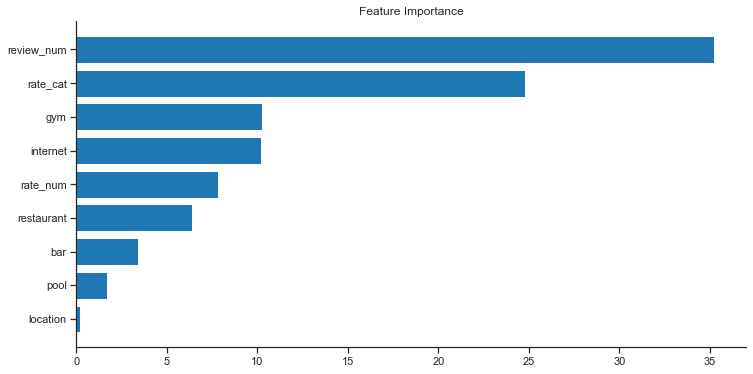

In [100]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

# Submission

In [143]:
submission_format = pd.read_csv('data/submission_format.csv')

In [144]:
submission_format

ID  Price
0      0  22000
1      1  22000
2      2  22000
3      3  22000
4      4  22000
..   ...    ...
762  762  22000
763  763  22000
764  764  22000
765  765  22000
766  766  22000

[767 rows x 2 columns]

In [145]:
# prediction for test dataset
preds = model.predict(ct.fit_transform(X_test[features]))

submission = pd.DataFrame({
    'ID': submission_format.ID,
    'Price': preds
})

submission.head()

ID         Price
0   0  10978.401367
1   1  15364.506836
2   2  16269.718750
3   3  10803.920898
4   4  17121.666016

In [146]:
# export submission to csv

submission.to_csv('submission.csv', index=False)
print('Successfully saved!')

Successfully saved!
